## Contents:
    - 1. Import Data
    - 2. Missing values
    - 3. Feature Engineering
    - 4. Explorary Data Analysis

In [1]:
import numpy as np
import pandas as pd

from numpy import mean, std, cov, sqrt, log, sum

from datetime import date, timedelta, datetime

from scipy.stats import pearsonr,spearmanr, boxcox
from scipy import stats

from random import sample

from apyori import apriori
from mlxtend.frequent_patterns import apriori

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import matplotlib.style as style

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.formula.api import ols


import warnings
warnings.filterwarnings('ignore')

import scripts as src

from IPython.display import HTML, display

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rcParams['figure.figsize'] = (6, 3)

<h1 style="background-color:powderblue;">1. Import Data</h1>


In [2]:
raw_beneficiary=pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv')
raw_inpatient=pd.read_csv('data/Train_Inpatientdata-1542865627584.csv')
raw_outpatient=pd.read_csv('data/Train_Outpatientdata-1542865627584.csv')
raw_train=pd.read_csv('data/Train-1542865627584.csv')

In [3]:
inpatient_beneficiary=pd.merge(raw_inpatient,raw_beneficiary,on='BeneID')
outpatient_beneficiary=pd.merge(raw_outpatient,raw_beneficiary,on='BeneID')

outpatient_beneficiary['Category']='Outpatient'
inpatient_beneficiary['Category']='Inpatient'

train=pd.concat([outpatient_beneficiary, inpatient_beneficiary], axis = 0)
train=pd.merge(train,raw_train,on='Provider', how='left')

<h1 style="background-color:powderblue;">4. Explorary Data Analysis</h1>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Duplicate Claims</h1>

In [209]:
basic_info=['BeneID', 'ClaimStartDt', 'Provider','PotentialFraud']
boolean = train[basic_info].duplicated().any() # True
boolean

True

In [76]:
basic_info=['BeneID', 'ClaimStartDt', 'Provider','PotentialFraud']
df=train[basic_info]
# if (duplicated := df.duplicated(keep=False)).any():
duplicated = df.duplicated(keep=False)
some_duplicates = df[duplicated].sort_values(by=df.columns.to_list())

some_duplicates=pd.merge(some_duplicates.drop_duplicates(),
                         train,
                         on=['BeneID', 'ClaimStartDt', 'Provider', 'PotentialFraud'], 
                         how='left')
print(str(len(some_duplicates))+ " claims with one or more duplicated rows, for example:")
display(some_duplicates.head())    
df_BeneIDgrp=some_duplicates.groupby(['BeneID']).count()['ClaimID'].sort_values(ascending=False)
print(str(len(df_BeneIDgrp)) + " Beneficiaries have one or more duplicate claims, for example: ")
display(df_BeneIDgrp.head())  
df_ProviderGroup=some_duplicates.groupby(['Provider']).count()['ClaimID'].sort_values(ascending=False)
print(str(len(df_ProviderGroup)) + " Providers have one or more duplicate claims, for example: ")
display(df_ProviderGroup.head())

2798 claims with one or more duplicated rows, for example:


BeneID ClaimStartDt  Provider PotentialFraud    ClaimID  ClaimEndDt  InscClaimAmtReimbursed AttendingPhysician OperatingPhysician OtherPhysician ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7 ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  DeductibleAmtPaid ClmAdmitDiagnosisCode         DOB  Gender Race RenalDiseaseIndicator State County  NoOfMonths_PartACov  NoOfMonths_PartBCov ChronicCond_Alzheimer ChronicCond_Heartfailure ChronicCond_KidneyDisease ChronicCond_Cancer ChronicCond_ObstrPulmonary ChronicCond_Depression ChronicCond_Diabetes ChronicCond_IschemicHeart ChronicCond_Osteoporasis ChronicCond_rheumatoidarthritis ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  OPAnnualDeductibleAmt    Category DiagnosisGroupCode  \
0  BENE100033   2009-02-25  PRV53662             No  CLM215203  2009-02-25                     300          PHY349531          PHY349531            NaN              27901                  0                  0                  0                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                     0  1943-04-01    Male    1                     Y    20     90                   12                   12                     1                        1                         1                  0                          0                      1                    1                         1                        1                               0                  0                      4000                   1068                      4480                     70  Outpatient                  0   
1  BENE100033   2009-02-25  PRV53662             No  CLM215204  2009-02-25                      90          PHY367934                NaN            NaN              25022               4011                  0                  0                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                 25042  1943-04-01    Male    1                     Y    20     90                   12                   12                     1                        1                         1                  0                          0                      1                    1                         1                        1                               0                  0                      4000                   1068                      4480                     70  Outpatient                  0   
2  BENE100044   2009-04-03  PRV55835            Yes  CLM282612  2009-04-03                     300          PHY414564                NaN            NaN               8709               3320              78079              E8889                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                     0  1941-07-01  Female    1                     0    38    160                   12                   12                     0                        1                         1                  0                          0                      1                    1                         1                        1                               0                  1                     27000                   1068                      1540                   2170  Outpatient                  0   
3  BENE100044   200

1365 Beneficiaries have one or more duplicate claims, for example: 


BeneID
BENE146725    6
BENE16142     5
BENE118145    4
BENE108647    4
BENE133699    4
Name: ClaimID, dtype: int64

586 Providers have one or more duplicate claims, for example: 


Provider
PRV51459    76
PRV51574    52
PRV55039    38
PRV57172    37
PRV53918    37
Name: ClaimID, dtype: int64

Total number of Claims: 2798


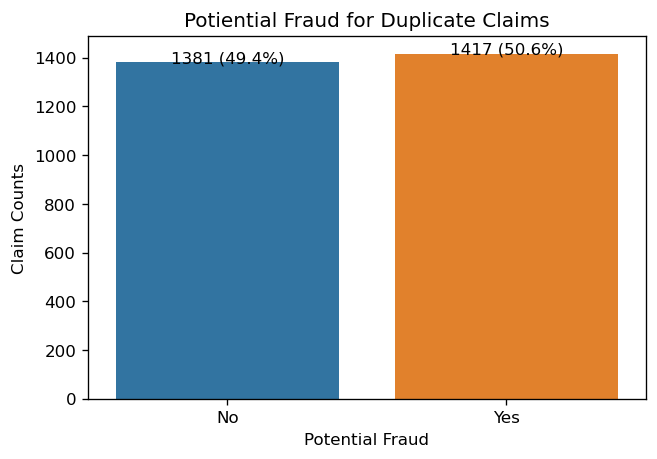

In [77]:
df=some_duplicates[['PotentialFraud','ClaimID']].drop_duplicates()
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            data = df,
            order = df['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Claim Counts')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for Duplicate Claims')

annote_bars(df, 'PotentialFraud', 2, hue_feature=None, note_type='count_percentage', ax=ax)
print('Total number of Claims:' , df['ClaimID'].nunique())

Total number of Claims: 558211


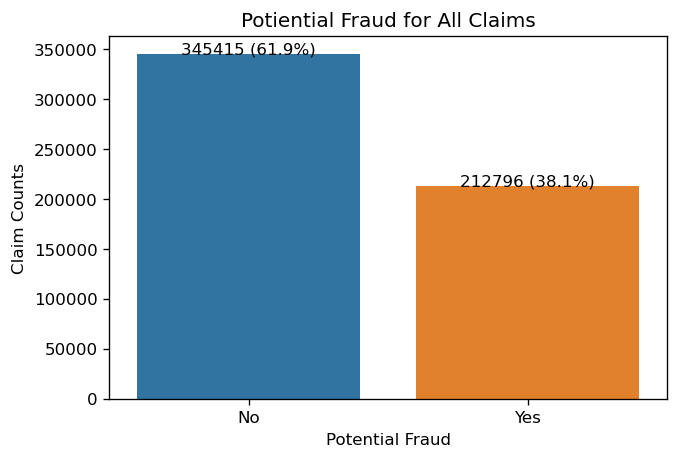

In [78]:
df=train[['PotentialFraud','ClaimID']].drop_duplicates()
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            data = df,
            order = df['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Claim Counts')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for All Claims')

annote_bars(df, 'PotentialFraud', 2, hue_feature=None, note_type='count_percentage', ax=ax)
print('Total number of Claims:' , df['ClaimID'].nunique())

Total number of Hospitals: 586


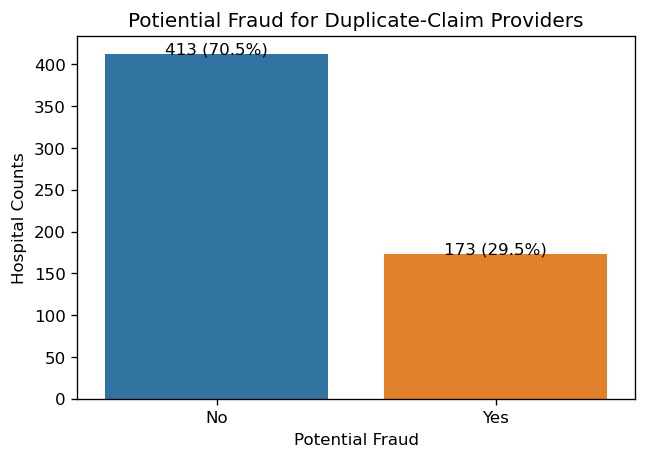

In [115]:
df=some_duplicates[['PotentialFraud','Provider']].drop_duplicates()
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            data = df,
            order = df['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Hospital Counts')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for Duplicate-Claim Providers')

annote_bars(df, 'PotentialFraud', 2, hue_feature=None, note_type='count_percentage', ax=ax)
print('Total number of Hospitals:' , df['Provider'].nunique())

Total number of Hospitals: 5410


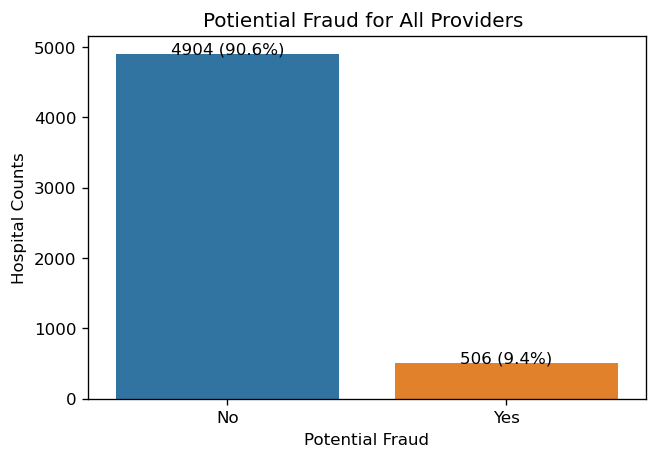

In [80]:
df=train[['PotentialFraud','Provider']].drop_duplicates()
plt.figure(figsize=(6,4))
ax=sns.countplot(x = 'PotentialFraud',
            data = df,
            order = df['PotentialFraud'].value_counts().index.sort_values())

ax.set_ylabel('Hospital Counts')
ax.set_xlabel('Potential Fraud')
ax.set_title('Potiential Fraud for All Providers ')

annote_bars(df, 'PotentialFraud', 2, hue_feature=None, note_type='count_percentage', ax=ax)
print('Total number of Hospitals:' , df['Provider'].nunique())

In [81]:
def color_list(n):
    chars = '0123456789ABCDEF'
    return ['#'+''.join(sample(chars,6)) for i in range(n)]


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)


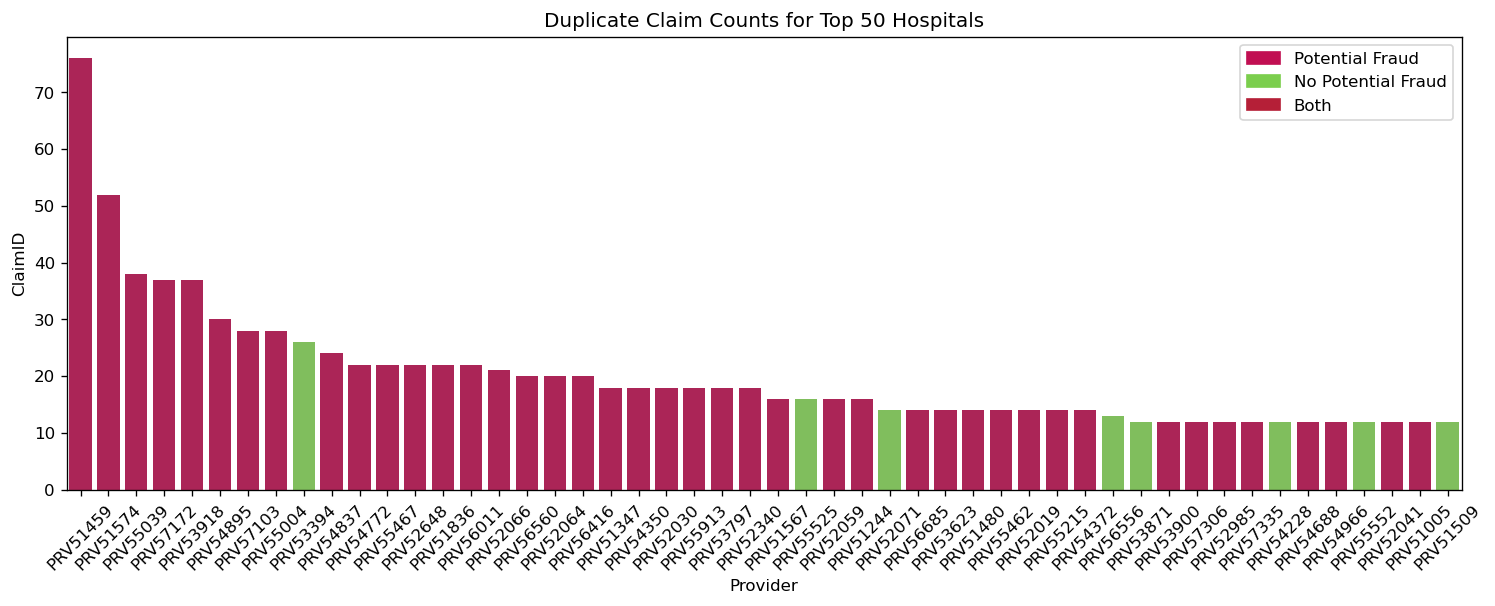

In [117]:
from random import sample
df=some_duplicates[['ClaimID','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='ClaimID', ascending=False)
top_provider=df.head(50)
bar_by_category(top_provider, 'Provider', 'ClaimID', 'PotentialFraud', title='Duplicate Claim Counts for Top 50 Hospitals')


In [118]:
df.index=range(len(df))
df

Provider PotentialFraud  ClaimID
0    PRV51459            Yes       76
1    PRV51574            Yes       52
2    PRV55039            Yes       38
3    PRV57172            Yes       37
4    PRV53918            Yes       37
..        ...            ...      ...
581  PRV54256             No        2
582  PRV54244             No        2
583  PRV51410            Yes        2
584  PRV54225            Yes        2
585  PRV57718             No        2

[586 rows x 3 columns]

In [120]:
df_dup_counts=pd.DataFrame()
li=[]
lcy=[]
lcn=[]
lp=[]
for i in range (10, 500, 50):
    dup_no=df.head(i-1).groupby('PotentialFraud')['ClaimID'].count()[0]
    dup_yes=df.head(i-1).groupby('PotentialFraud')['ClaimID'].count()[1]
    li.append(i)
    lcy.append(dup_yes)
    lcn.append(dup_no)
    lp.append(dup_yes/(dup_no+dup_yes))
    
df_dup_counts['Top-Provider-Number']=li
df_dup_counts['Counts(yes)']=lcy
df_dup_counts['Counts(no)']=lcn
df_dup_counts['Percentage(yes)']=lp

df_dup_counts.sort_values(by='Top-Provider-Number',ascending=True)

Top-Provider-Number  Counts(yes)  Counts(no)  Percentage(yes)
0                   10            8           1         0.888889
1                   60           48          11         0.813559
2                  110           68          41         0.623853
3                  160           84          75         0.528302
4                  210           97         112         0.464115
5                  260          107         152         0.413127
6                  310          116         193         0.375405
7                  360          130         229         0.362117
8                  410          138         271         0.337408
9                  460          145         314         0.315904

- While multiple claims with identical information are not always fraudulent, the prevalence of
these duplicated records would signal potential fraud activities. 


- Consider the various diagnosis codes, procedure codes, admit diagnosis codes as the key features, please identify
the duplicated claims in the inpatients_train, outpatients_train data.


In [85]:
codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']
diagnosis_codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10','ClmAdmitDiagnosisCode','DiagnosisGroupCode']
procedure_codelist=['ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

df=train[codelist].replace('0',np.nan)

train['DiagnosisCodeCounts']=df[diagnosis_codelist].count(axis=1)
train['ProcedureCodeCounts']=df[procedure_codelist].count(axis=1)

In [86]:
basic_info=['BeneID', 'ClaimStartDt', 'Provider','PotentialFraud']
df=train[basic_info]
duplicated = df.duplicated(keep=False)
some_duplicates = df[duplicated].sort_values(by=df.columns.to_list())

some_duplicates=pd.merge(some_duplicates.drop_duplicates(),
                         train,
                         on=['BeneID', 'ClaimStartDt', 'Provider', 'PotentialFraud'], 
                         how='left')

df_dup_counts=some_duplicates[['ClaimID','Provider', 'PotentialFraud']].drop_duplicates() \
    .groupby(['Provider', 'PotentialFraud']).count().reset_index().sort_values(by='ClaimID', ascending=False)
df_dup_counts.rename( columns={'ClaimID':'DuplicateClaimCounts'}, inplace=True)

In [87]:
df_dup_codes=some_duplicates.groupby(['Provider', 'PotentialFraud', 'ClmAdmitDiagnosisCode']).count()['ClaimID']
df_dup_codes=df_dup_codes.sort_values(ascending=False).reset_index()
df_dup_codes=df_dup_codes.replace('0',np.nan)
df_dup_codes.dropna(how='any', inplace=True)
df_dup_codes.rename( columns={'ClaimID':'DuplicateAdmitDiagCode'}, inplace=True)
ProviderList=df_dup_codes[df_dup_codes['DuplicateAdmitDiagCode']>1]['Provider'].unique()
train['IsDuplicateClmAdmDiagCode']=np.where(train['Provider'].isin(ProviderList),'Yes','No')

In [88]:
df_dup_codes=some_duplicates.groupby(['Provider', 'PotentialFraud', 'DiagnosisGroupCode']).count()['ClaimID']
df_dup_codes=df_dup_codes.sort_values(ascending=False).reset_index()
df_dup_codes=df_dup_codes.replace('0',np.nan)
df_dup_codes.dropna(how='any', inplace=True)
df_dup_codes.rename( columns={'ClaimID':'DuplicateDiagnosisGroupCode'}, inplace=True)
ProviderList=df_dup_codes[df_dup_codes['DuplicateDiagnosisGroupCode']>1]['Provider'].unique()
train['IsDuplicateDiagGrpCode']=np.where(train['Provider'].isin(ProviderList),'Yes','No')

In [89]:
codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']

diagnosislist=['BeneID', 'ClaimStartDt', 'Provider','AttendingPhysician','Category','PotentialFraud',
       'State', 'County','ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6','ClmAdmitDiagnosisCode','DiagnosisGroupCode']

In [90]:
dup_inpatient=some_duplicates[some_duplicates['Category']=='Inpatient'][codelist]
dup_inpatient=dup_inpatient.replace('0', np.nan)
print(str(len(dup_inpatient))+' Inpatient claims have one or more duplicates \n')
print('# of unique values for each diagnosis code:')
dup_inpatient.nunique().sort_values(ascending=False)

109 Inpatient claims have one or more duplicates 

# of unique values for each diagnosis code:


DiagnosisGroupCode       84
ClmDiagnosisCode_4       75
ClmDiagnosisCode_7       73
ClmDiagnosisCode_3       72
ClmDiagnosisCode_2       72
ClmDiagnosisCode_6       71
ClmDiagnosisCode_1       70
ClmDiagnosisCode_5       69
ClmDiagnosisCode_8       63
ClmAdmitDiagnosisCode    62
ClmDiagnosisCode_9       60
ClmProcedureCode_1       43
ClmProcedureCode_2       12
ClmDiagnosisCode_10       8
ClmProcedureCode_3        2
ClmProcedureCode_4        0
ClmProcedureCode_5        0
ClmProcedureCode_6        0
dtype: int64

In [91]:
dup_outpatient=some_duplicates[some_duplicates['Category']=='Outpatient'][codelist]
dup_outpatient=dup_outpatient.replace('0', np.nan)
print(str(len(dup_outpatient))+' Outpatient claims have one or more duplicates \n')
print('# of unique values for each diagnosis code:')
dup_outpatient.nunique().sort_values(ascending=False)

2689 Outpatient claims have one or more duplicates 

# of unique values for each diagnosis code:


ClmDiagnosisCode_1       1508
ClmDiagnosisCode_2        581
ClmDiagnosisCode_3        446
ClmDiagnosisCode_4        316
ClmAdmitDiagnosisCode     296
ClmDiagnosisCode_5        239
ClmDiagnosisCode_6        173
ClmDiagnosisCode_7        129
ClmDiagnosisCode_8         99
ClmDiagnosisCode_9         64
ClmDiagnosisCode_10         5
ClmProcedureCode_2          0
ClmProcedureCode_3          0
ClmProcedureCode_4          0
ClmProcedureCode_5          0
ClmProcedureCode_6          0
ClmProcedureCode_1          0
DiagnosisGroupCode          0
dtype: int64

In [92]:
some_duplicates.head()

BeneID ClaimStartDt  Provider PotentialFraud    ClaimID  ClaimEndDt  InscClaimAmtReimbursed AttendingPhysician OperatingPhysician OtherPhysician ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7 ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  DeductibleAmtPaid ClmAdmitDiagnosisCode         DOB  Gender Race RenalDiseaseIndicator State County  NoOfMonths_PartACov  NoOfMonths_PartBCov ChronicCond_Alzheimer ChronicCond_Heartfailure ChronicCond_KidneyDisease ChronicCond_Cancer ChronicCond_ObstrPulmonary ChronicCond_Depression ChronicCond_Diabetes ChronicCond_IschemicHeart ChronicCond_Osteoporasis ChronicCond_rheumatoidarthritis ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  OPAnnualDeductibleAmt    Category DiagnosisGroupCode  \
0  BENE100033   2009-02-25  PRV53662             No  CLM215203  2009-02-25                     300          PHY349531          PHY349531            NaN              27901                  0                  0                  0                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                     0  1943-04-01    Male    1                     Y    20     90                   12                   12                     1                        1                         1                  0                          0                      1                    1                         1                        1                               0                  0                      4000                   1068                      4480                     70  Outpatient                  0   
1  BENE100033   2009-02-25  PRV53662             No  CLM215204  2009-02-25                      90          PHY367934                NaN            NaN              25022               4011                  0                  0                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                 25042  1943-04-01    Male    1                     Y    20     90                   12                   12                     1                        1                         1                  0                          0                      1                    1                         1                        1                               0                  0                      4000                   1068                      4480                     70  Outpatient                  0   
2  BENE100044   2009-04-03  PRV55835            Yes  CLM282612  2009-04-03                     300          PHY414564                NaN            NaN               8709               3320              78079              E8889                  0                  0                  0                  0                  0                   0                  0                  0                  0                  0                  0                  0                0.0                     0  1941-07-01  Female    1                     0    38    160                   12                   12                     0                        1                         1                  0                          0                      1                    1                         1                        1                               0                  1                     27000                   1068                      1540                   2170  Outpatient                  0   
3  BENE100044   200

In [93]:
def most_codes(df):
    df_codes=pd.DataFrame()
    for col in df.columns:
        df_codes[col]=df.groupby([col]).count().iloc[:,1].sort_values(ascending=False)  
    if df_codes.index.isin(['nan']).any():
        df_codes.drop(['nan'], inplace=True)   
    if df_codes.index.isin(['0']).any():
        df_codes.drop(['0'], inplace=True)   
    df_codes=df_codes.sum(axis=1).sort_values(ascending=False)
    return df_codes

In [94]:
# Diagnosiscodelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
#        'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
#        'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
#        'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode','DiagnosisGroupCode']
Diagnosiscodelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
Procedurecodelist=[
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

codelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode','DiagnosisGroupCode',
        'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6' ]

In [95]:
# df_diagnosis=train[Diagnosiscodelist].replace('0',np.nan).dropna(how='all').replace(np.nan,'0')
# df_procedure=train[Procedurecodelist].replace('0',np.nan).dropna(how='all').replace(np.nan,'0')
# df_list=train[codelist].replace('0',np.nan).dropna(how='all').replace(np.nan,'0')

In [96]:
df_diagnosis=train[Diagnosiscodelist]
df_procedure=train[Procedurecodelist]
diagnosiscodelist=most_codes(df_diagnosis).head(30).index.tolist()
procedurecodelist=most_codes(df_procedure).head(30).index.tolist()

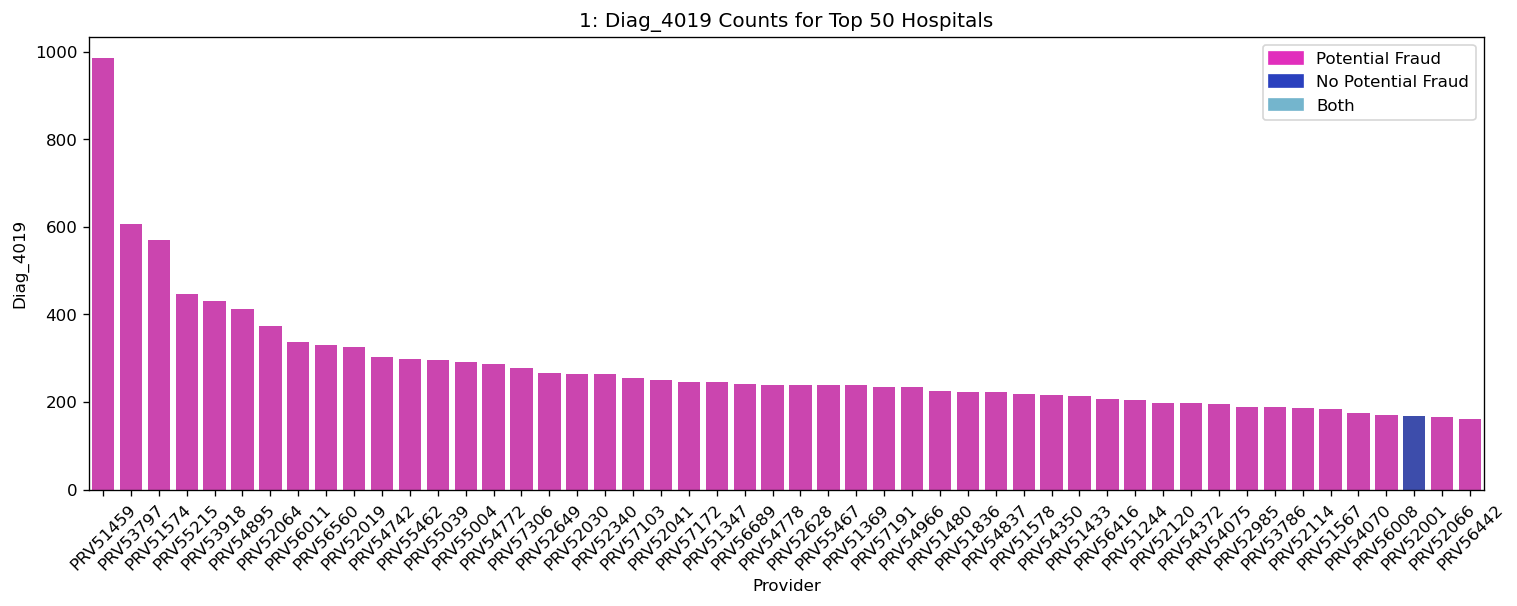

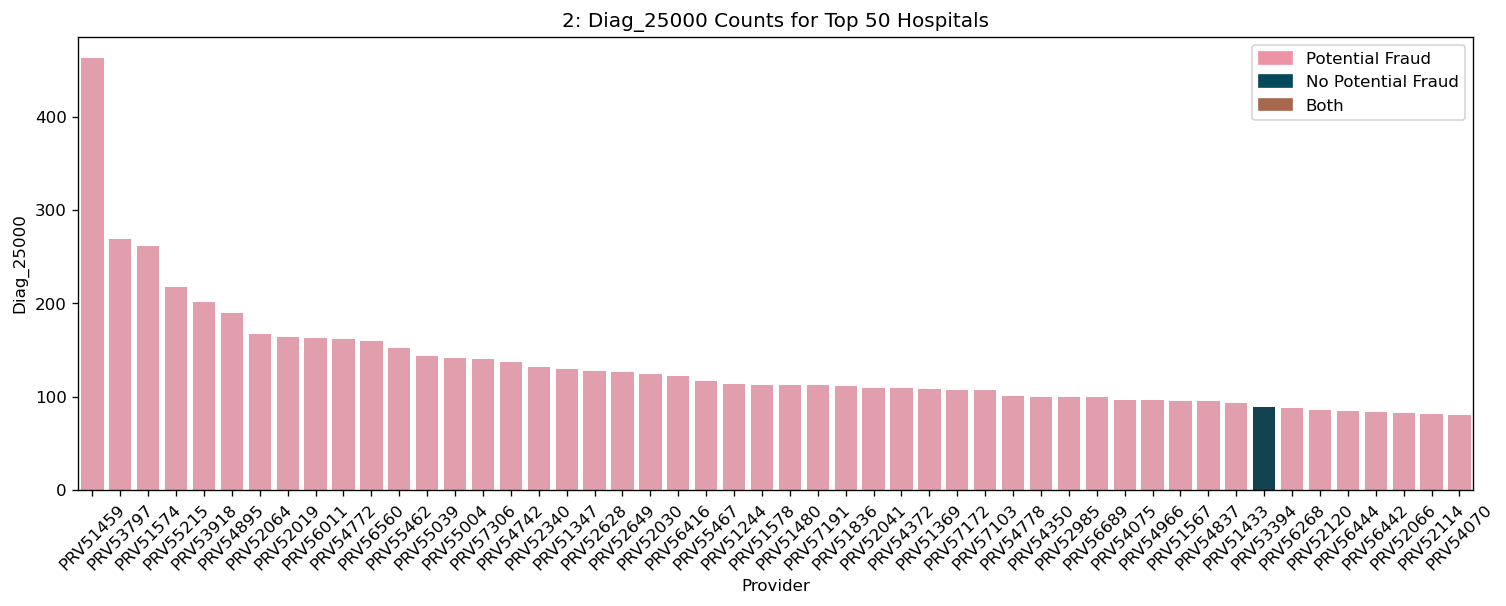

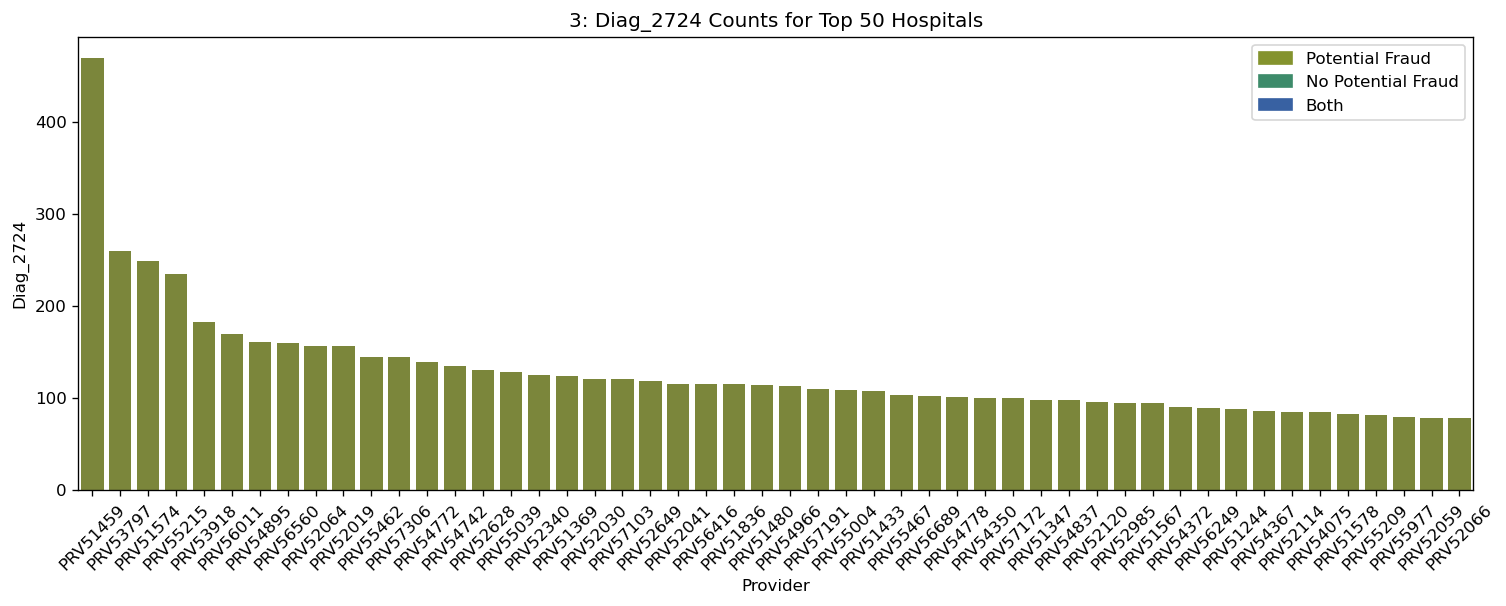

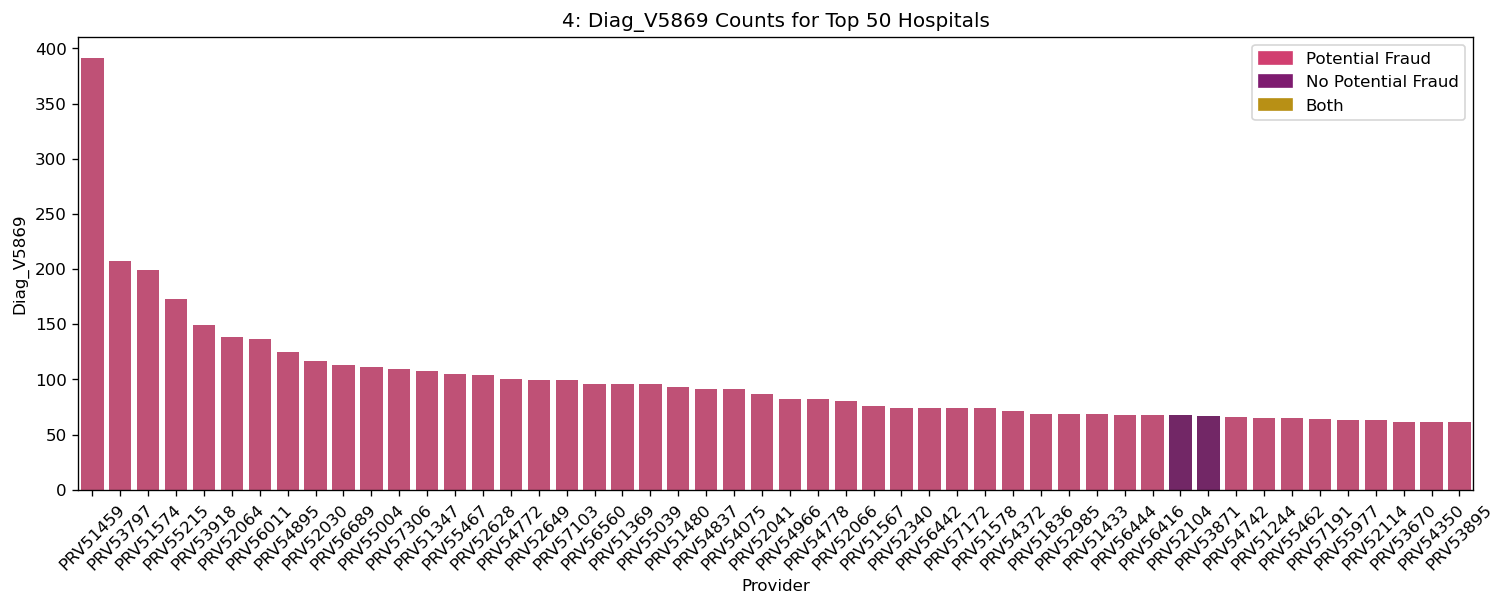

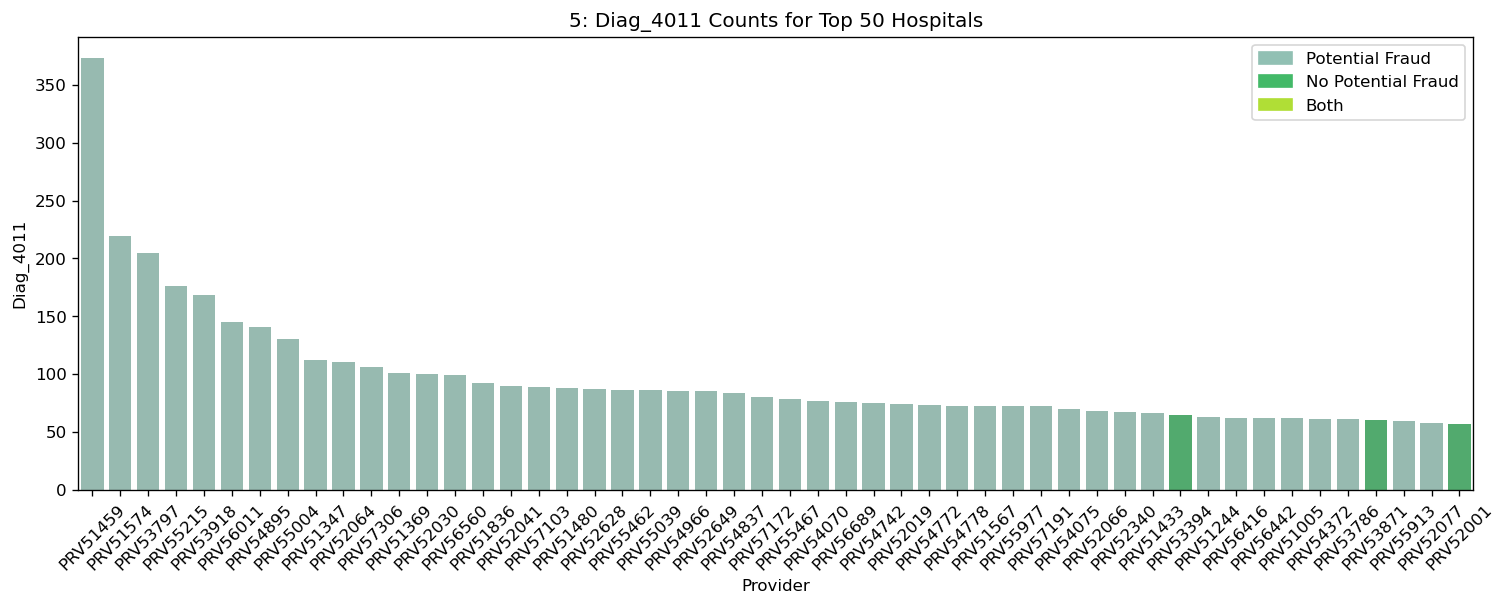

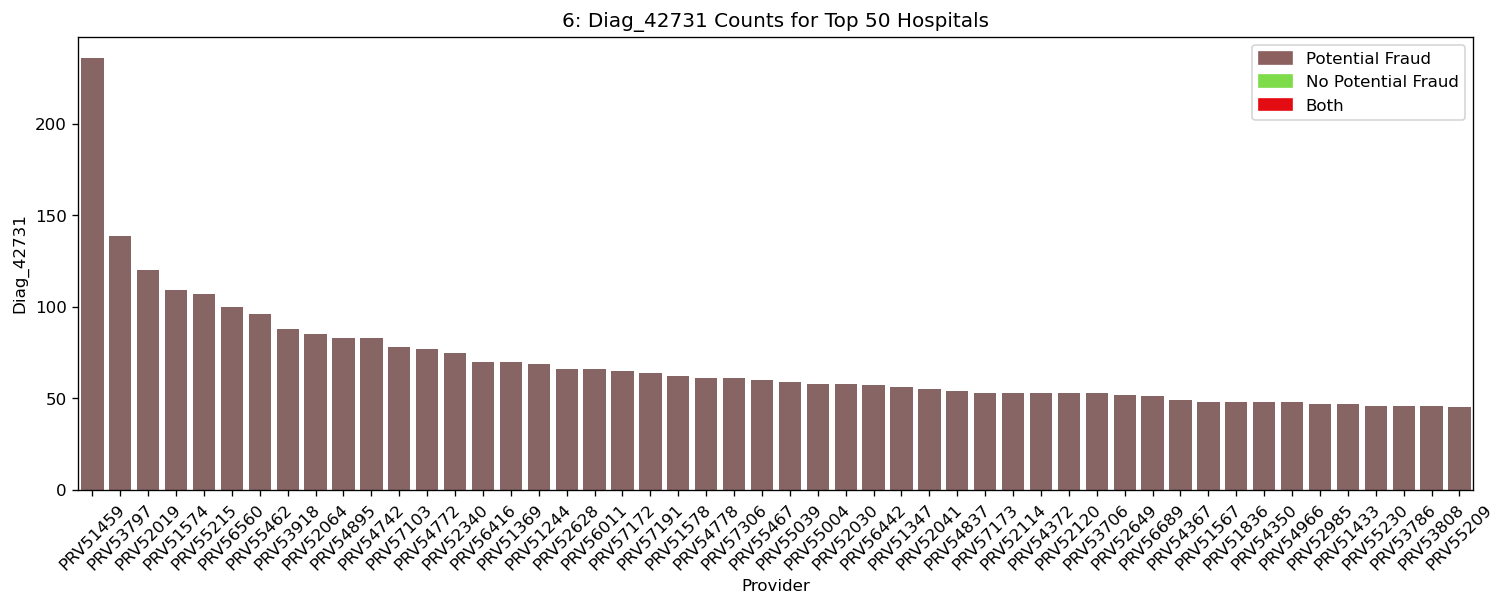

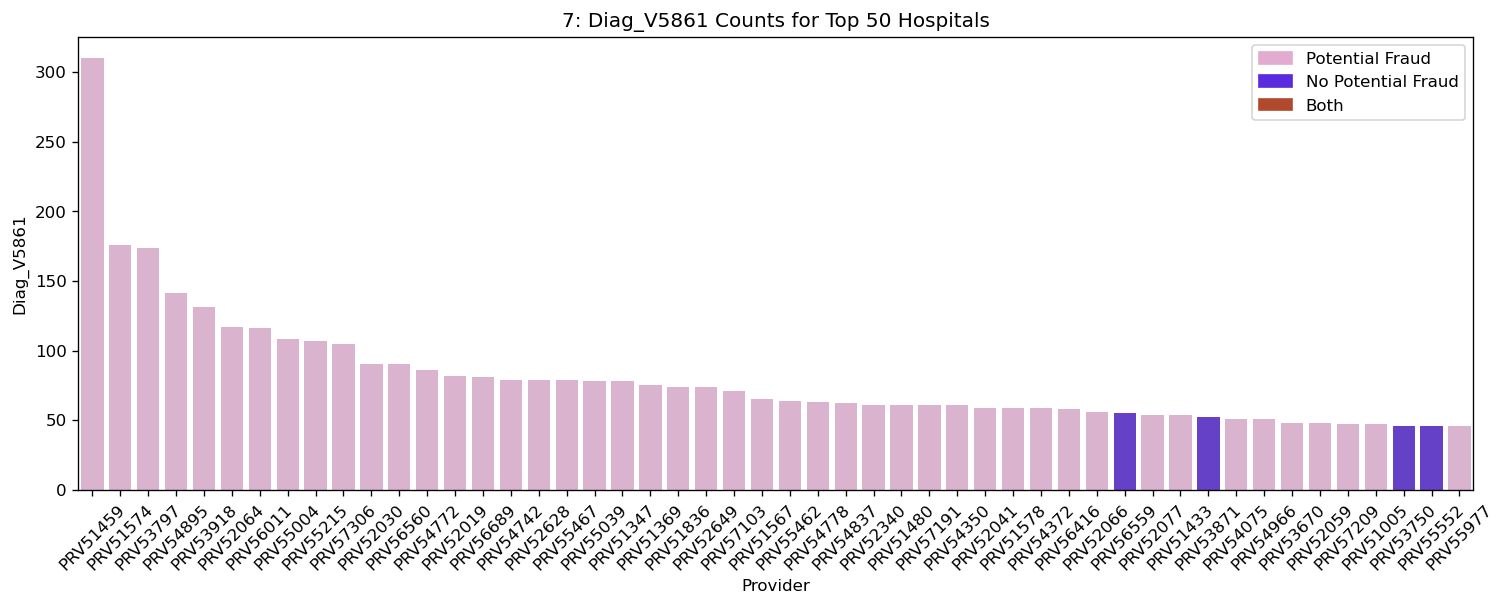

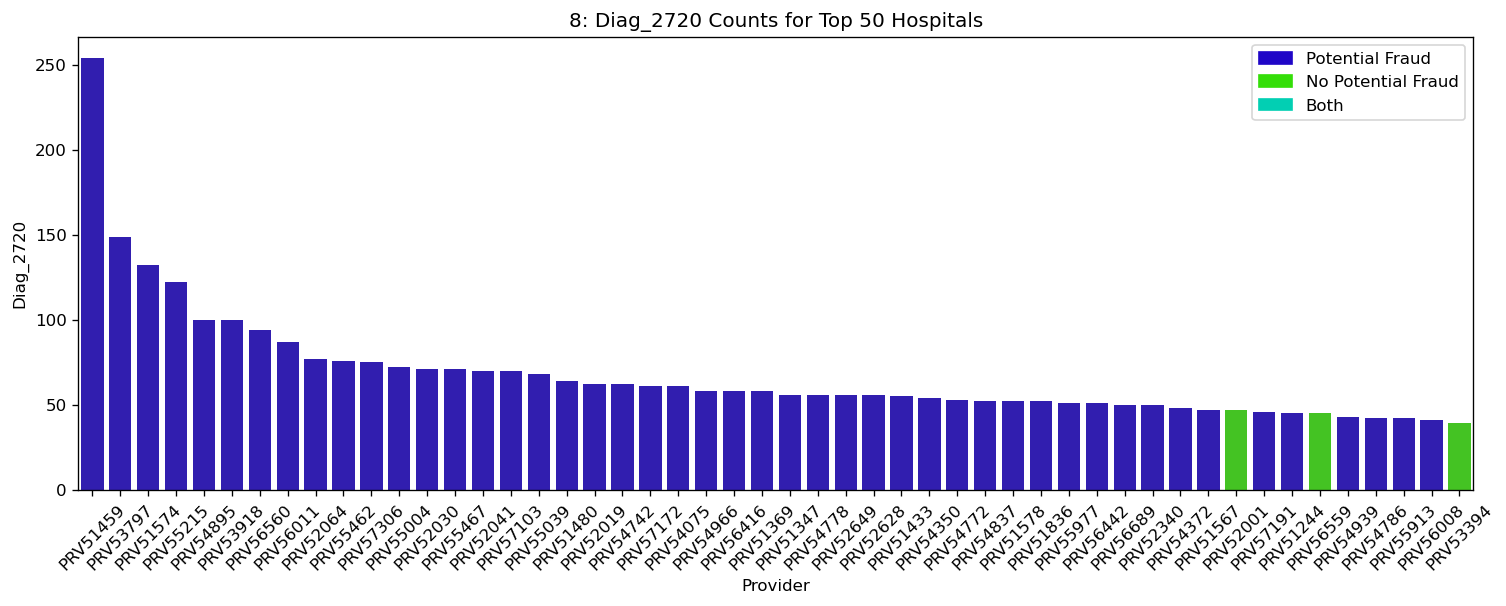

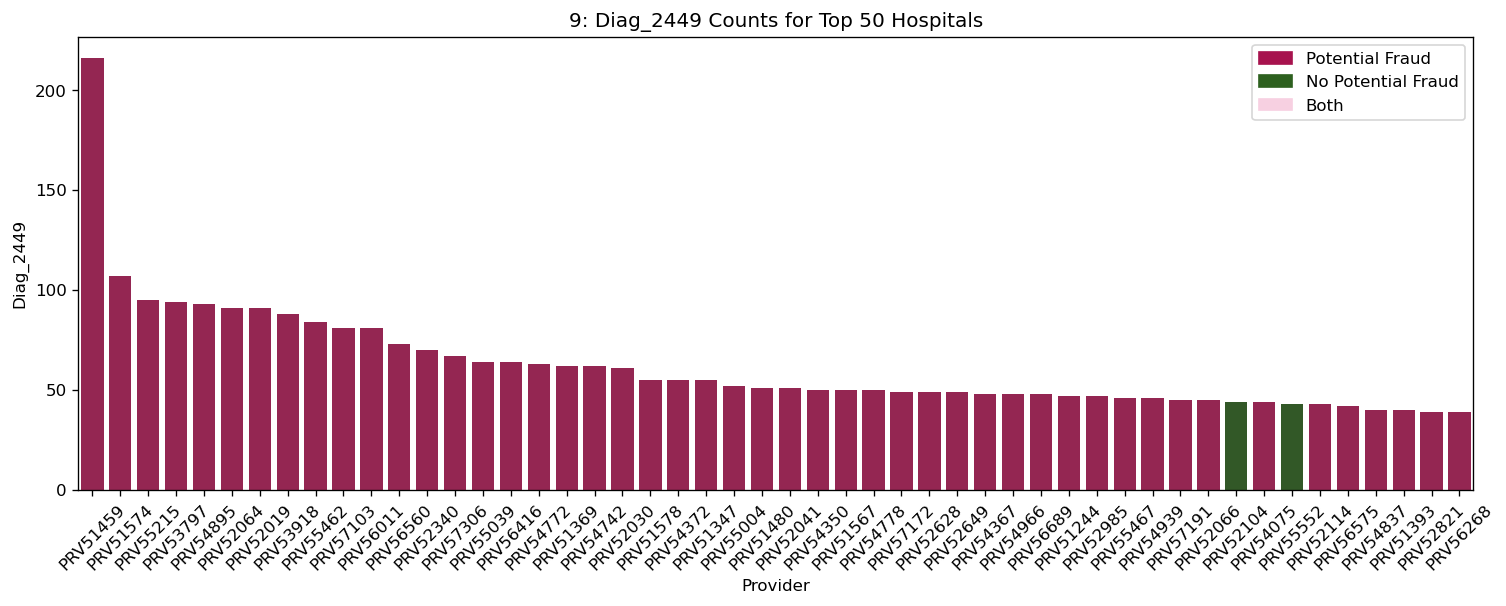

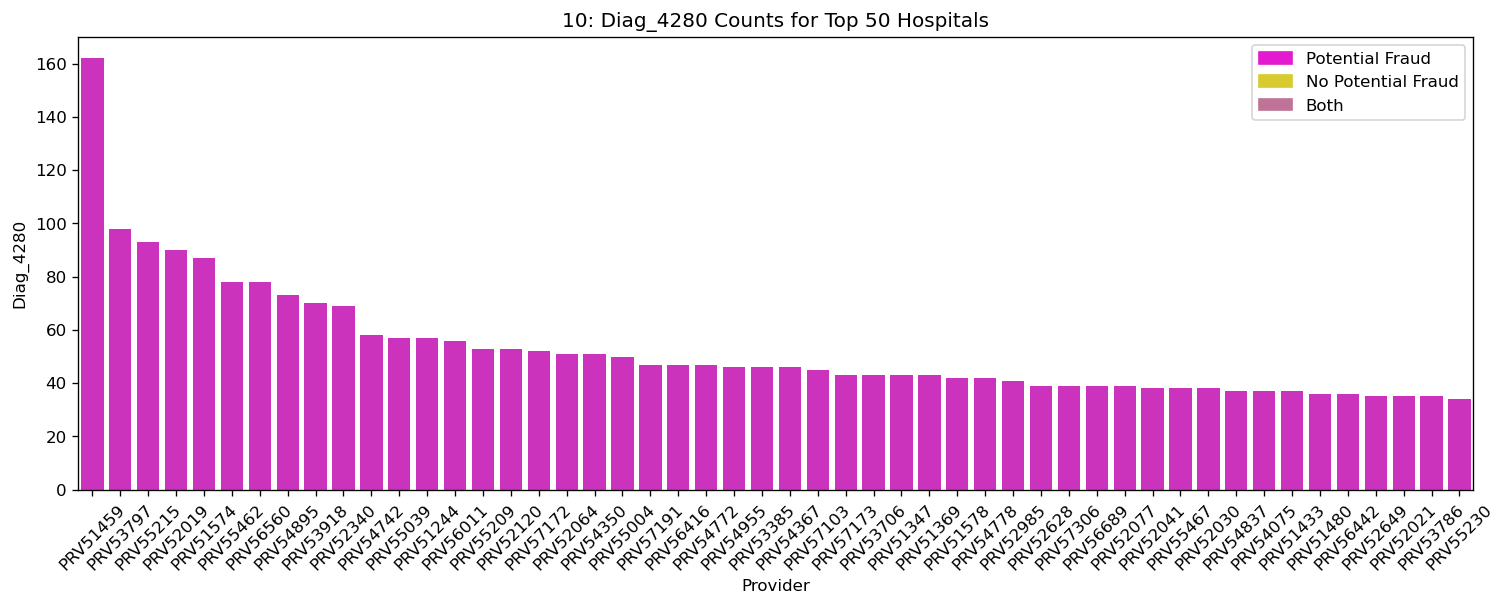

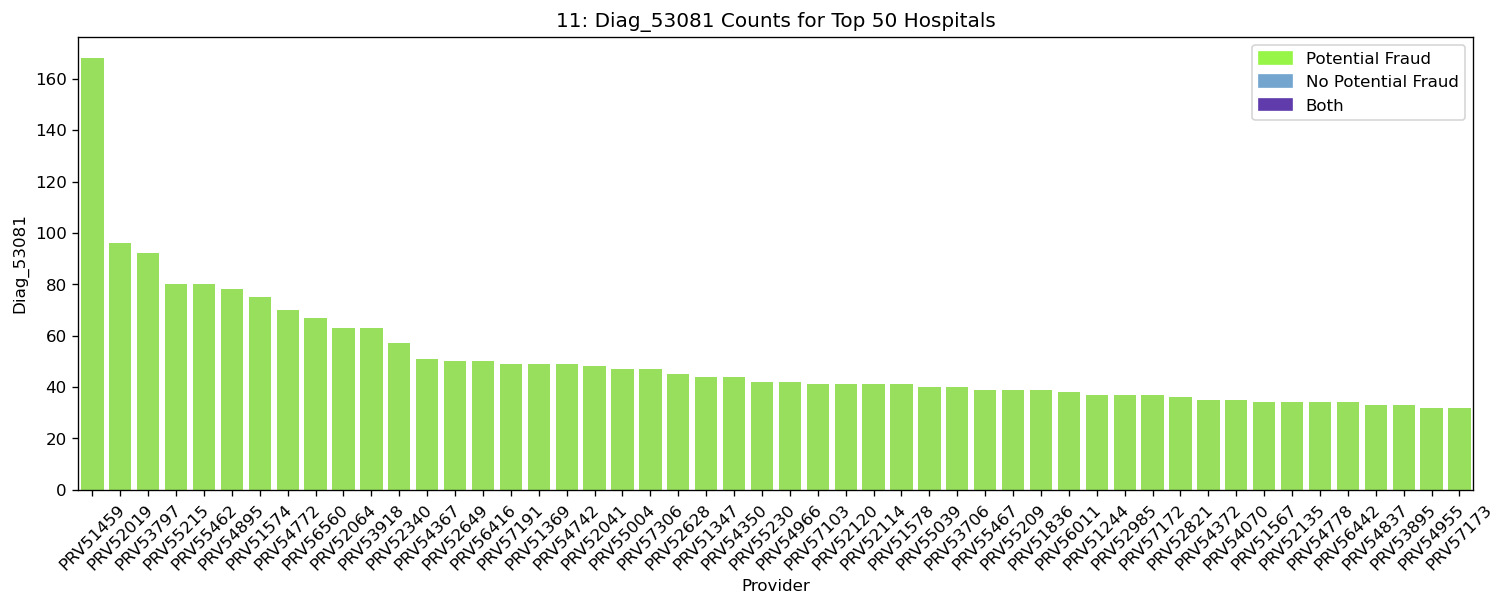

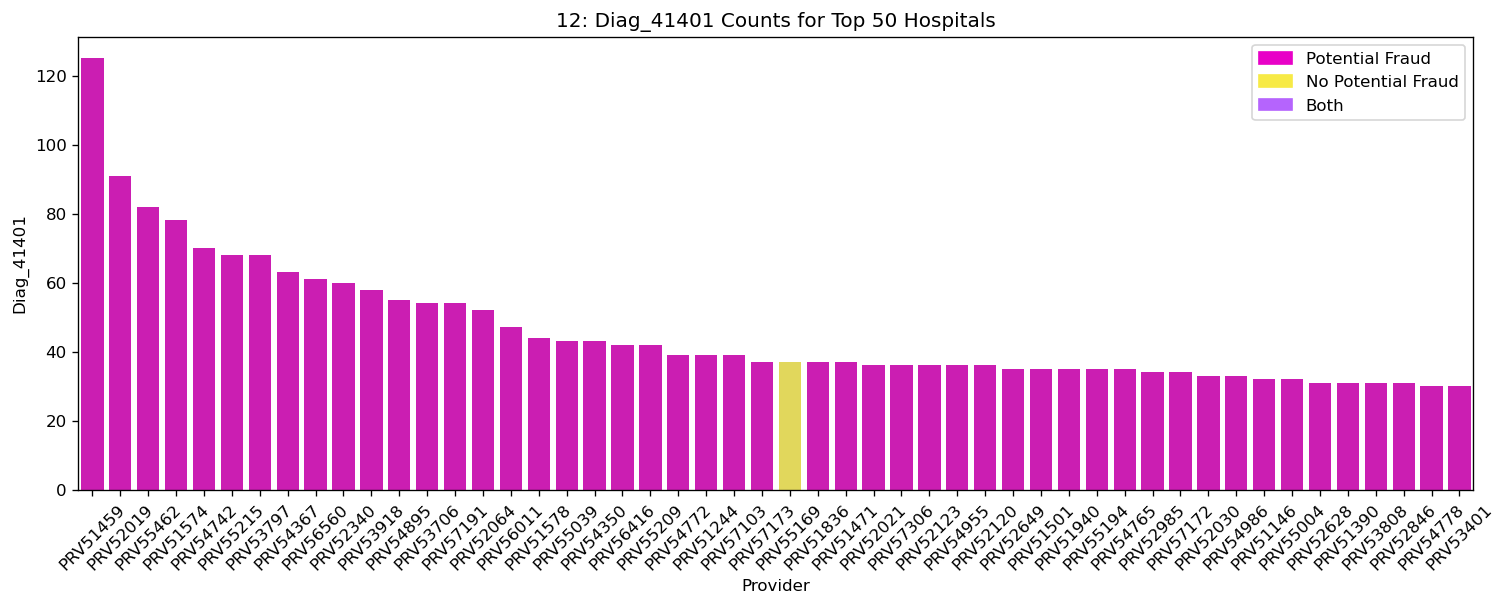

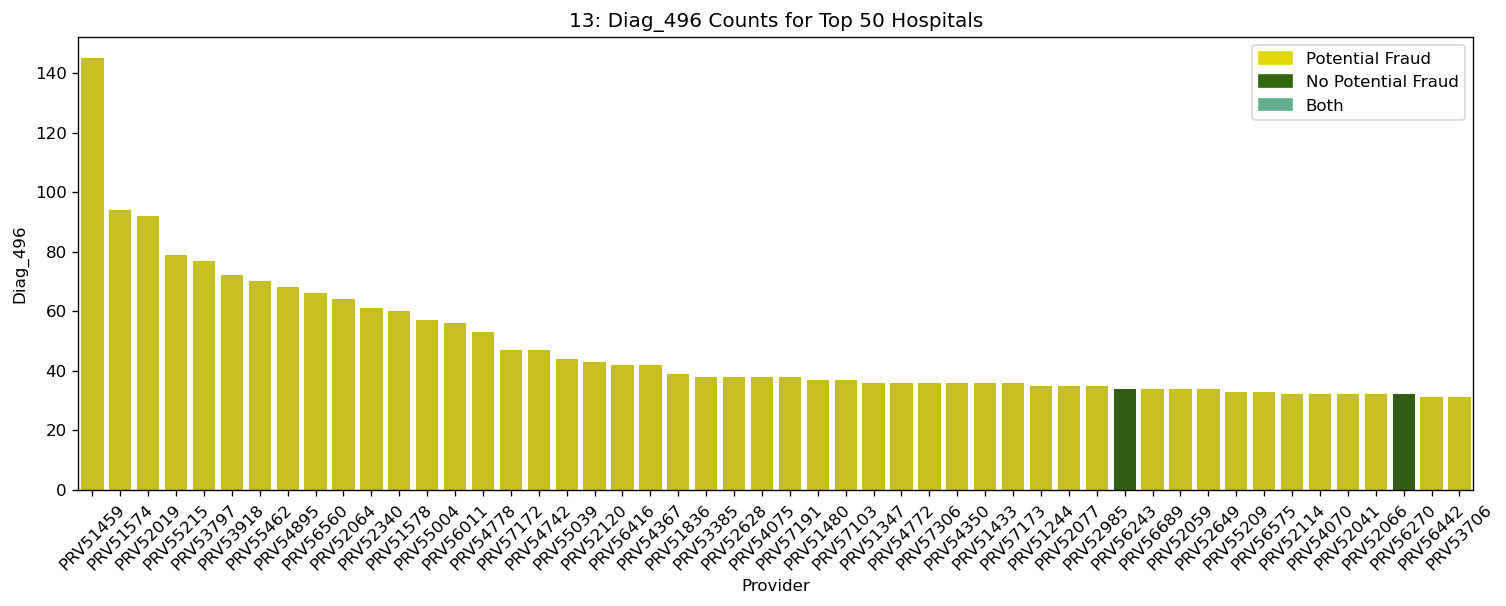

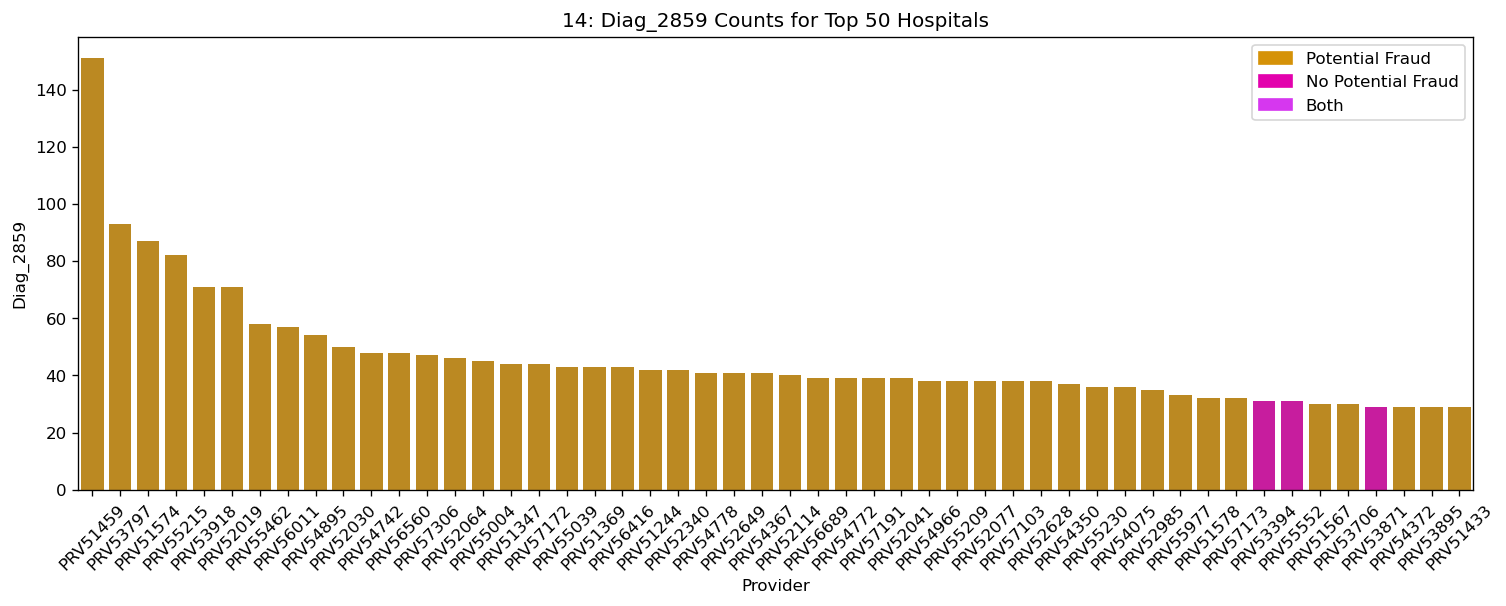

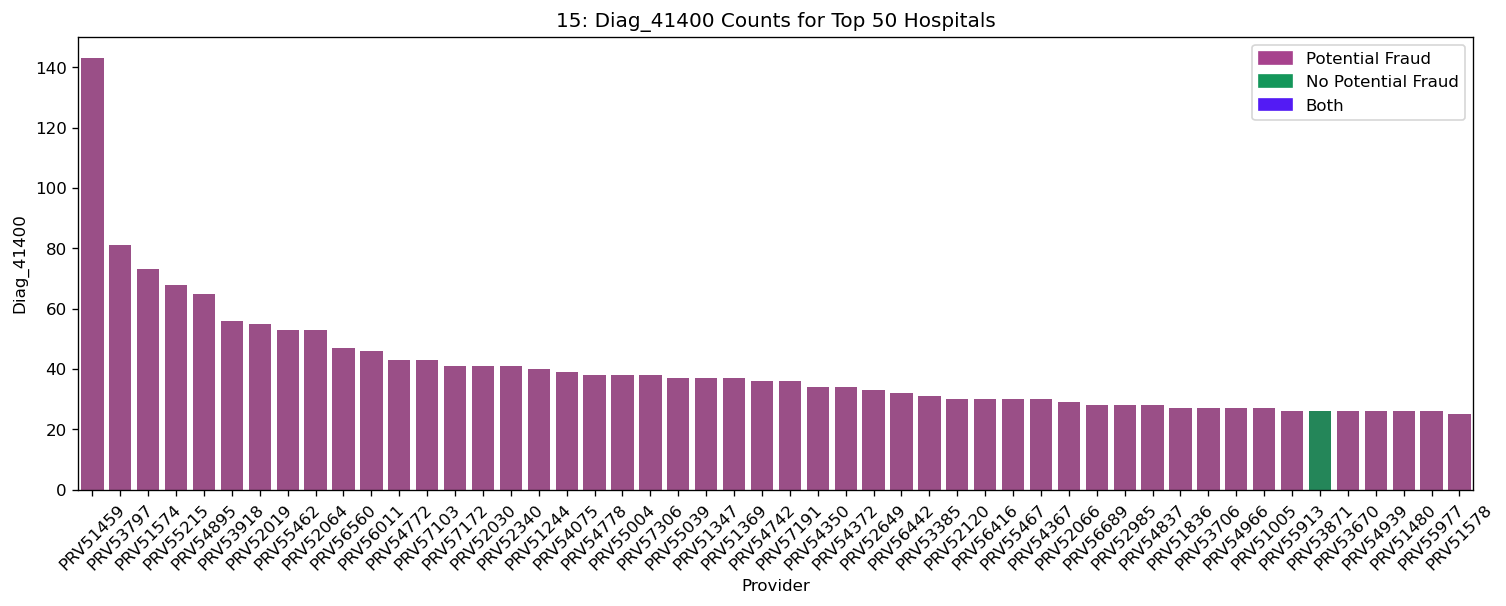

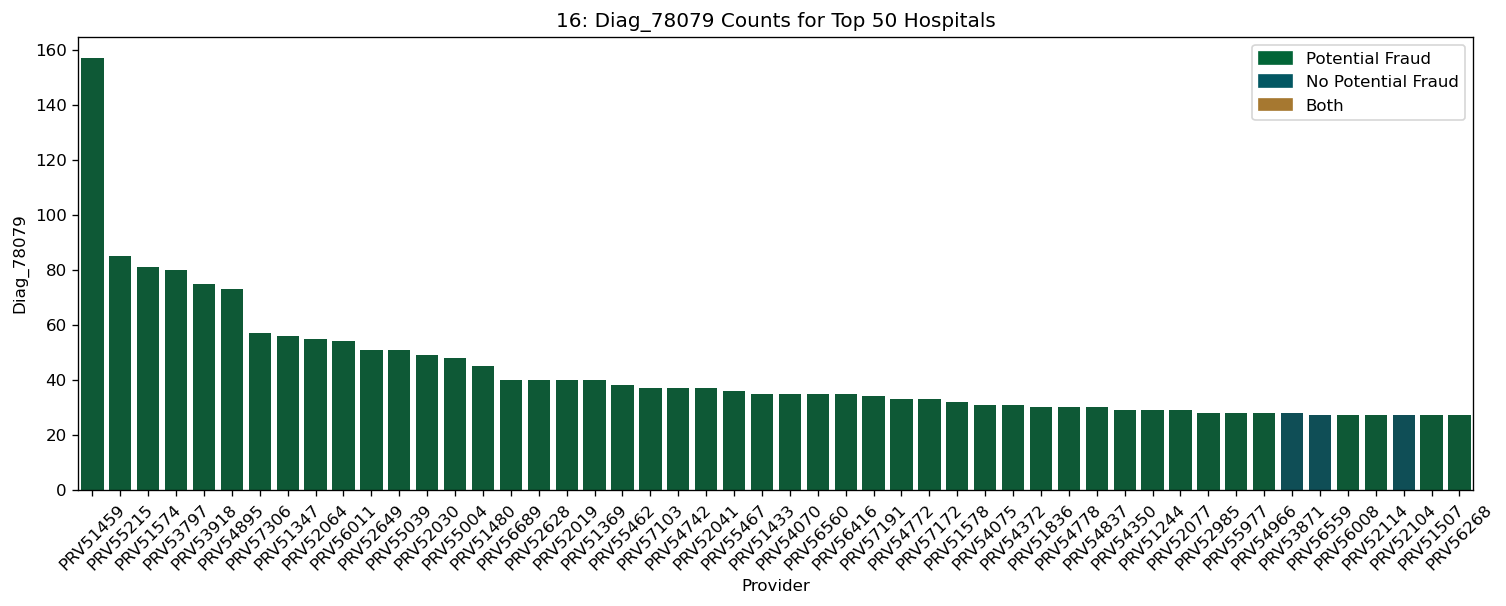

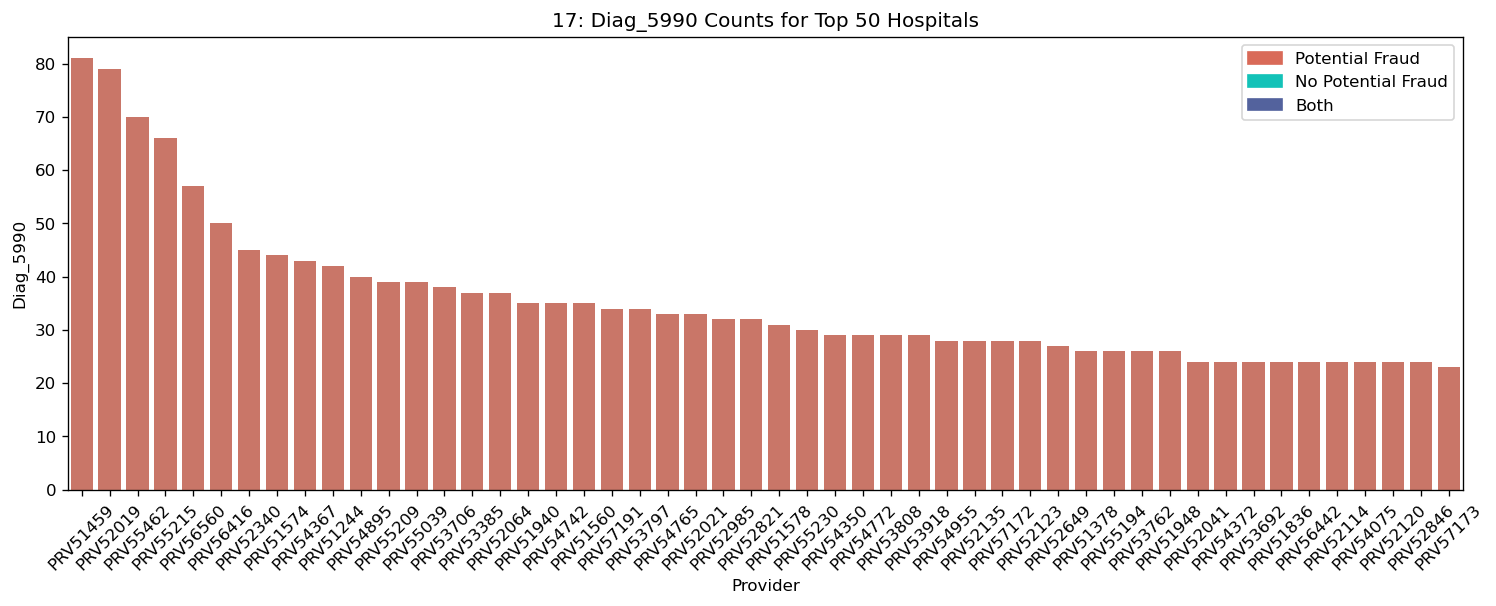

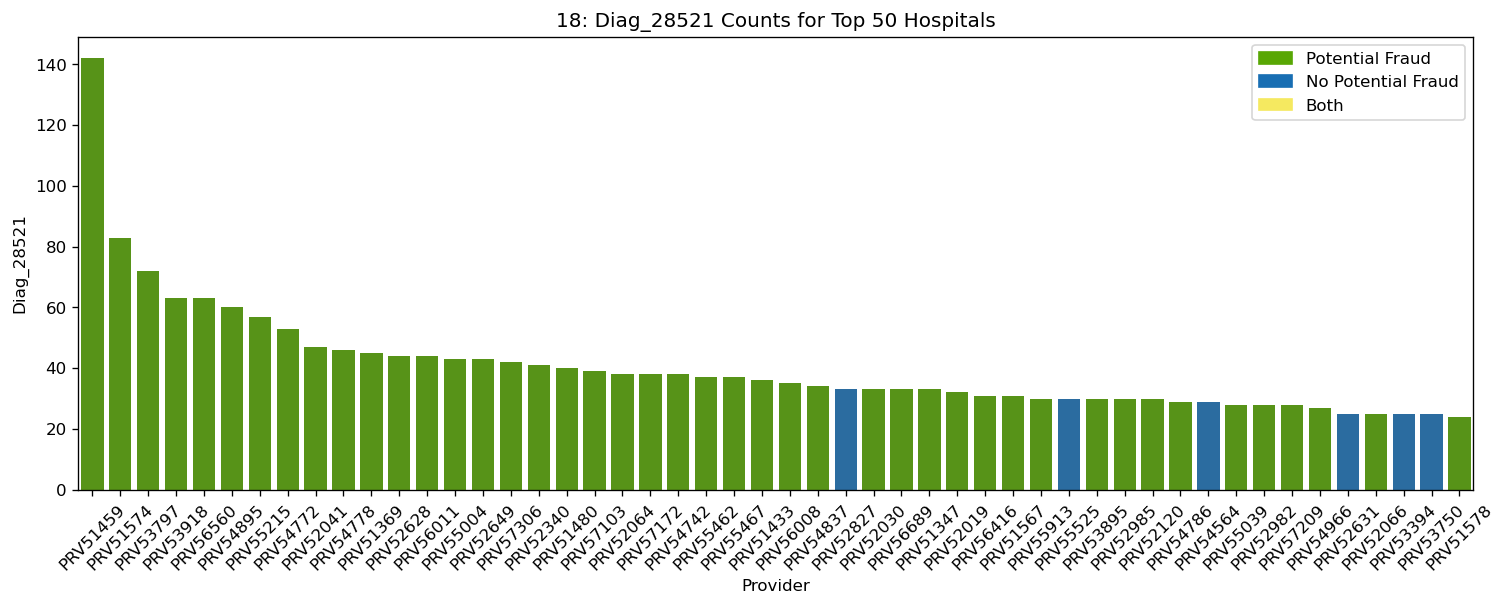

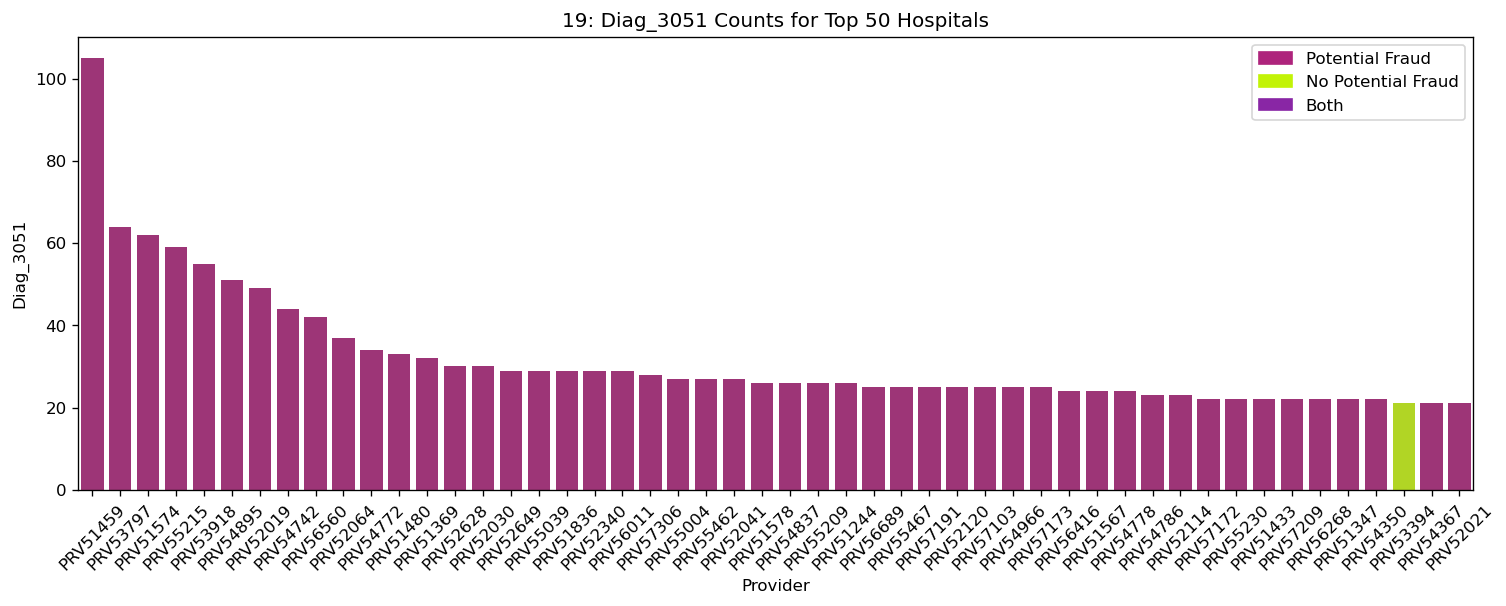

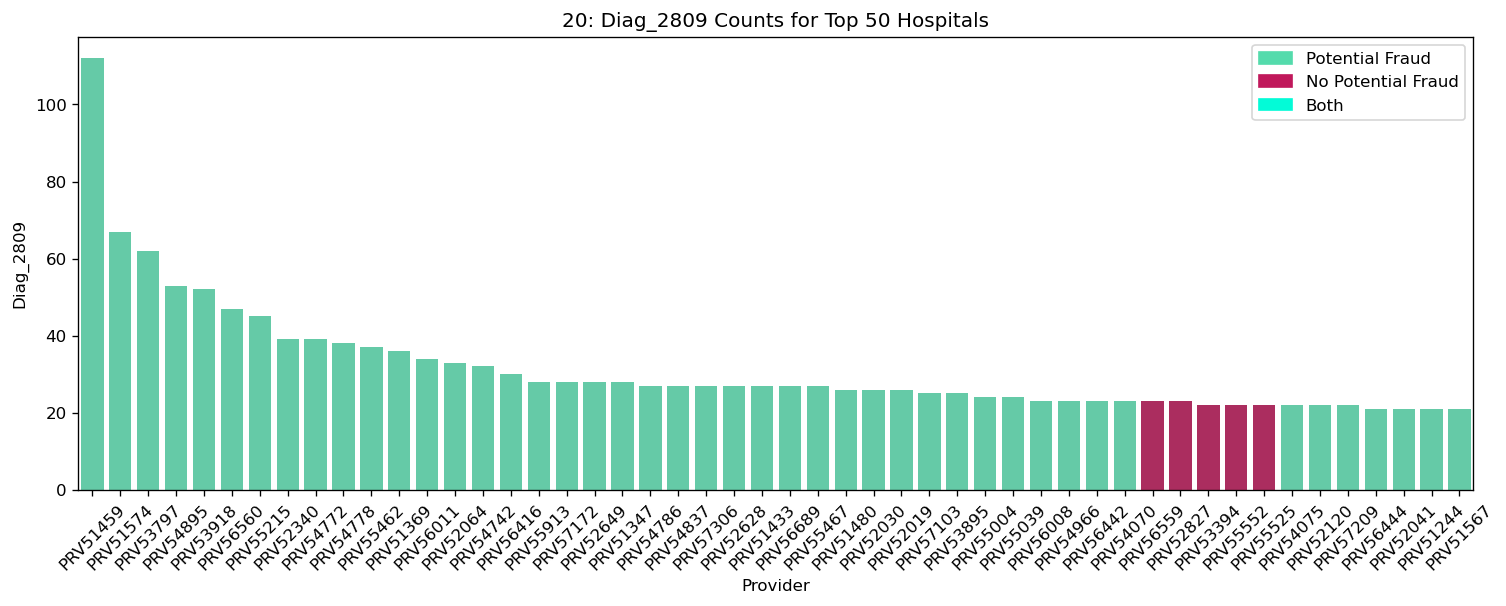

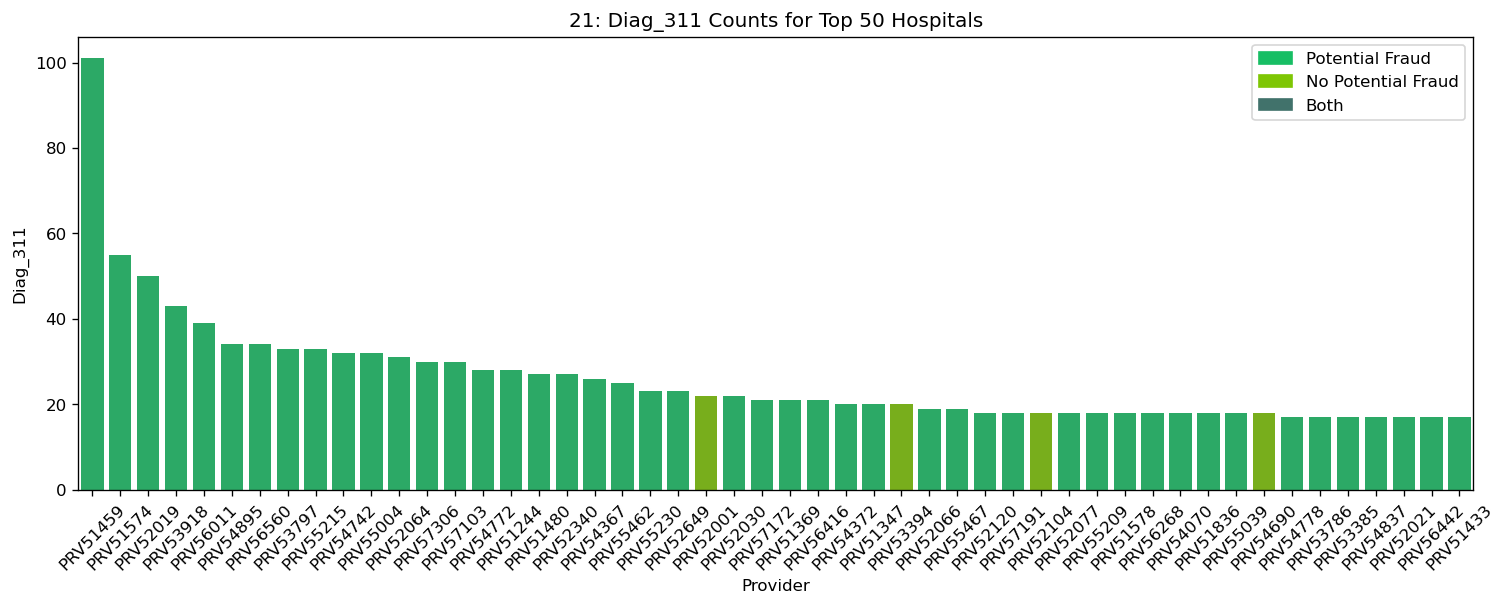

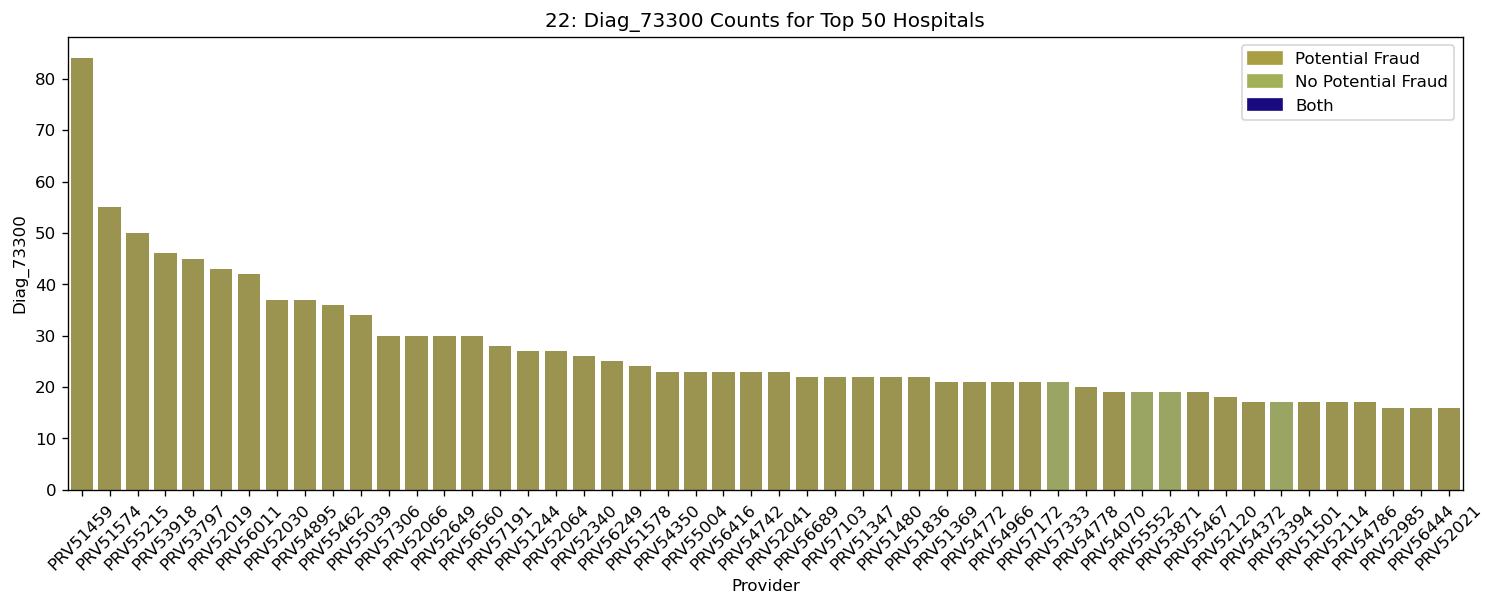

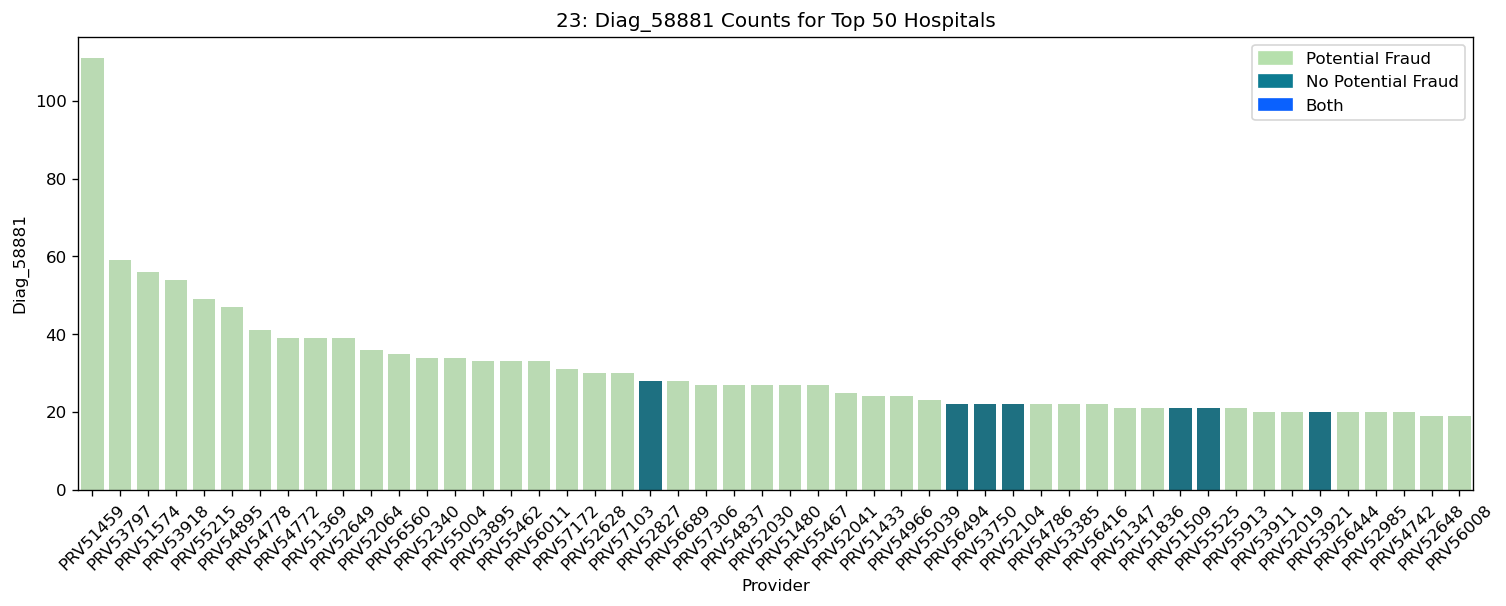

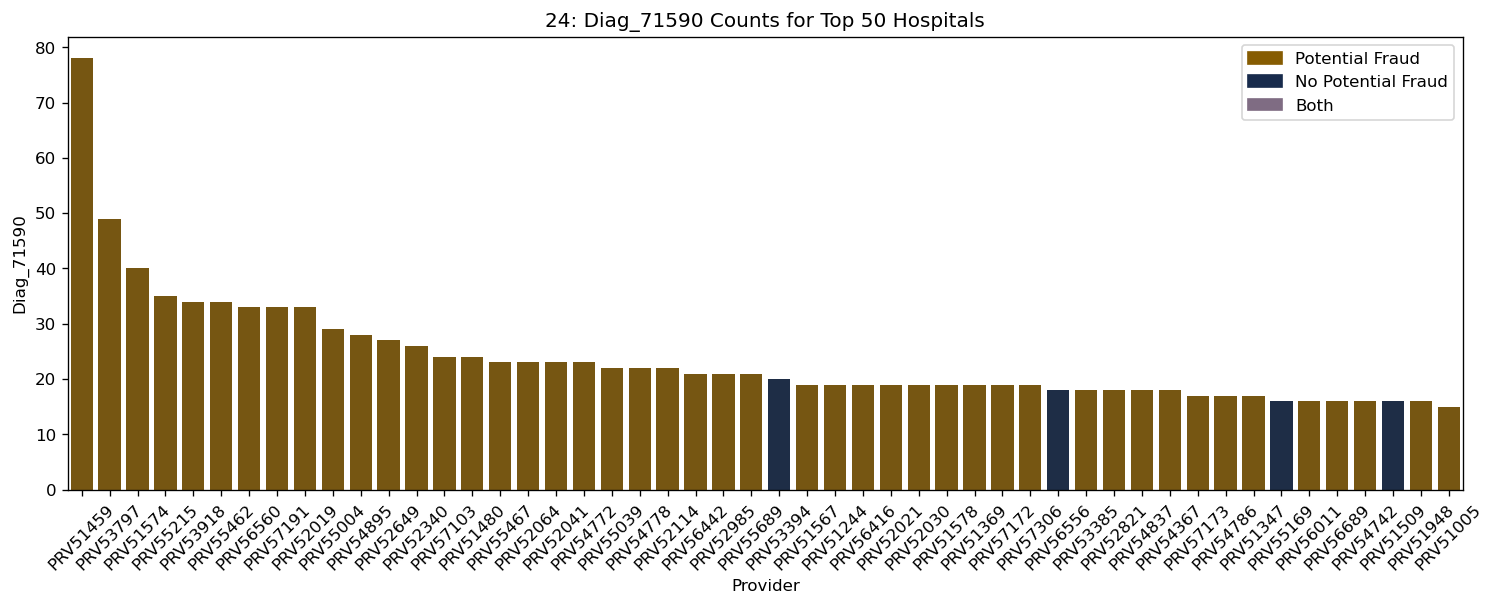

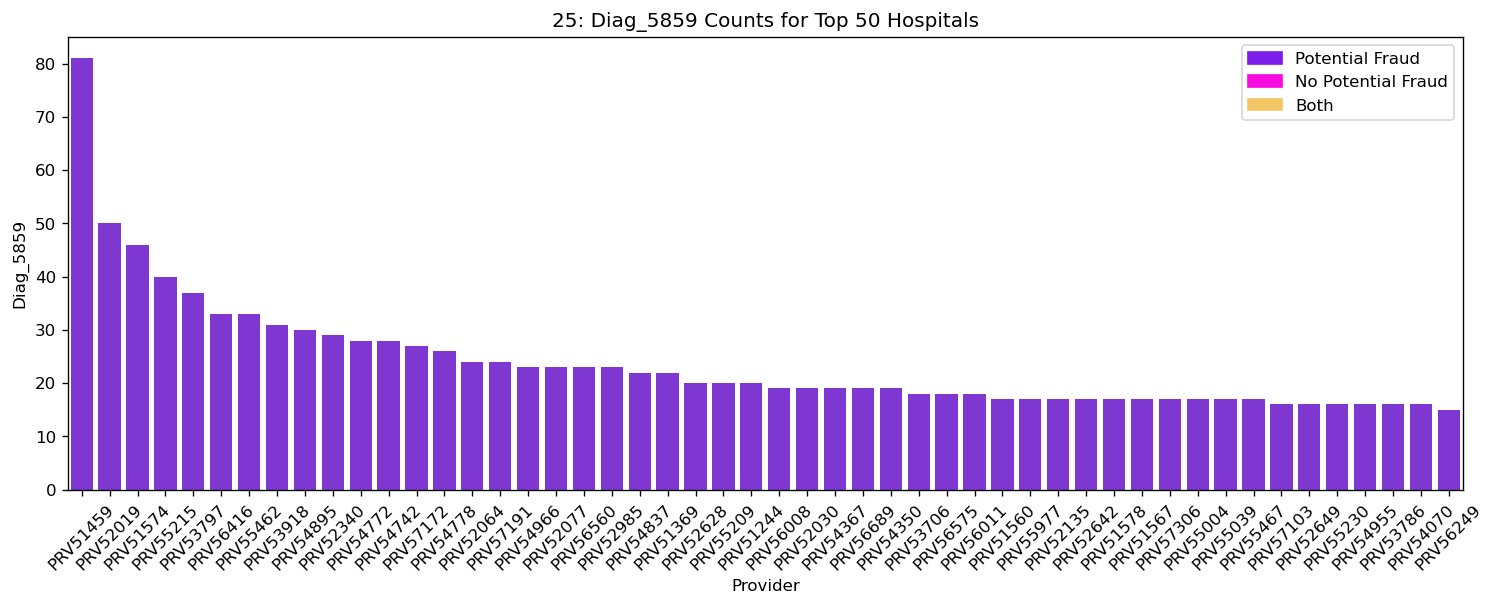

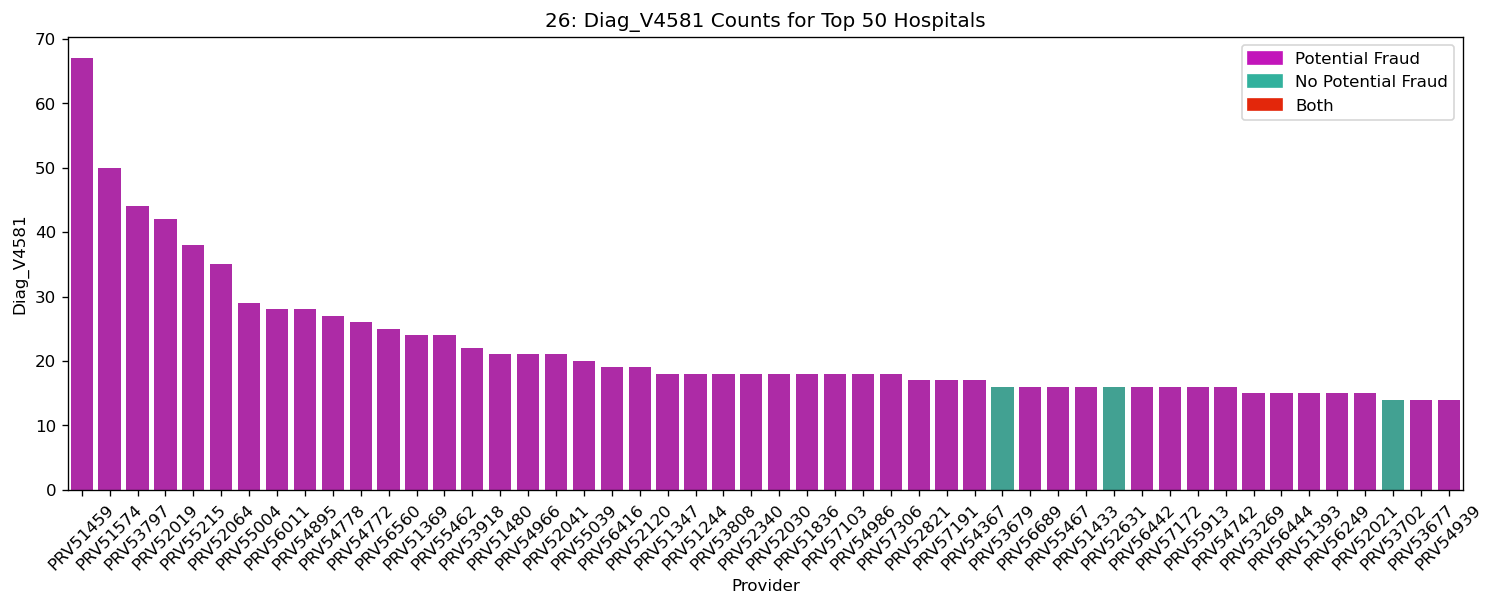

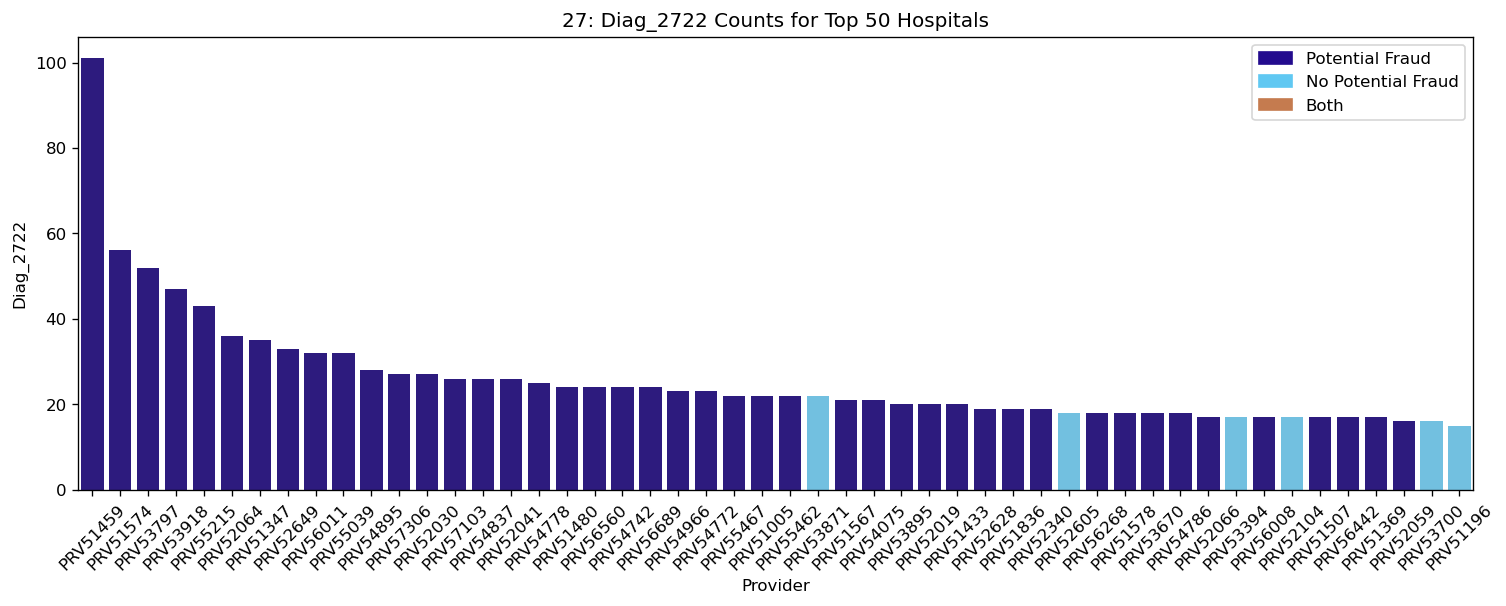

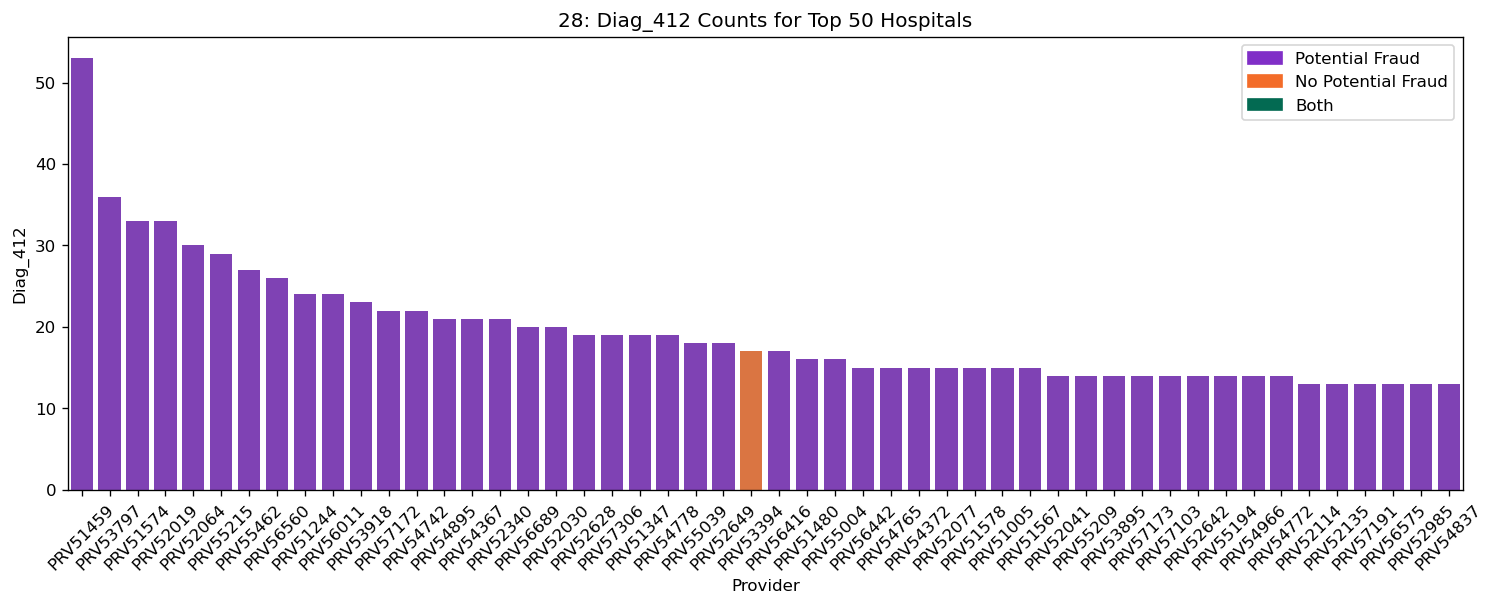

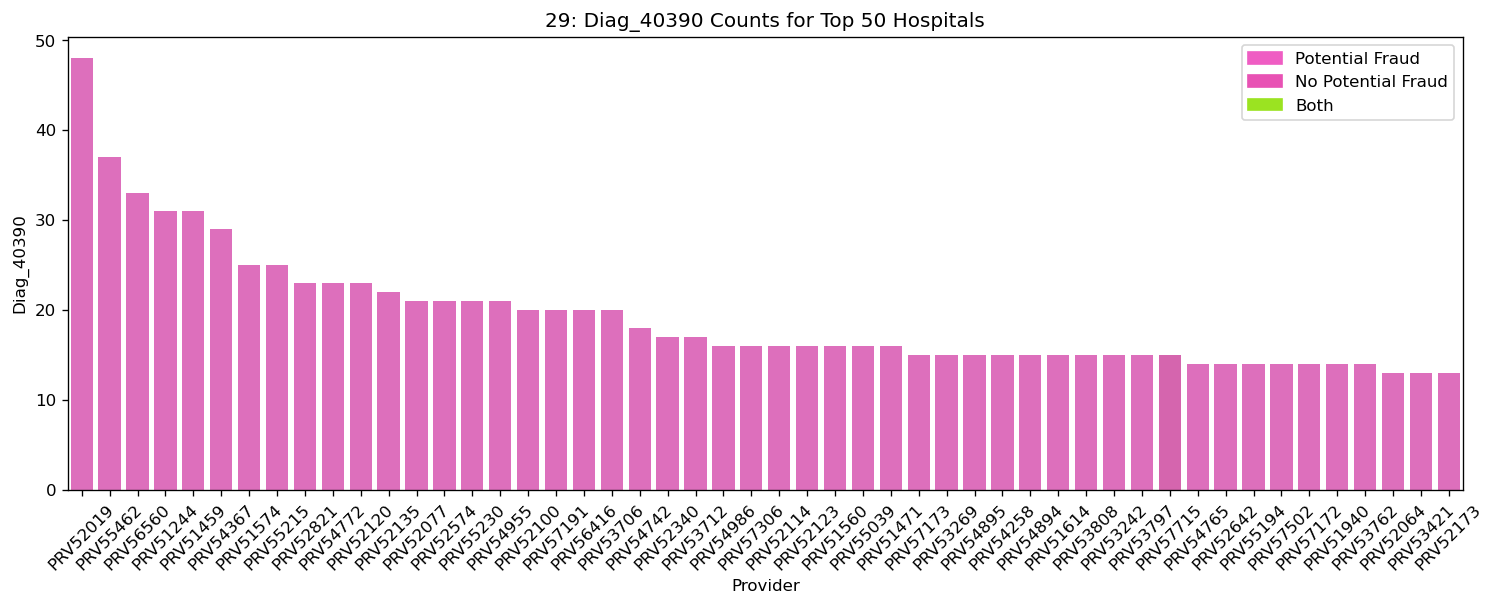

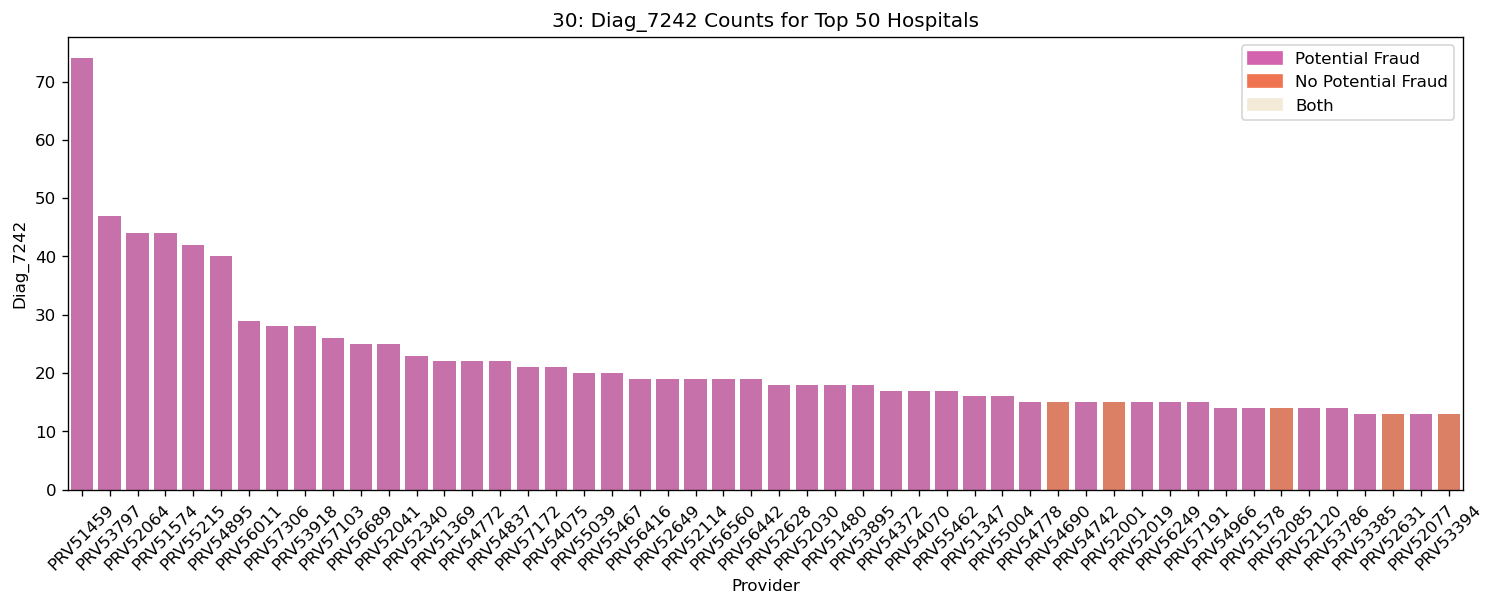

In [97]:
## plot most frequetly used diagnosis codes 
df=pd.DataFrame()
for c in diagnosiscodelist:
    l=df_diagnosis.isin([c]).sum(axis=1)
    df['Diag_'+c]=l
df=pd.concat([train[['Provider','PotentialFraud']], df], axis=1)
df=df.groupby(['Provider','PotentialFraud']).sum()
collist=df.columns
i=0
for c in collist:
    i=i+1
    df_code=df.reset_index().sort_values(by=c, ascending=False).head(50)
    bar_by_category(df_code, 'Provider', c, 'PotentialFraud', 
                title=str(i)+': '+ c+' Counts for Top 50 Hospitals')

In [129]:
pd.DataFrame(diagnosiscodelist, columns=['Diagnosis Code'])[:15]

Diagnosis Code
0            4019
1           25000
2            2724
3           V5869
4            4011
5           42731
6           V5861
7            2720
8            2449
9            4280
10          53081
11          41401
12            496
13           2859
14          41400

In [130]:
pd.DataFrame(procedurecodelist, columns=['Procedure Code'])[:15]

Procedure Code
0           4019.0
1           9904.0
2           2724.0
3           8154.0
4             66.0
5           3893.0
6           3995.0
7           4516.0
8           3722.0
9           8151.0
10          8872.0
11          9671.0
12          4513.0
13          9390.0
14          9672.0

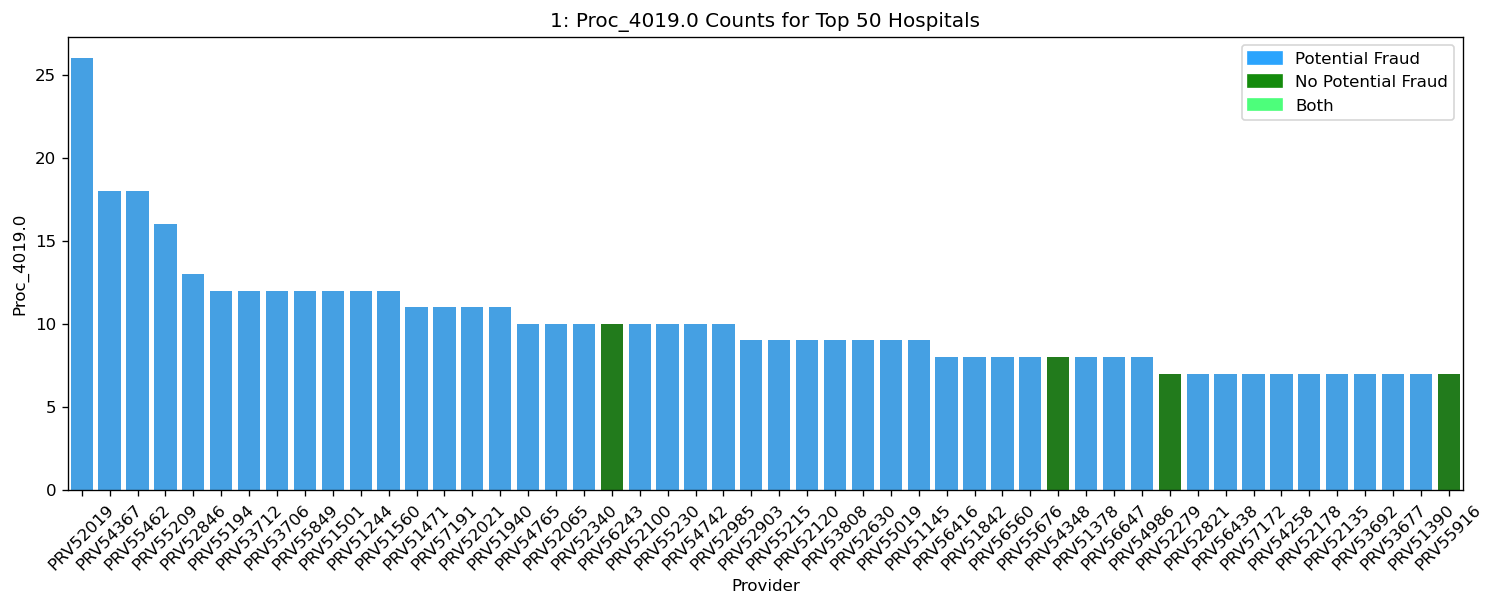

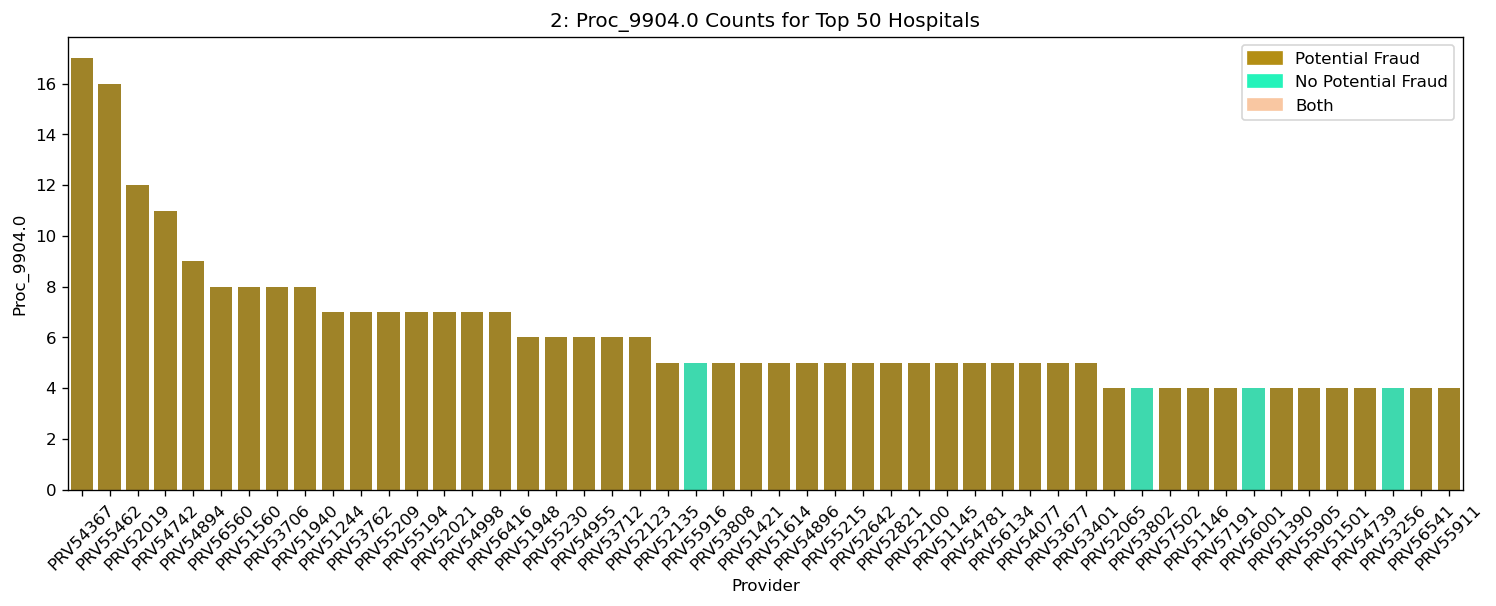

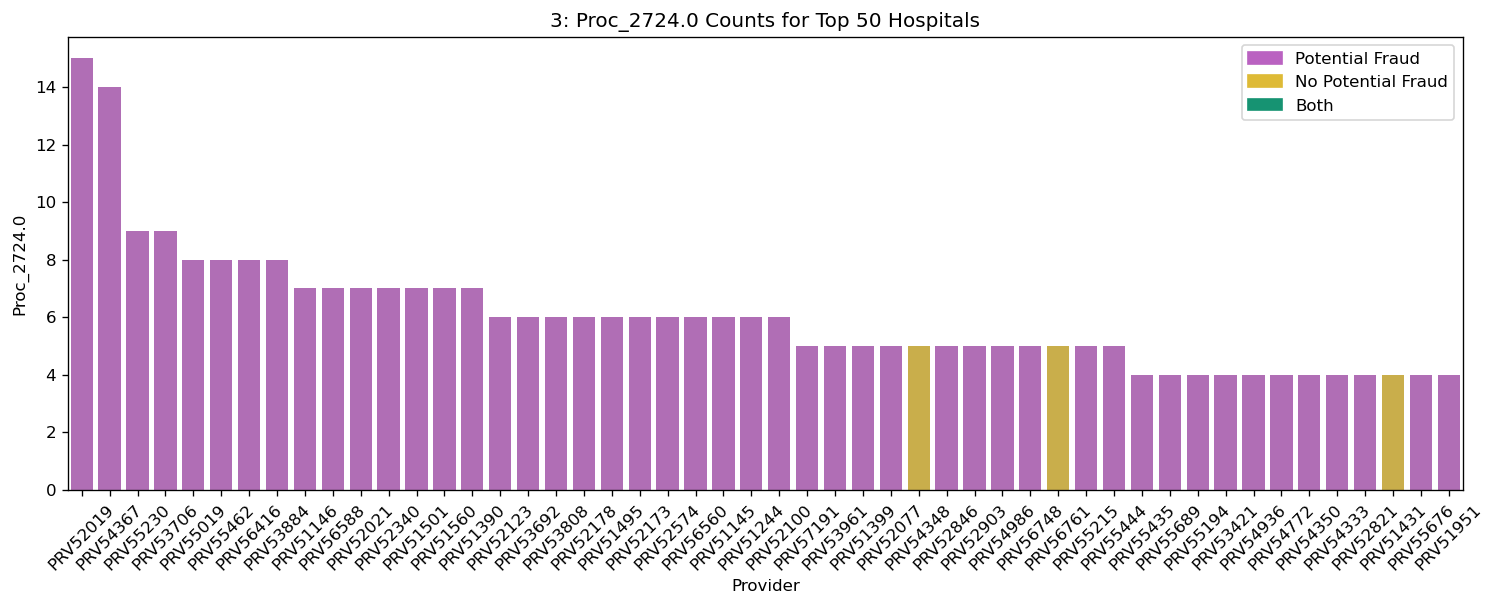

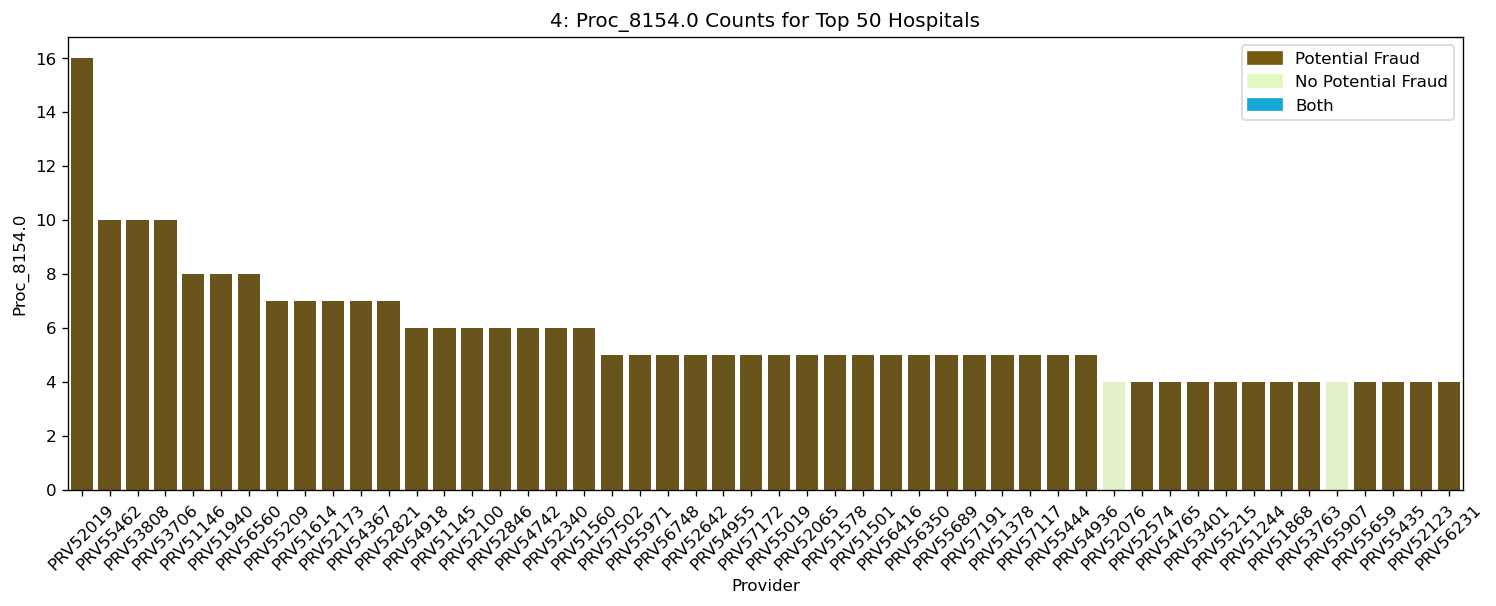

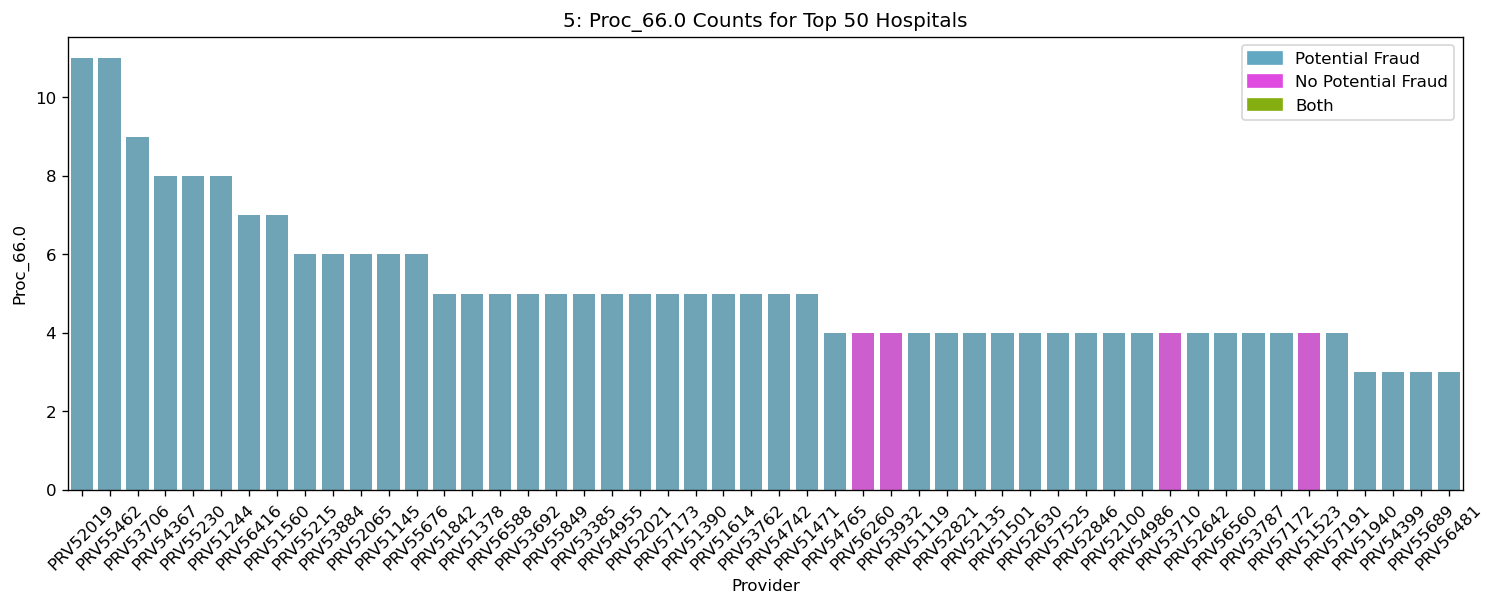

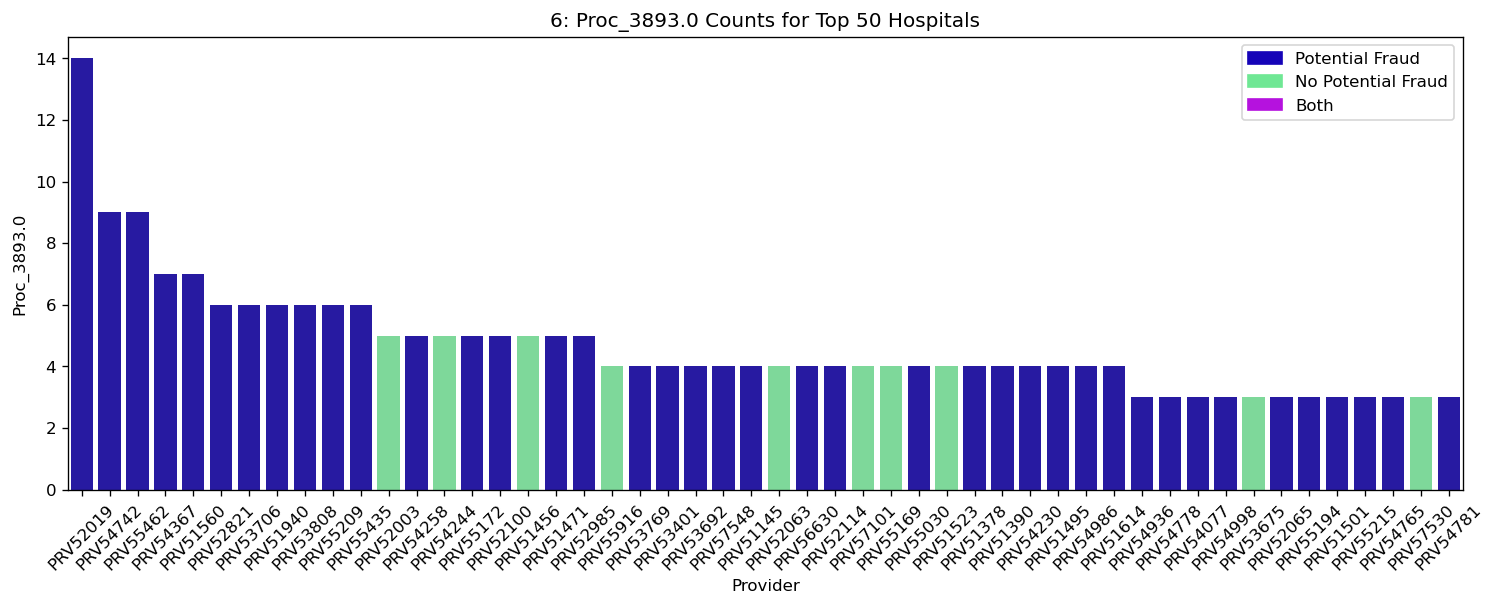

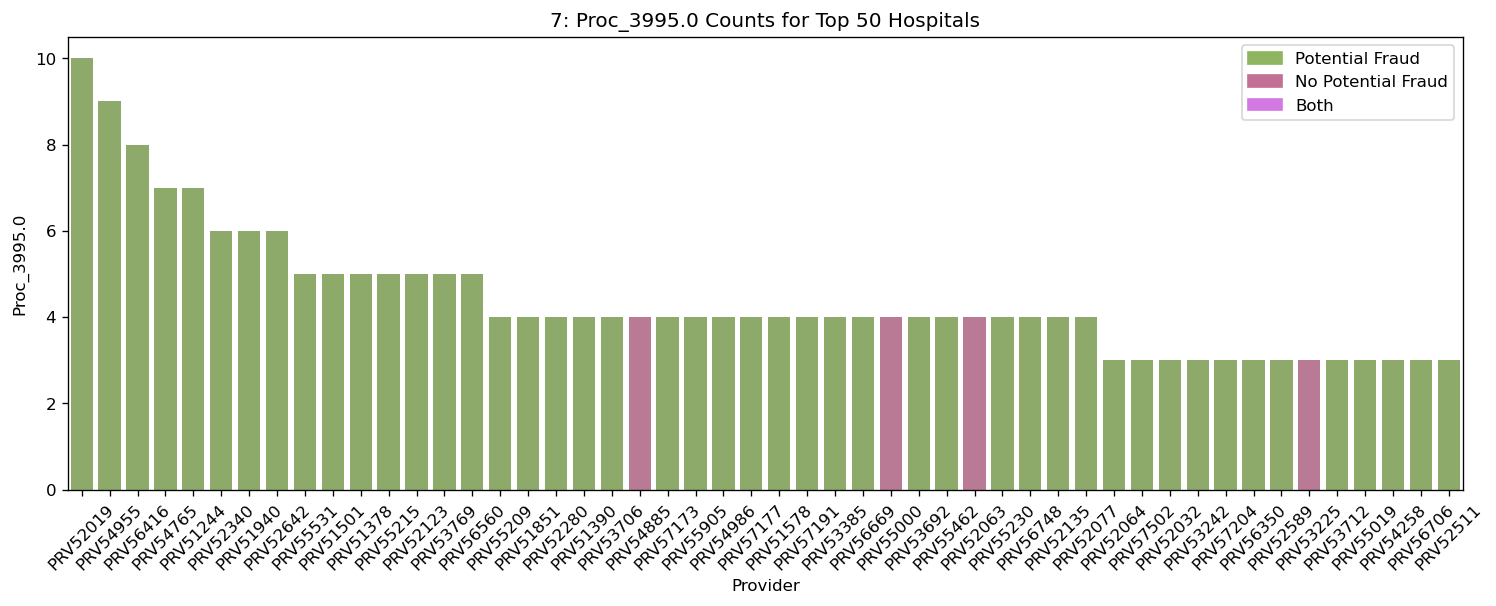

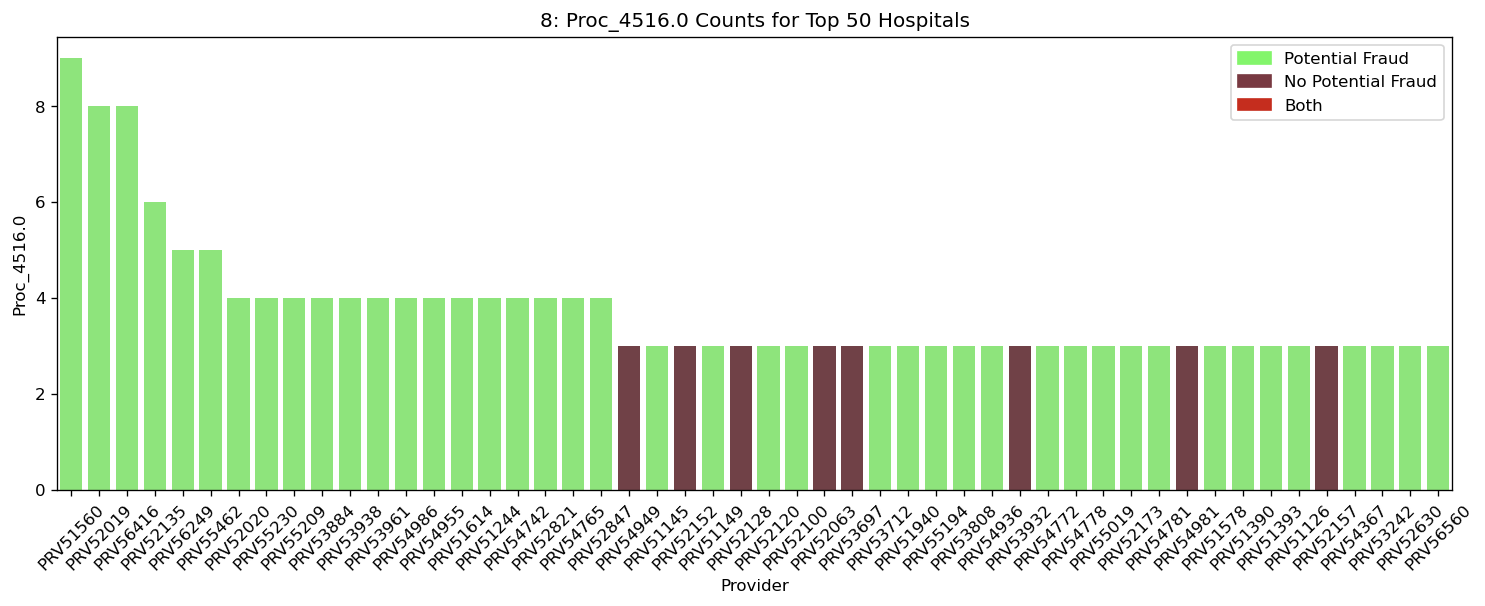

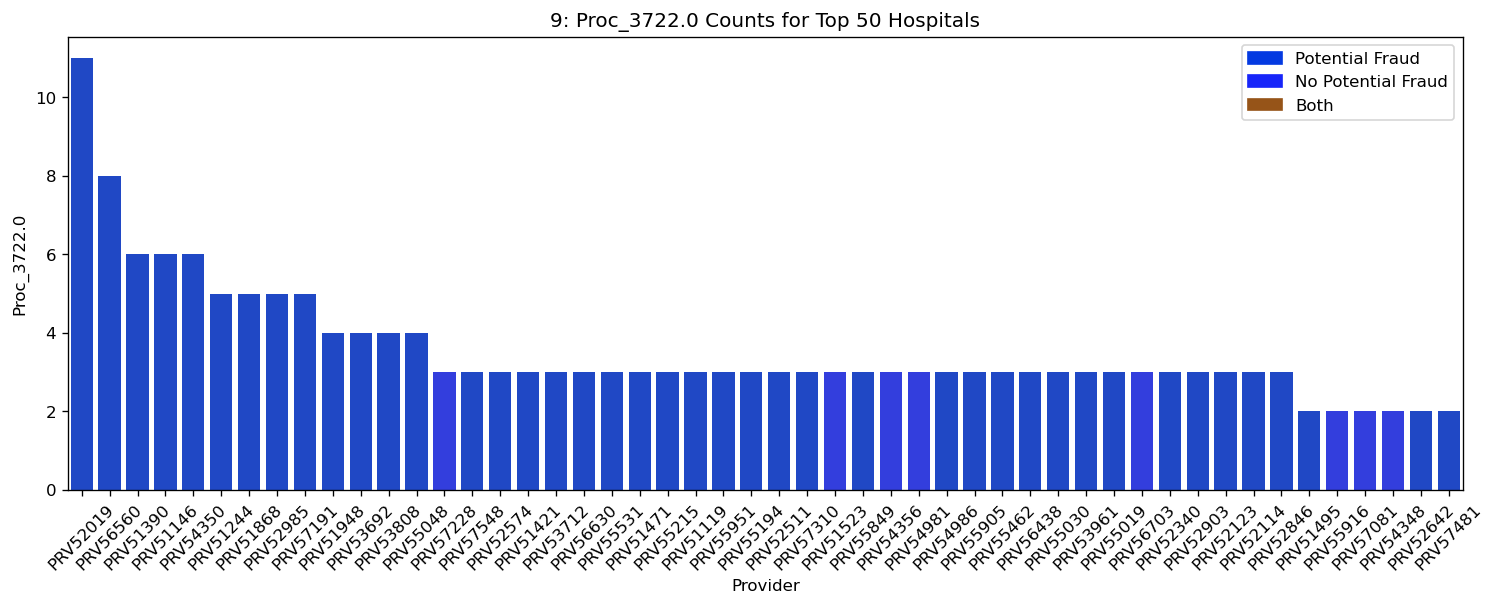

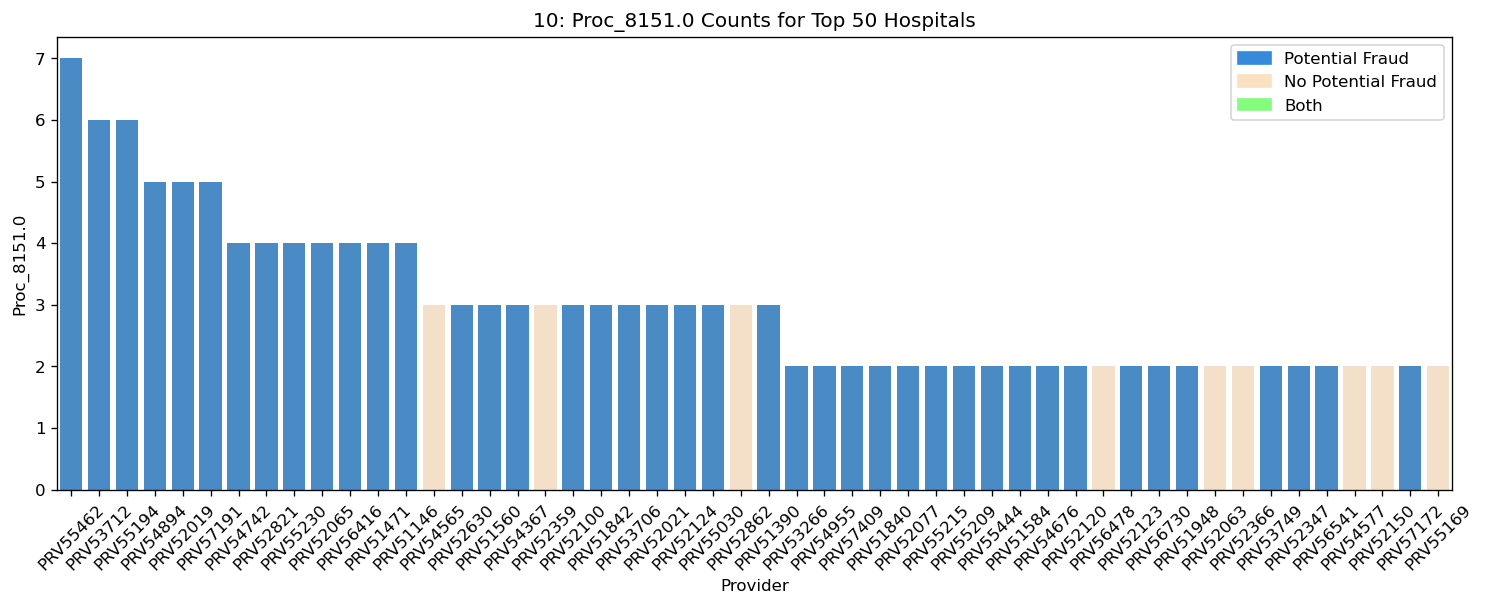

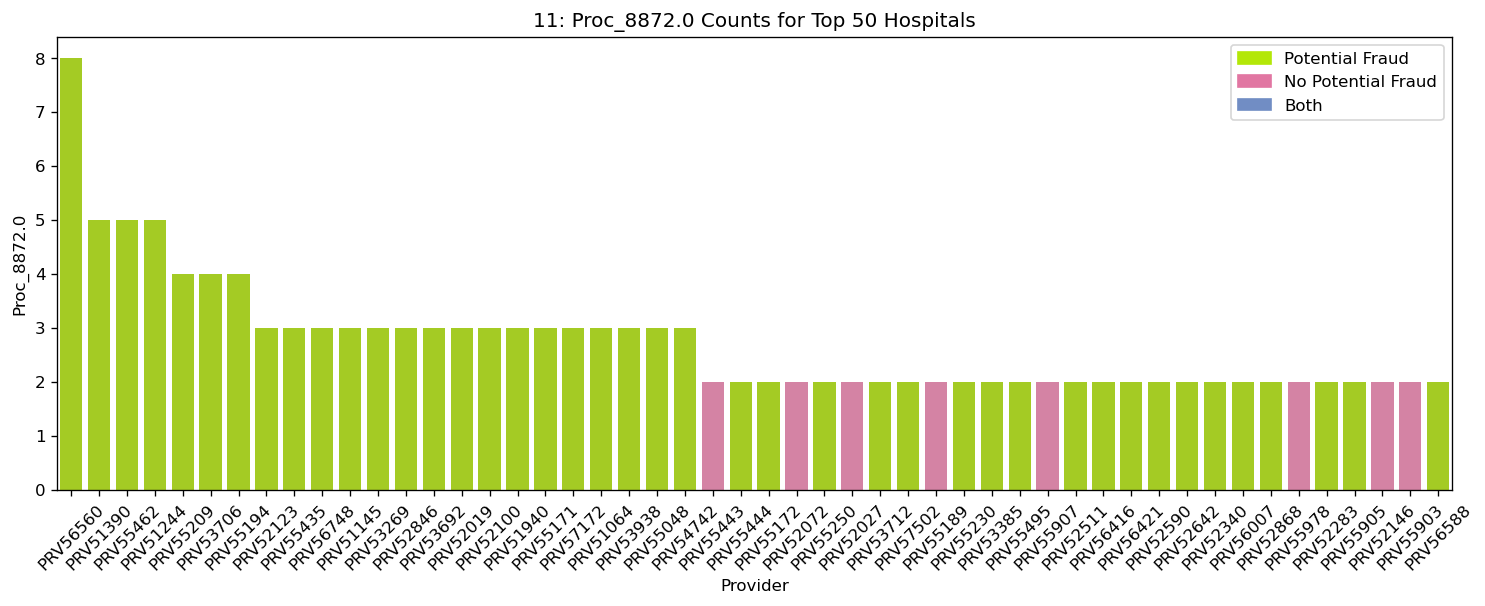

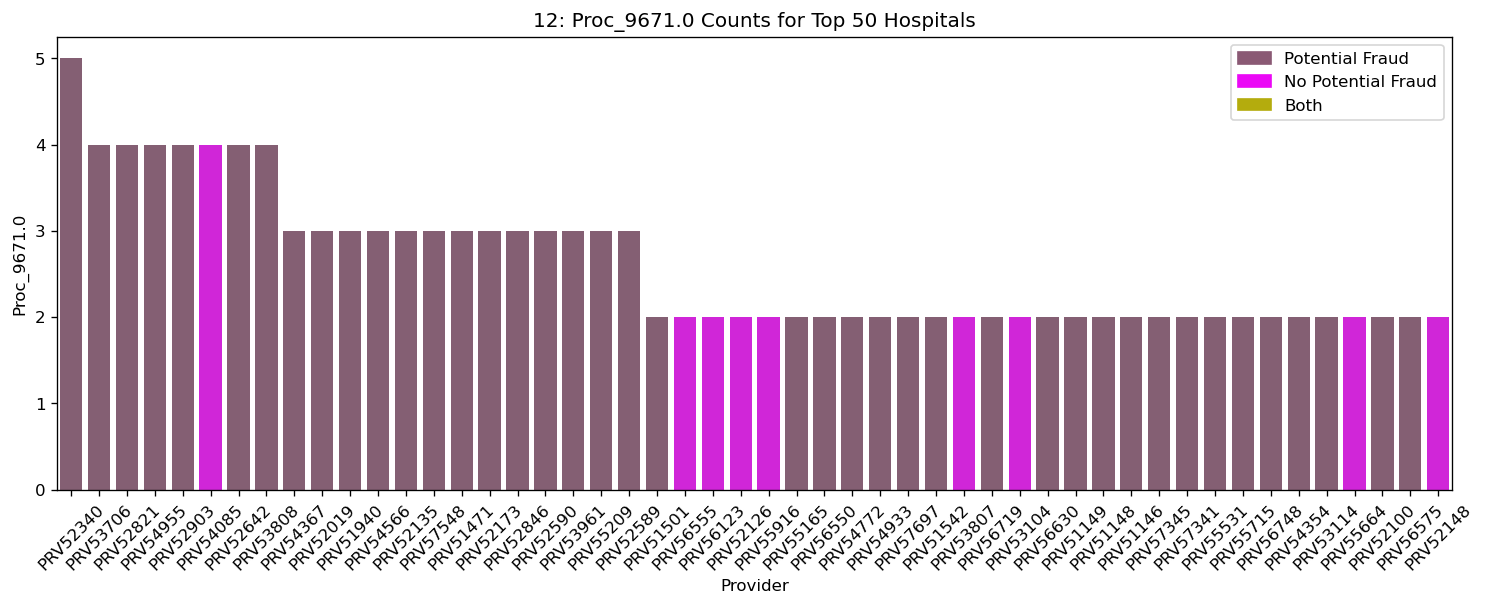

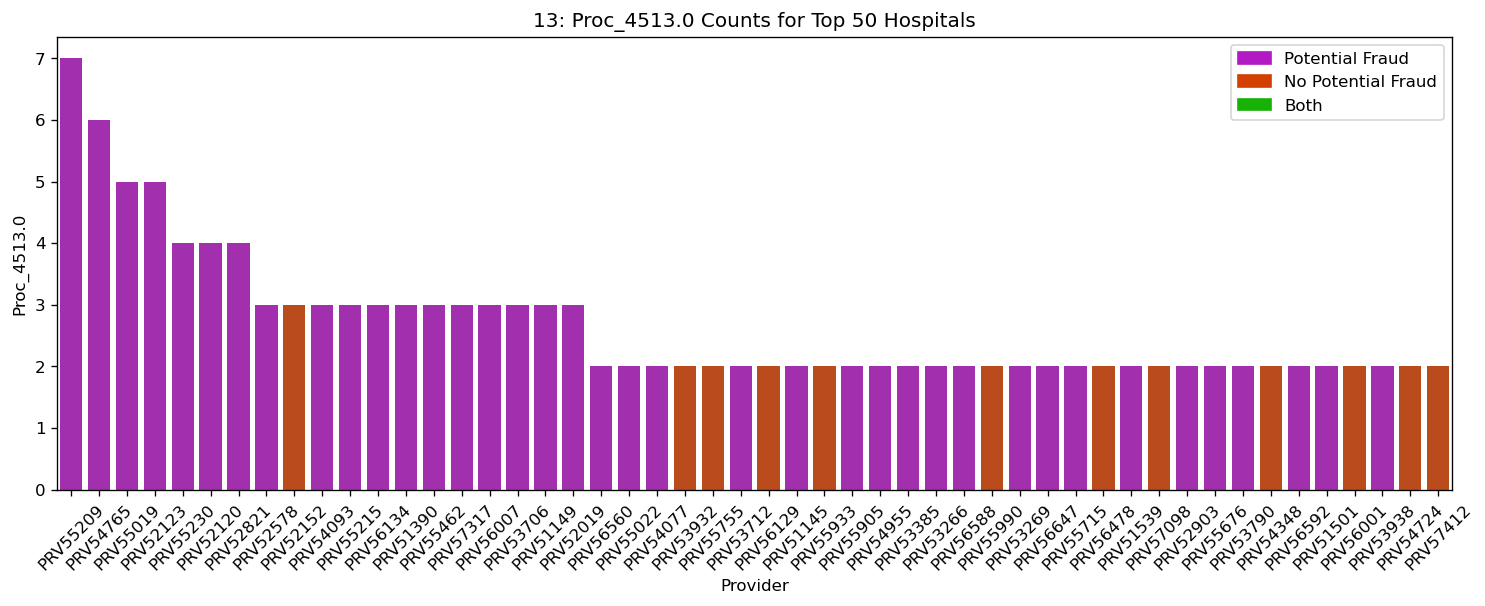

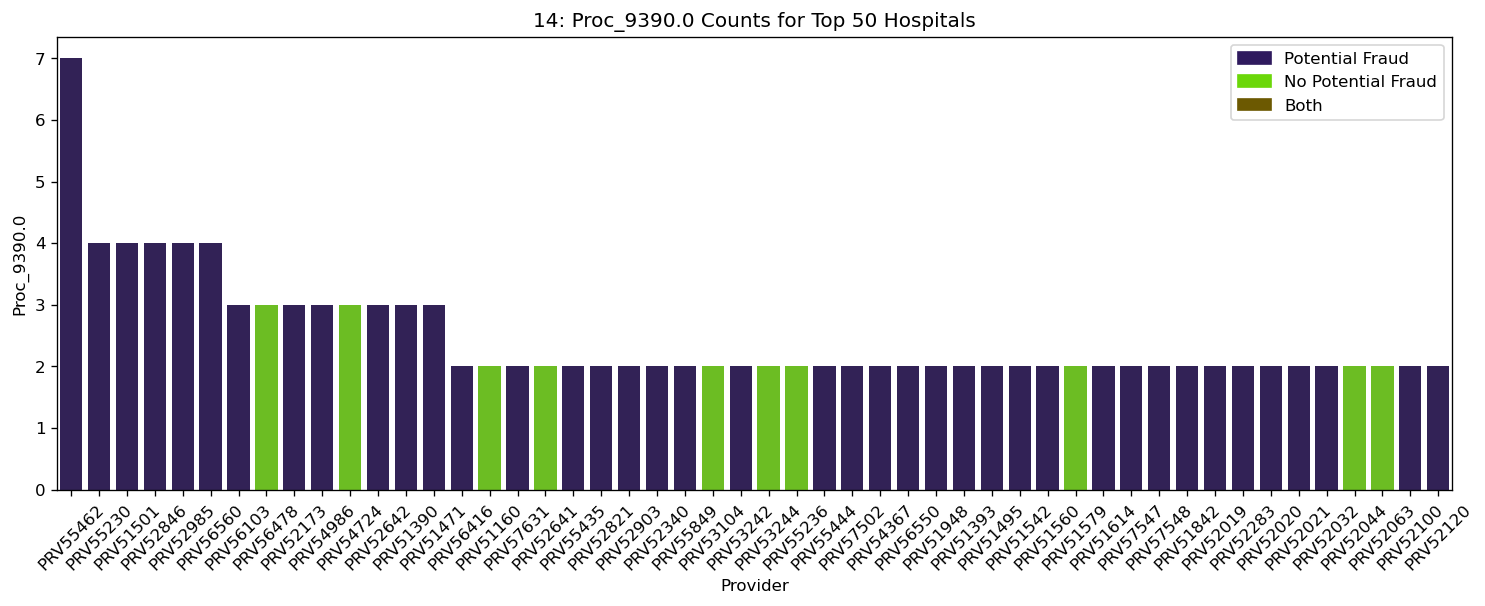

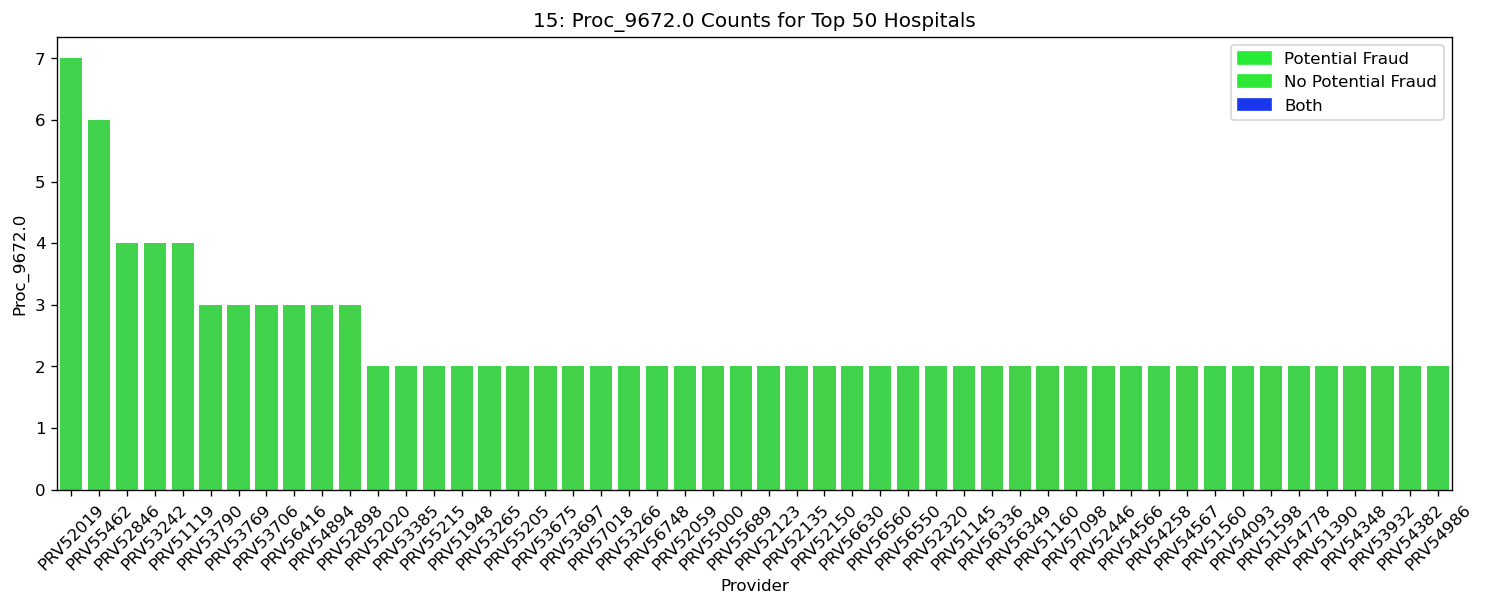

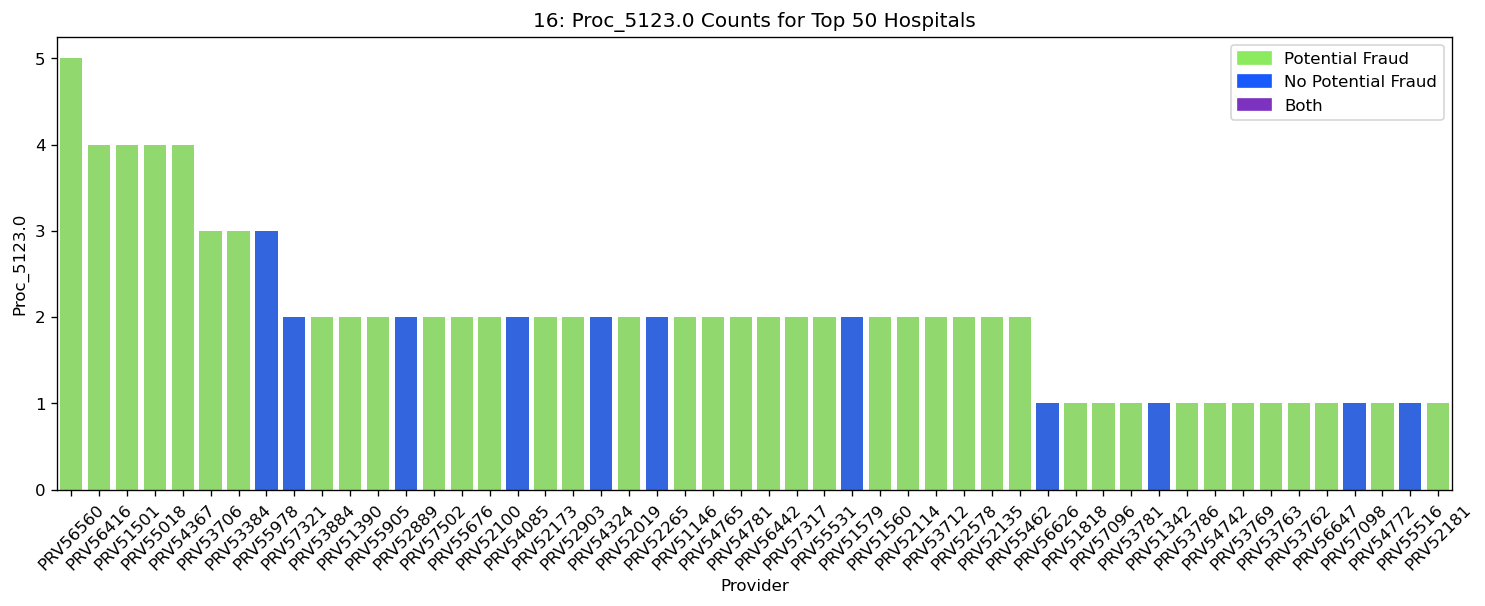

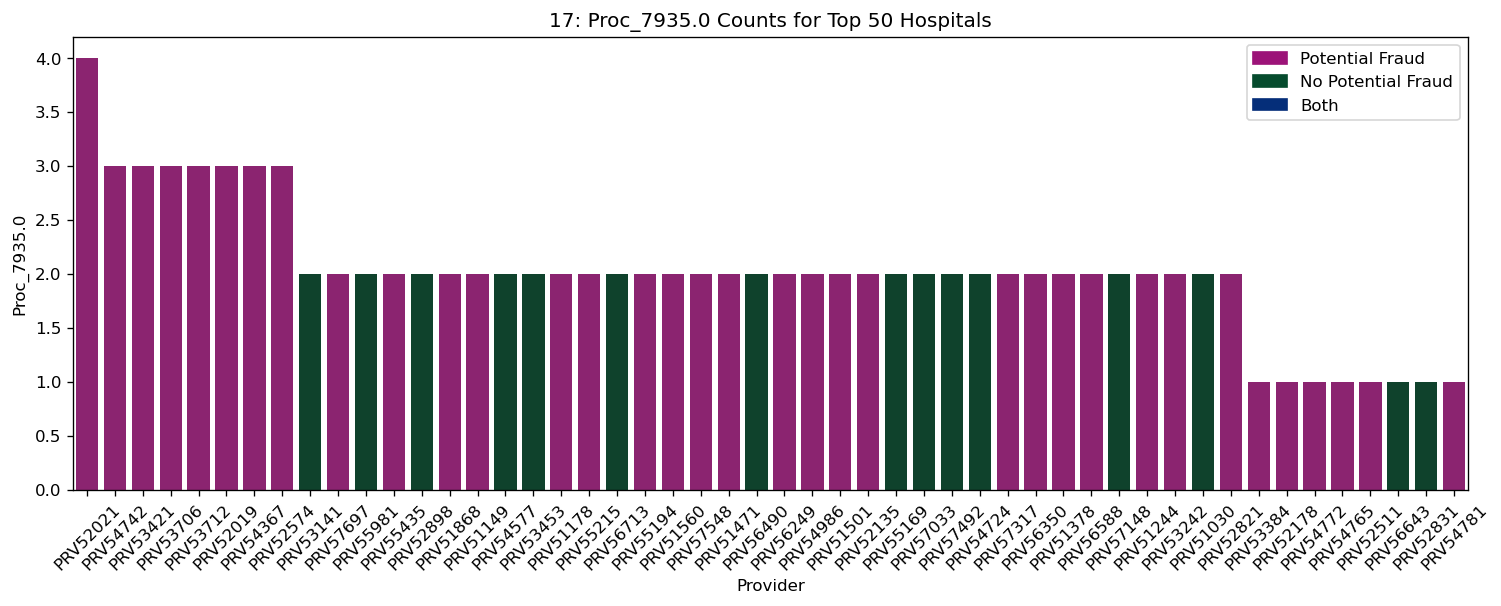

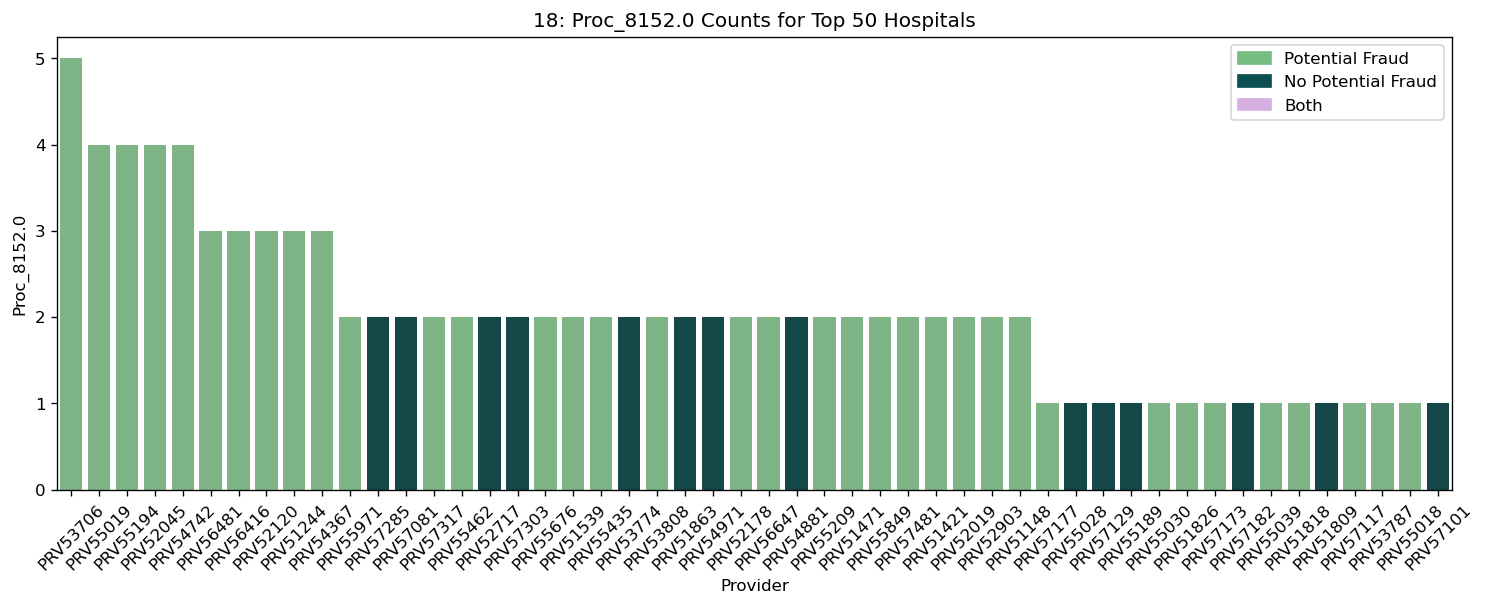

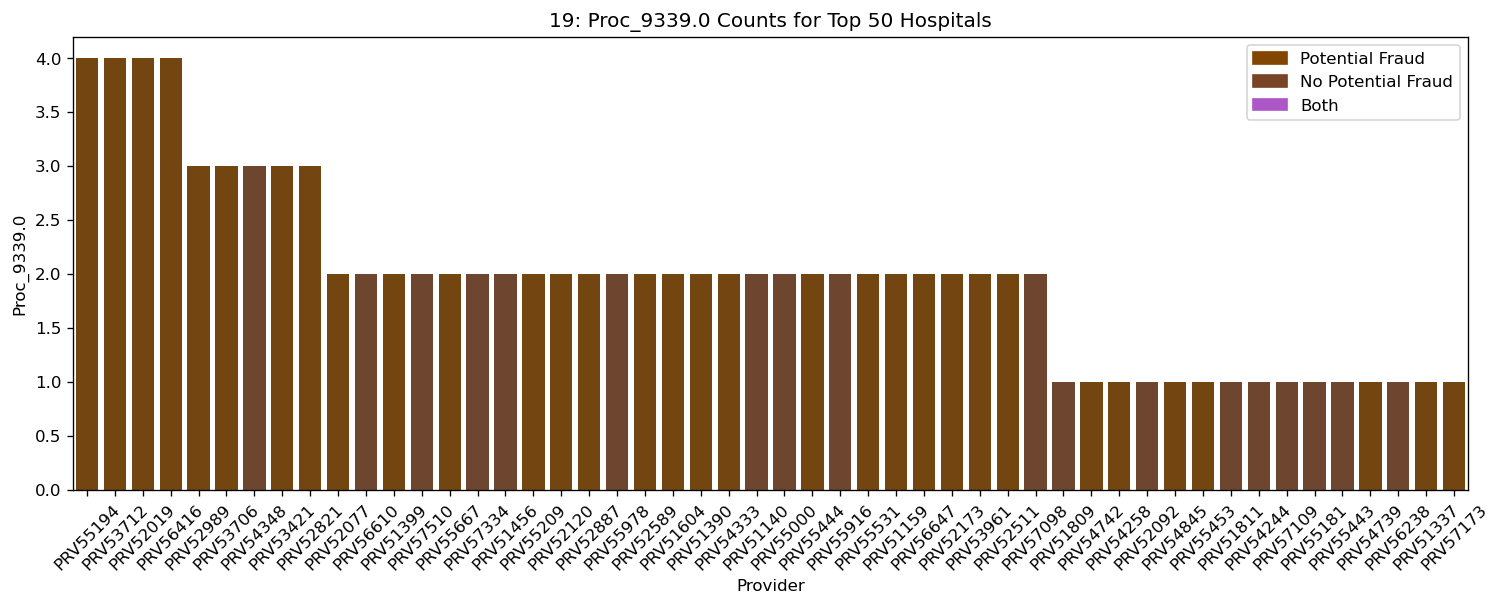

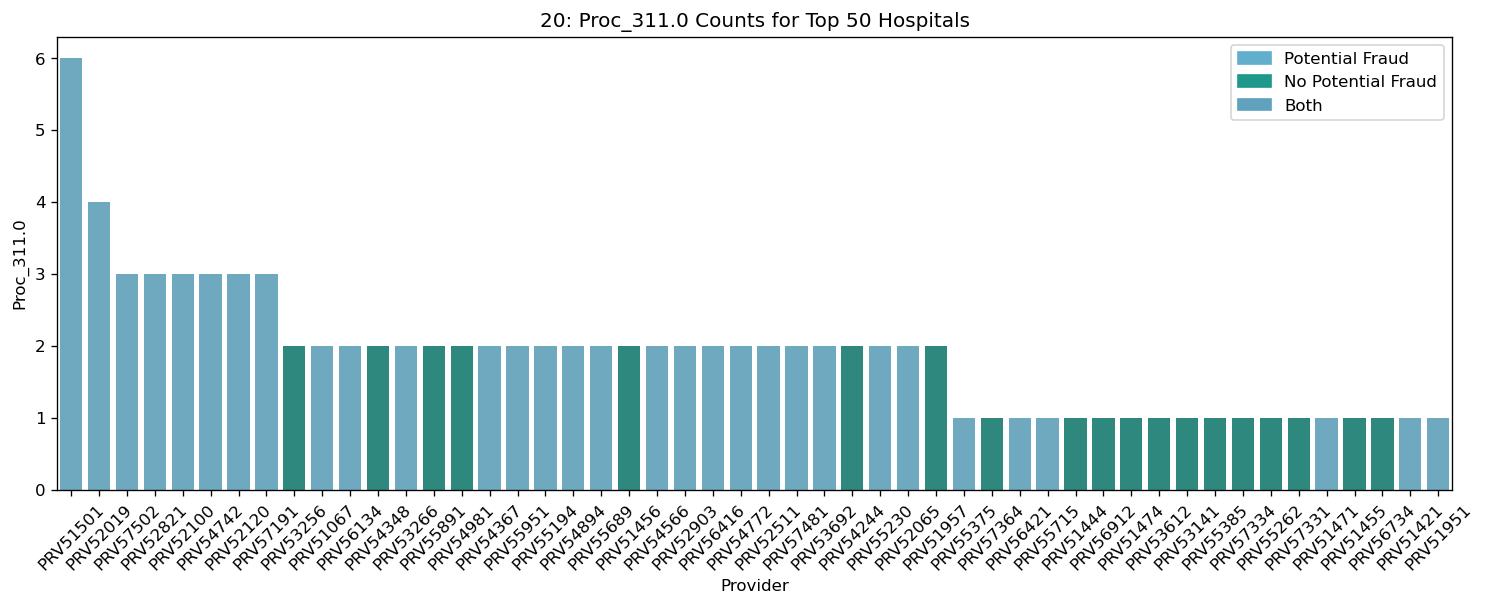

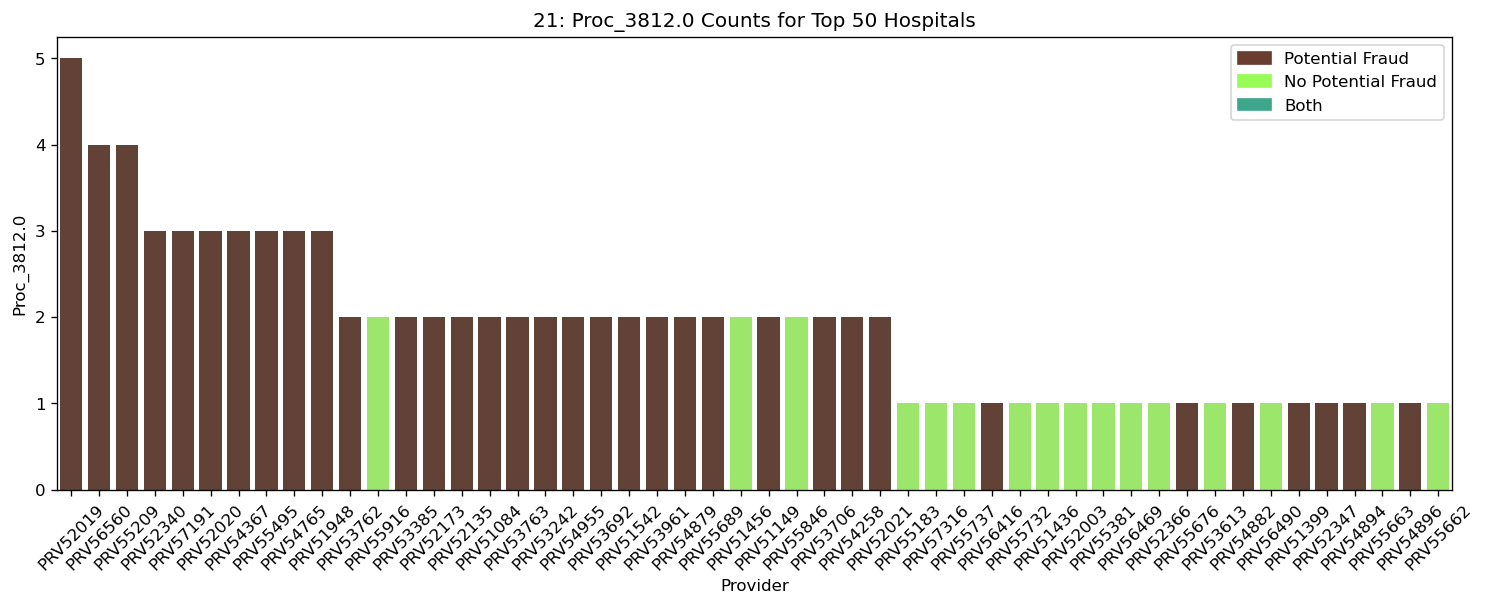

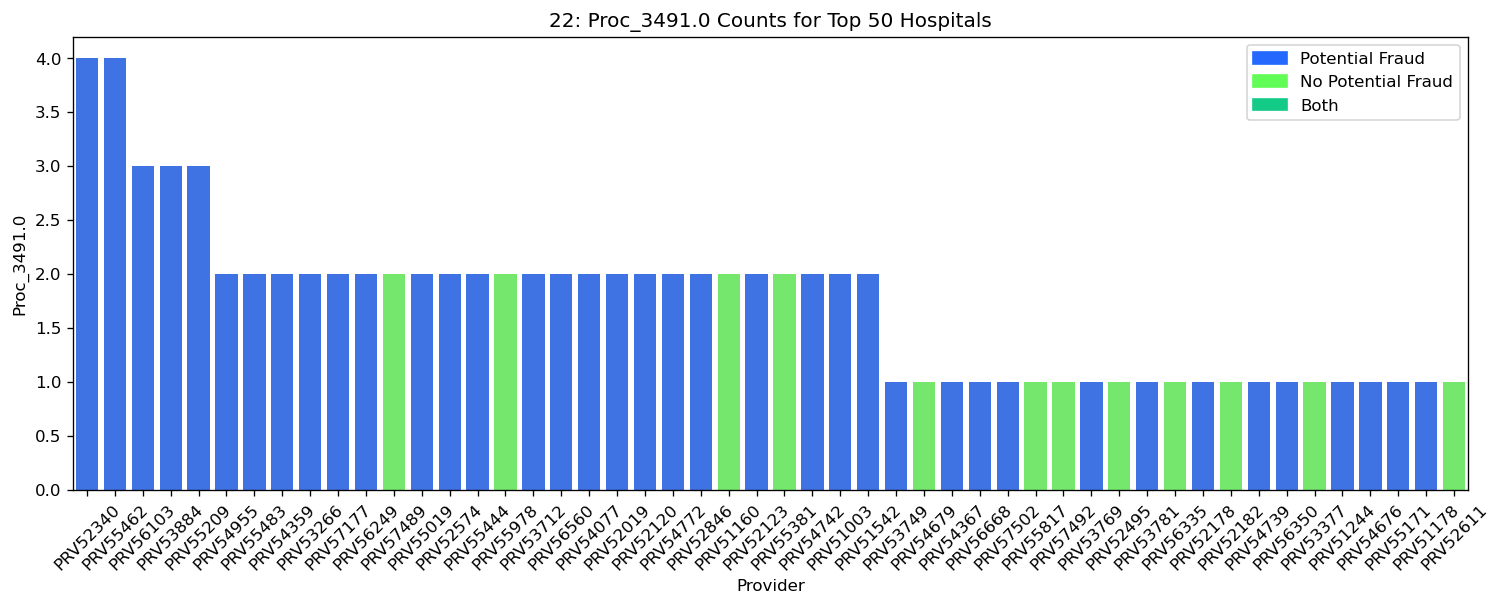

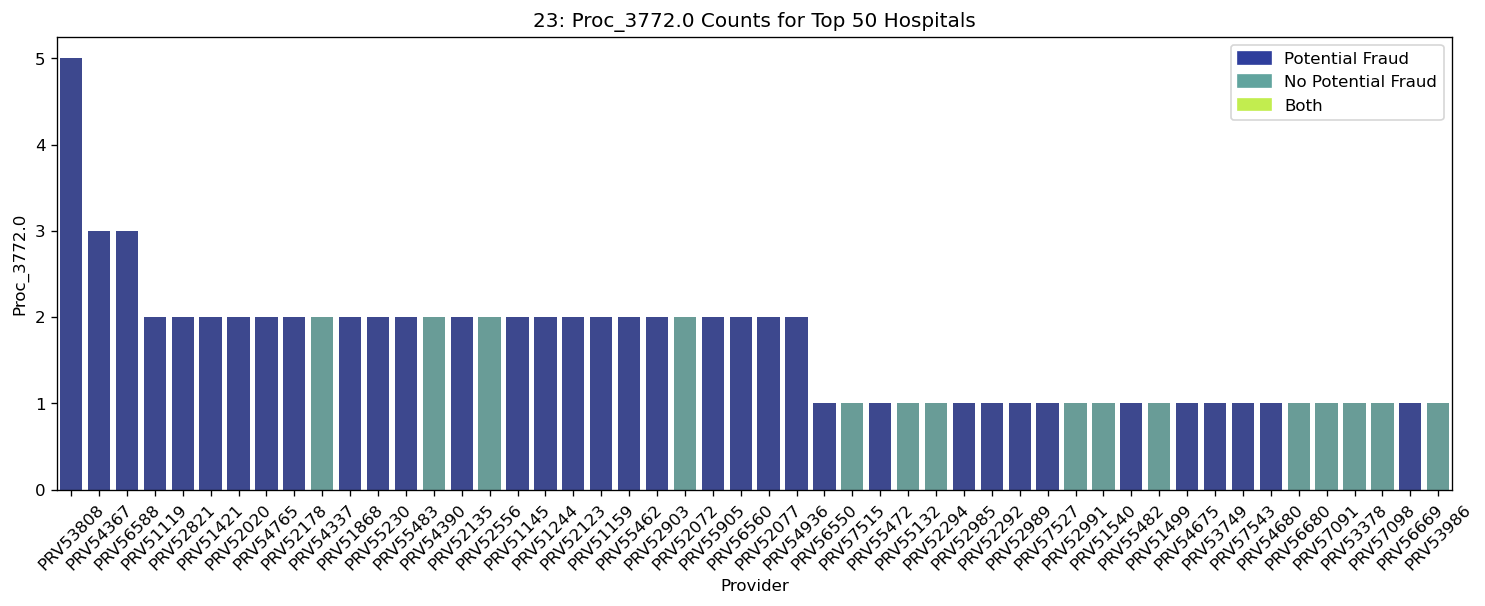

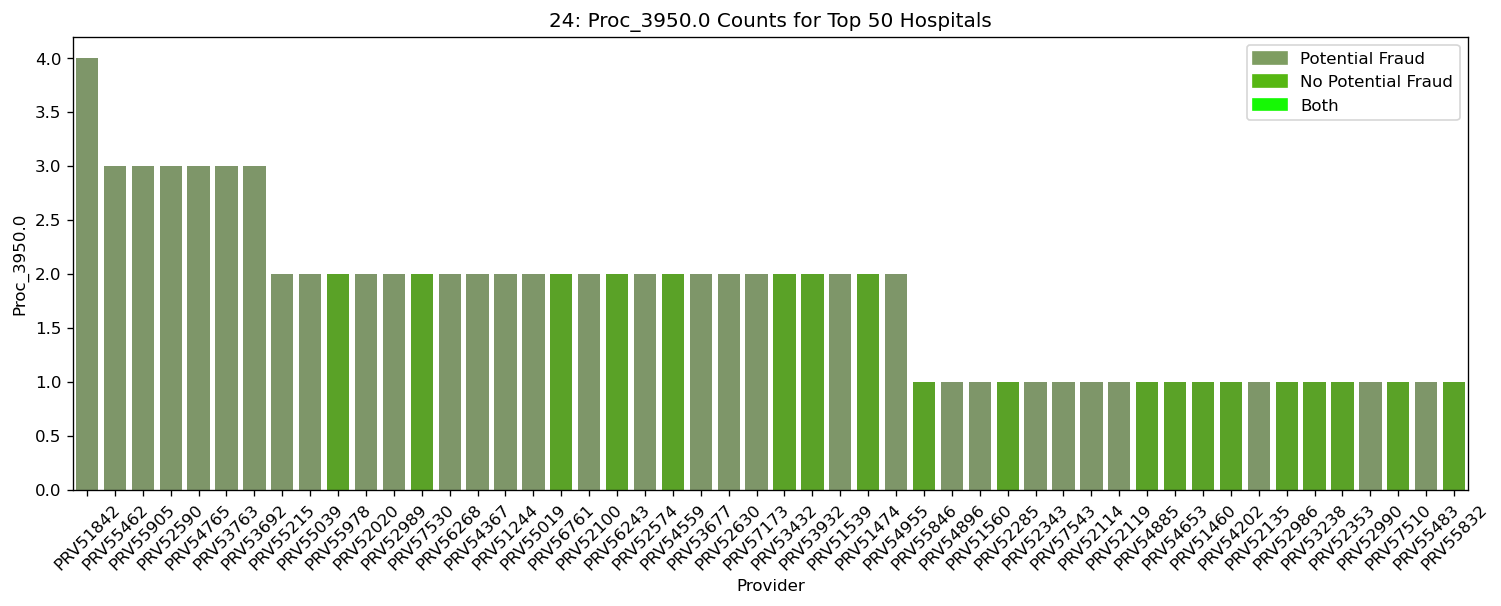

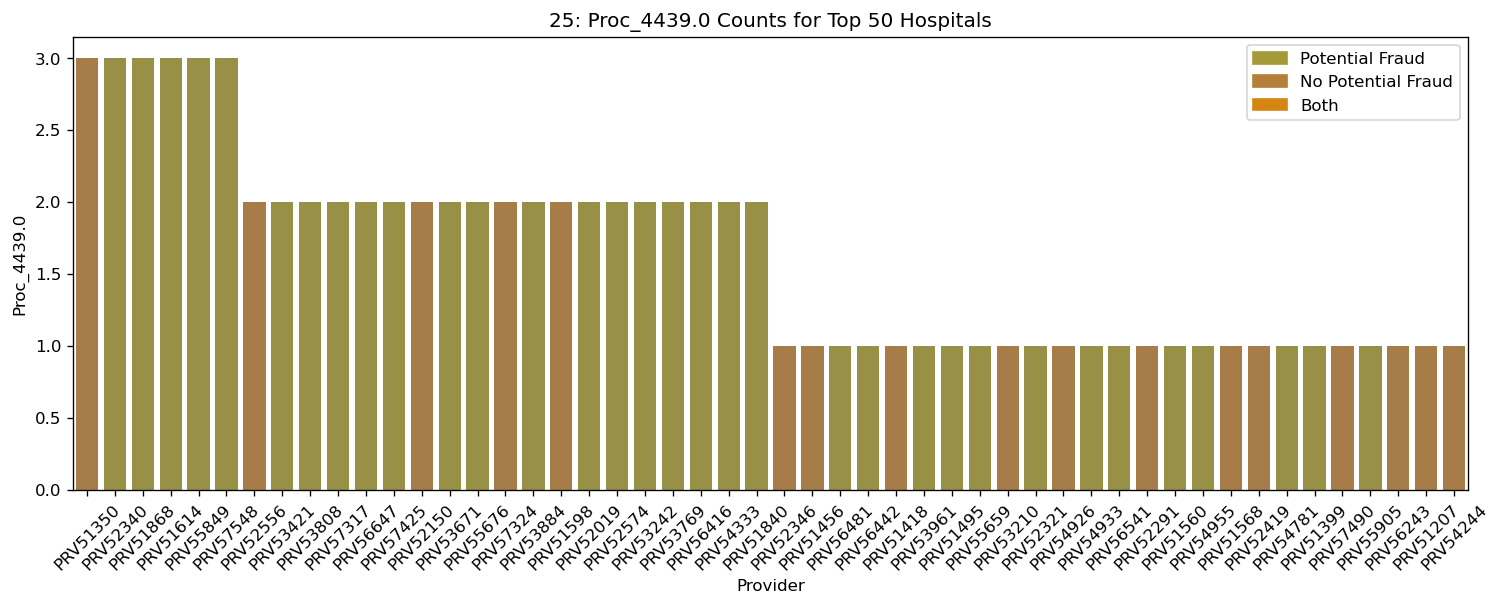

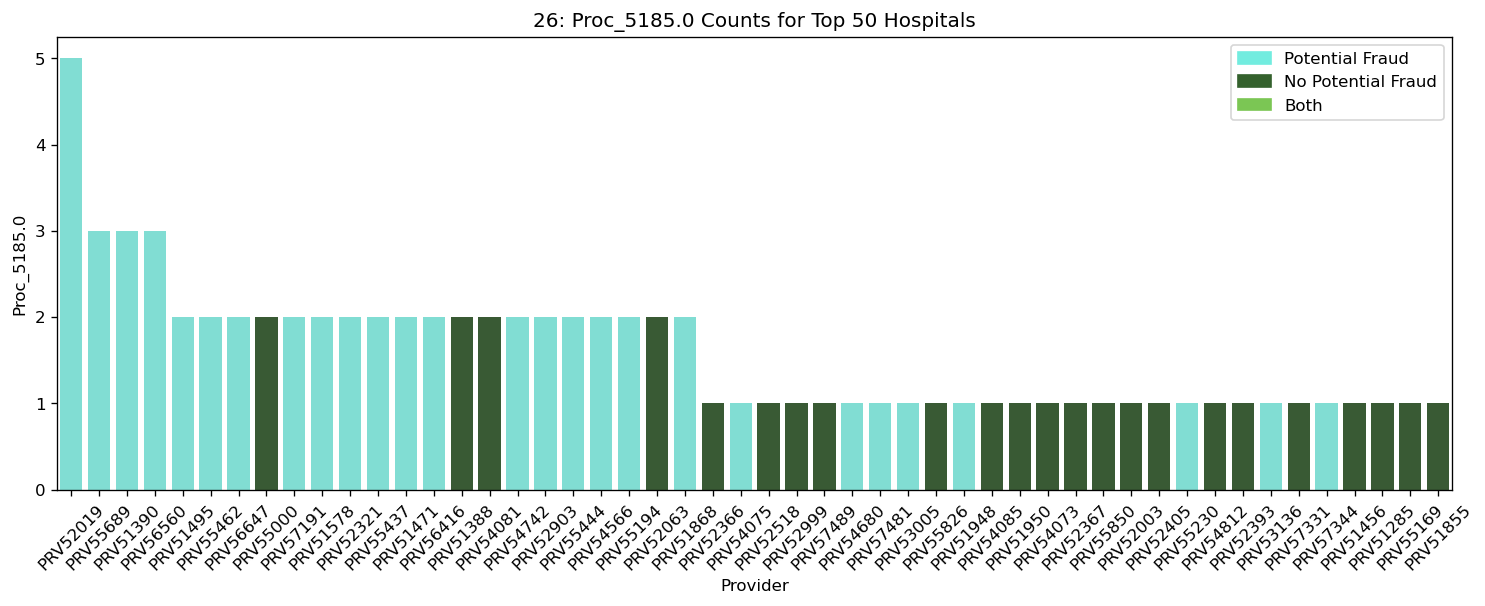

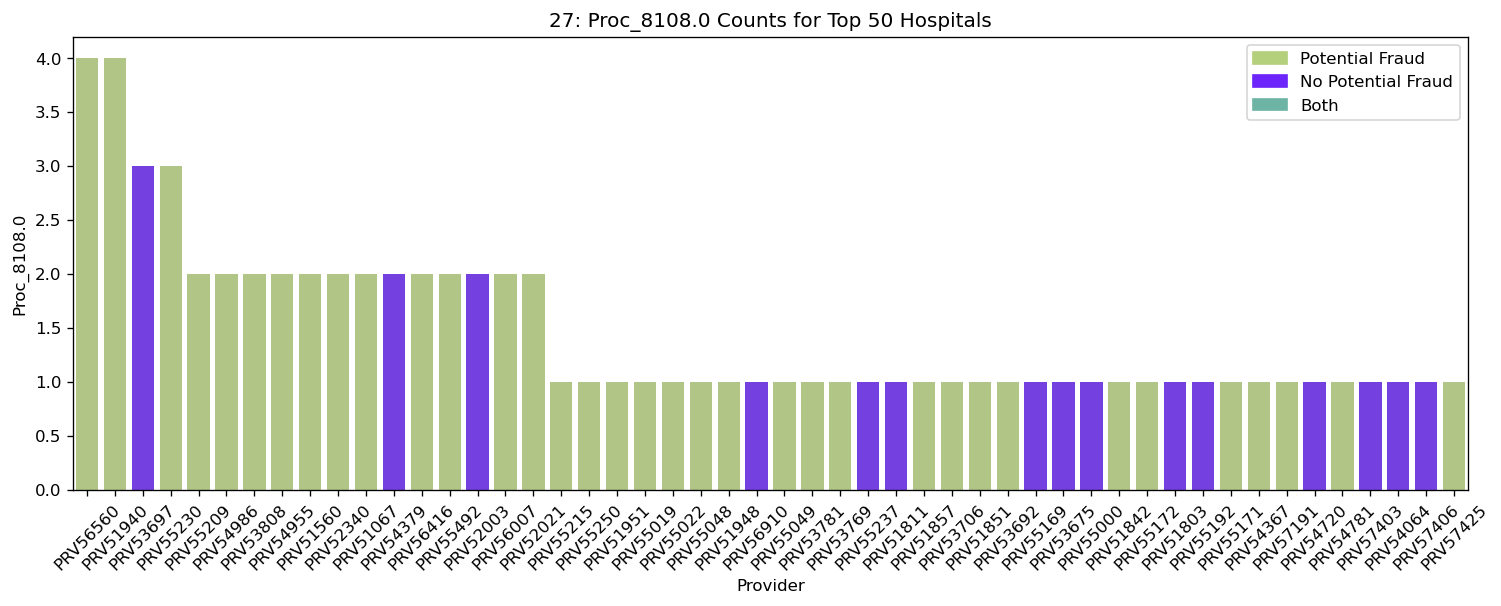

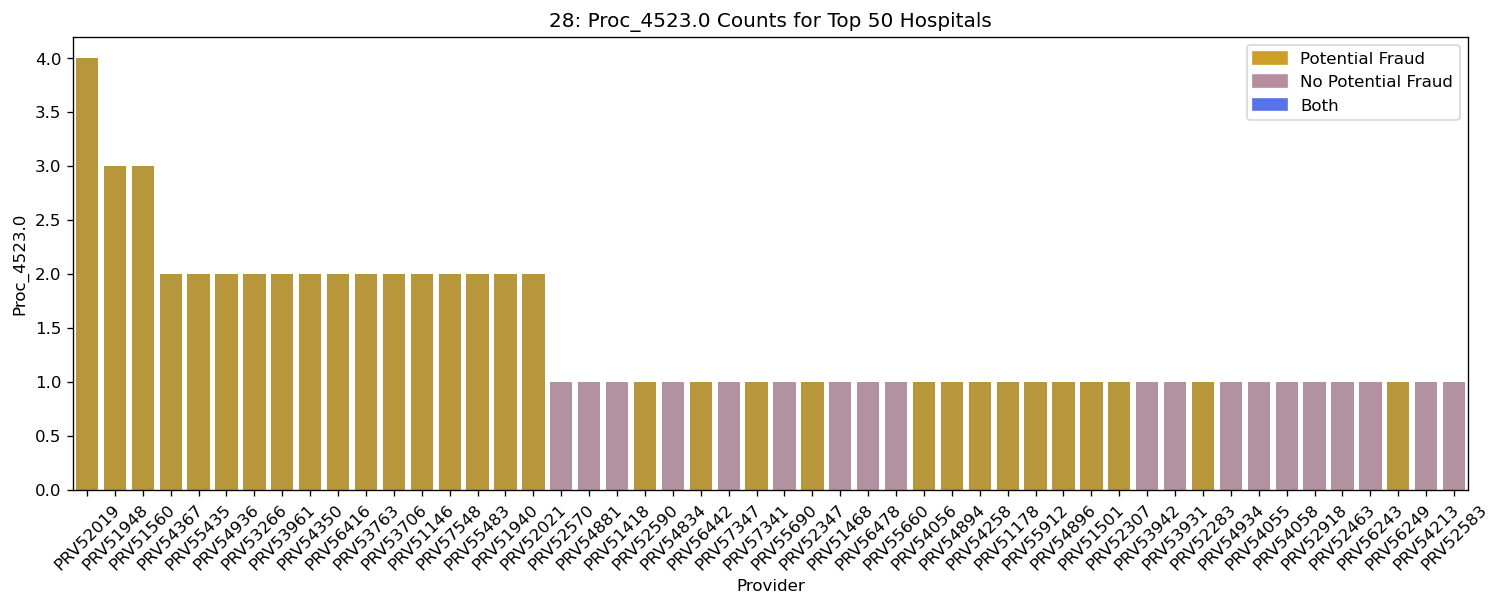

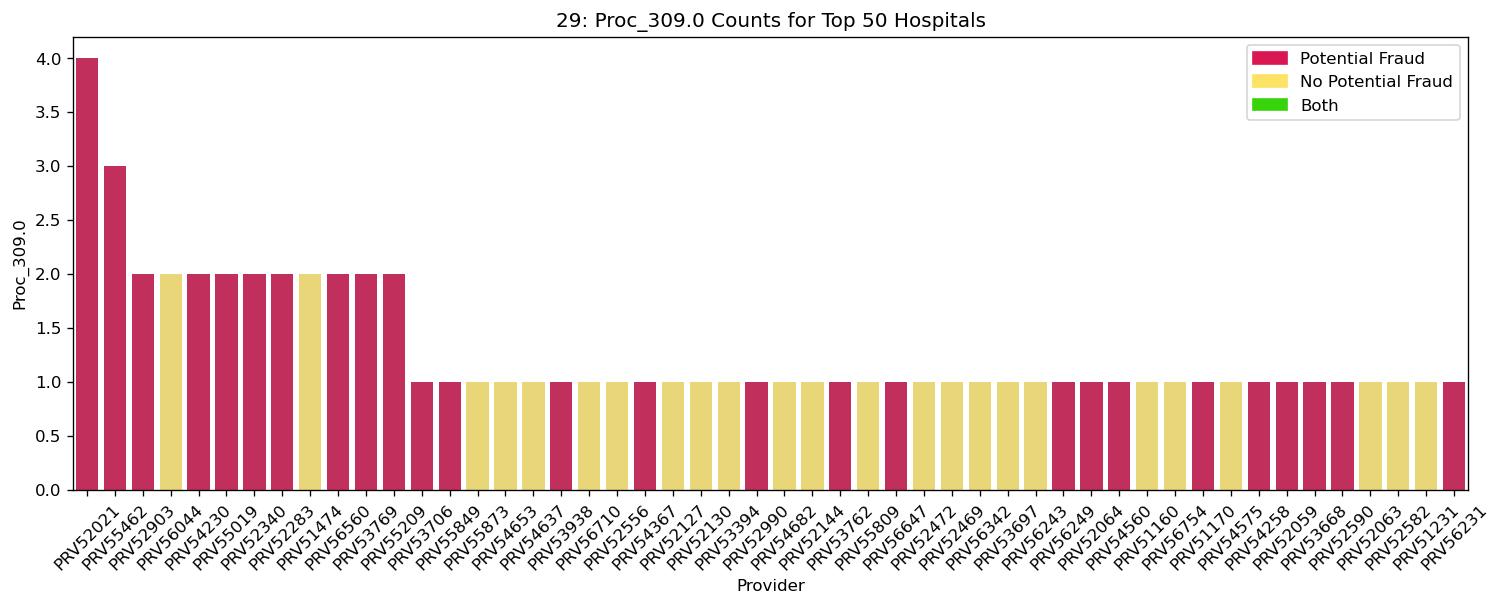

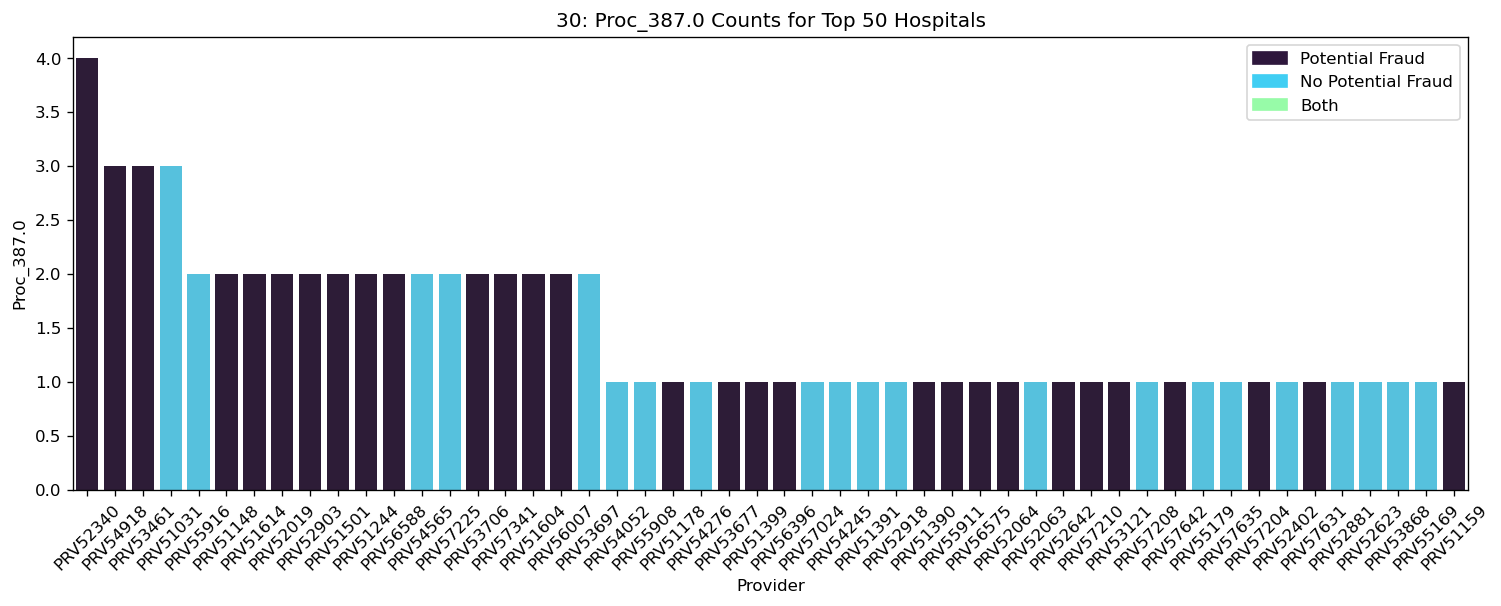

In [98]:
## plot most frequetly used diagnosis codes 
df=pd.DataFrame()
for c in procedurecodelist:
    l=df_procedure.isin([c]).sum(axis=1)
    df['Proc_'+str(c)]=l
df=pd.concat([train[['Provider','PotentialFraud']], df], axis=1)
df=df.groupby(['Provider','PotentialFraud']).sum()
collist=df.columns
i=0
for c in collist:
    i=i+1
    df_code=df.reset_index().sort_values(by=c, ascending=False).head(50)
    bar_by_category(df_code, 'Provider', c, 'PotentialFraud', 
                title=str(i)+': '+ c+' Counts for Top 50 Hospitals')

## Duplicate Physicians 

In [99]:
physicians=pd.melt(train[['BeneID', 'ClaimID', 'Provider', 'Category',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'PotentialFraud']], 
        id_vars=['BeneID','ClaimID', 'Provider','PotentialFraud','Category'], 
        value_vars=train[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], 
        var_name='Type', 
        value_name='Physician').sort_values(by=['ClaimID','Type']).dropna(subset=['Physician'])

In [100]:
df=train[['AttendingPhysician','Provider','PotentialFraud']]

In [101]:
P = df.groupby('Provider')['AttendingPhysician'].count().reset_index()
# P['Percentage'] = 100 * P['Title']  / P['Title'].sum()
P.sort_values(by='AttendingPhysician', ascending=False).head()

Provider  AttendingPhysician
363   PRV51459                8207
2250  PRV53797                4726
455   PRV51574                4434
2335  PRV53918                3582
3113  PRV54895                3426

In [102]:
df1=df.groupby(['Provider','AttendingPhysician']).count()
df2=df.groupby(['Provider']).count()
df3=df1/df2
df3=df3.drop('AttendingPhysician', axis=1).sort_values(by=['Provider', 'PotentialFraud'])

In [103]:
df3.loc[['PRV57761', 'PRV51005', 'PRV57730']]

PotentialFraud
Provider AttendingPhysician                
PRV57761 PHY367727                 0.170732
         PHY354815                 0.829268
PRV51005 PHY341553                 0.114163
         PHY391951                 0.127039
         PHY392136                 0.127897
         PHY433622                 0.127897
         PHY319039                 0.230901
         PHY342753                 0.270386
PRV57730 PHY321867                 0.025000
         PHY380898                 0.025000
         PHY409720                 0.025000
         PHY416006                 0.025000
         PHY324524                 0.050000
         PHY348713                 0.050000
         PHY426546                 0.050000
         PHY427950                 0.150000
         PHY339848                 0.275000
         PHY352559                 0.325000

#### States and Counties

Text(0.5, 1.0, 'Duplicate Claim counts for Potential Fraud (Yes/No) by States')

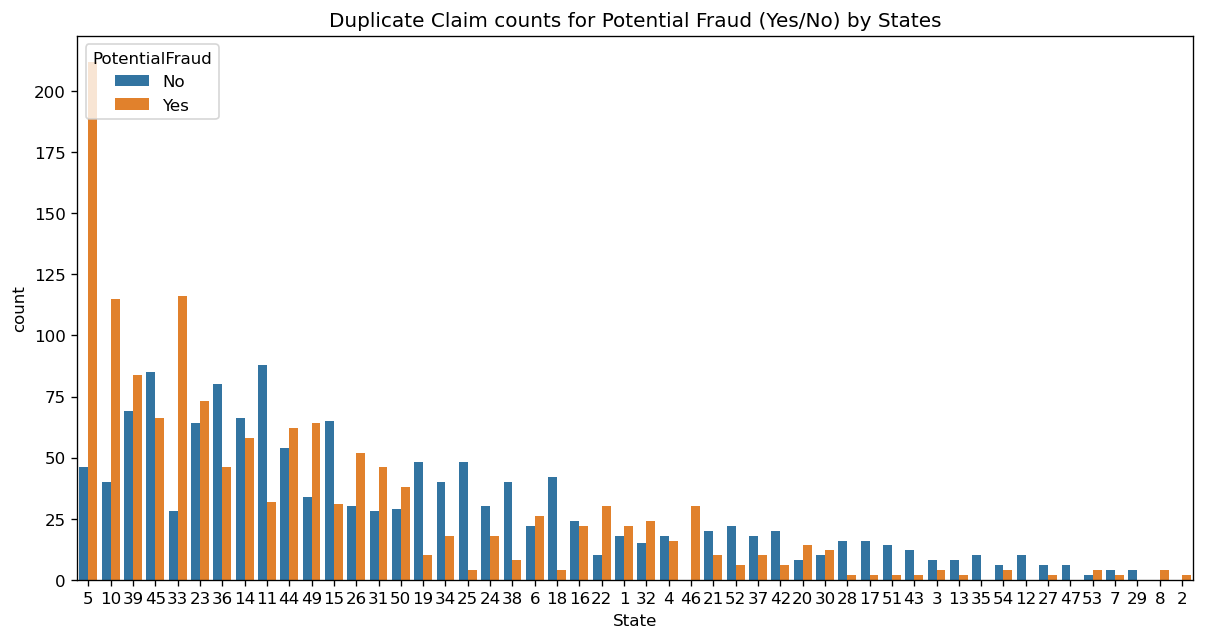

In [104]:
plt.subplots(figsize = (12,6))
feature_ord=some_duplicates.groupby('State').count()['Category'].sort_values(ascending=False).index
sns.countplot('State',data=some_duplicates, hue='PotentialFraud', order=feature_ord)
plt.title('Duplicate Claim counts for Potential Fraud (Yes/No) by States')

Text(0.5, 1.0, 'Duplicate Claim counts for Potential Fraud (Yes/No) by Top 30 Counties')

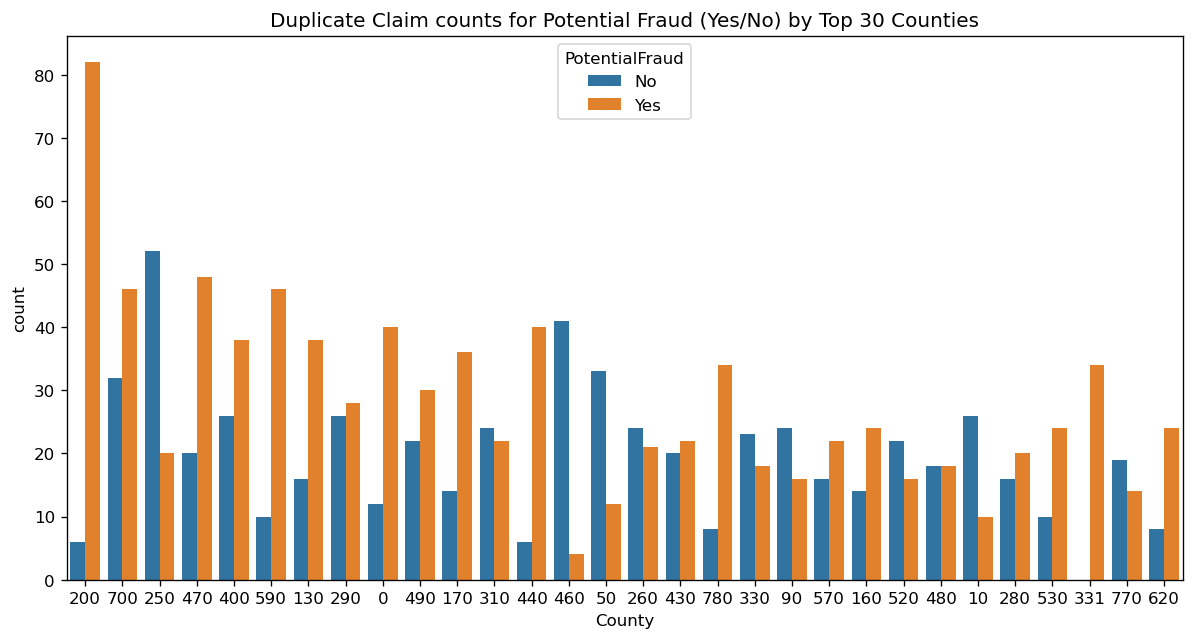

In [105]:
plt.subplots(figsize = (12,6))
feature_ord=some_duplicates.groupby('County').count()['Category'].sort_values(ascending=False).index
top30county=feature_ord.tolist()[:30]
df_county=some_duplicates[some_duplicates['County'].isin(top30county)]
sns.countplot('County',data=df_county, hue='PotentialFraud', order=top30county)
plt.title('Duplicate Claim counts for Potential Fraud (Yes/No) by Top 30 Counties')

<div class="alert-message">
<b>Findings:</b> 
    <li> <font color='red'>State 5 has the most duplicate claims submitted.</font> </li>
    <li> <font color='red'>Most of the duplicate claims submitted by are potential frauds. </font> </li>
    <li> <font color='red'>In the top 30 counties with most duplicate claims: </font> </li>
    <li> <font color='red'>All duplicates from County 460, 50, 700, 680 are potential frauds. </font> </li>
</div>

<h1 style="color:tomato;
           background-color: #FFFF00; 
           padding: 1px;" >Associative Rule Mining </h1>

- Chronic Conditions

In [29]:
chroniclist=['ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

In [30]:
train[chroniclist]

ChronicCond_Alzheimer ChronicCond_Heartfailure ChronicCond_KidneyDisease ChronicCond_Cancer ChronicCond_ObstrPulmonary ChronicCond_Depression ChronicCond_Diabetes ChronicCond_IschemicHeart ChronicCond_Osteoporasis ChronicCond_rheumatoidarthritis ChronicCond_stroke
0                          0                        0                         0                  0                          0                      0                    0                         0                        0                               0                  0
1                          1                        0                         0                  0                          0                      0                    0                         1                        0                               0                  0
2                          1                        0                         0                  0                          0                      0                    0                         1                        0                               0                  0
3                          1                        1                         0                  0                          0                      0                    1                         1                        1                               1                  0
4                          1                        1                         0                  0                          0                      0                    1                         1                        1                               1                  0
...                      ...                      ...                       ...                ...                        ...                    ...                  ...                       ...                      ...                             ...                ...
558206                     0                        0                         0                  0                          0                      0                    0                         1                        0                               1                  0
558207                     0                        1                         0                  0                          1                      0                    0                         1                        0                               0                  0
558208                     1                        1                         1                  0                          1                      1                    1                         1                        1                               1                  0
558209                     1                        1                         1                  0                          1                      1                    1                         1                        1                               1                  0
558210                     0                        1                         0                  1                          0                      0                    1                         1                        0                               0                  0

[558211 rows x 11 columns]

In [31]:
df=train[chroniclist].replace('0',False).replace('1',True)
df.head()

ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  ChronicCond_stroke
0                  False                     False                      False               False                       False                   False                 False                      False                     False                            False               False
1                   True                     False                      False               False                       False                   False                 False                       True                     False                            False               False
2                   True                     False                      False               False                       False                   False                 False                       True                     False                            False               False
3                   True                      True                      False               False                       False                   False                  True                       True                      True                             True               False
4                   True                      True                      False               False                       False                   False                  True                       True                      True                             True               False

In [32]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules 

def arm(df,feature, header=10):
    df_1=df[df[feature]==True]

    frq_items = apriori(df_1, min_support = 0.05, use_colnames = True) 

    # Collecting the inferred rules in a dataframe 
    rules = association_rules(frq_items, metric ="lift", min_threshold =1) 
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
    rules=rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage',
       'conviction']]
    display(rules.head(header).sort_values('support', ascending=False))

In [33]:
for col in df.columns:
    arm(df,col,5)

antecedents              consequents   support  confidence  lift  leverage  conviction
0    (ChronicCond_Heartfailure)  (ChronicCond_Alzheimer)  0.703963         1.0   1.0       0.0         inf
9      (ChronicCond_Depression)  (ChronicCond_Alzheimer)  0.538852         1.0   1.0       0.0         inf
2   (ChronicCond_KidneyDisease)  (ChronicCond_Alzheimer)  0.523174         1.0   1.0       0.0         inf
6  (ChronicCond_ObstrPulmonary)  (ChronicCond_Alzheimer)  0.410495         1.0   1.0       0.0         inf
4          (ChronicCond_Cancer)  (ChronicCond_Alzheimer)  0.172841         1.0   1.0       0.0         inf

antecedents                 consequents   support  confidence  lift  leverage  conviction
21   (ChronicCond_KidneyDisease)  (ChronicCond_Heartfailure)  0.538080         1.0   1.0       0.0         inf
27      (ChronicCond_Depression)  (ChronicCond_Heartfailure)  0.499395         1.0   1.0       0.0         inf
1        (ChronicCond_Alzheimer)  (ChronicCond_Heartfailure)  0.479145         1.0   1.0       0.0         inf
25  (ChronicCond_ObstrPulmonary)  (ChronicCond_Heartfailure)  0.412749         1.0   1.0       0.0         inf
23          (ChronicCond_Cancer)  (ChronicCond_Heartfailure)  0.174238         1.0   1.0       0.0         inf

antecedents                  consequents   support  confidence  lift  leverage  conviction
20    (ChronicCond_Heartfailure)  (ChronicCond_KidneyDisease)  0.771106         1.0   1.0       0.0         inf
43      (ChronicCond_Depression)  (ChronicCond_KidneyDisease)  0.531989         1.0   1.0       0.0         inf
3        (ChronicCond_Alzheimer)  (ChronicCond_KidneyDisease)  0.510305         1.0   1.0       0.0         inf
40  (ChronicCond_ObstrPulmonary)  (ChronicCond_KidneyDisease)  0.455645         1.0   1.0       0.0         inf
38          (ChronicCond_Cancer)  (ChronicCond_KidneyDisease)  0.198375         1.0   1.0       0.0         inf

antecedents           consequents   support  confidence  lift  leverage  conviction
22    (ChronicCond_Heartfailure)  (ChronicCond_Cancer)  0.679557         1.0   1.0       0.0         inf
39   (ChronicCond_KidneyDisease)  (ChronicCond_Cancer)  0.539885         1.0   1.0       0.0         inf
57      (ChronicCond_Depression)  (ChronicCond_Cancer)  0.475487         1.0   1.0       0.0         inf
5        (ChronicCond_Alzheimer)  (ChronicCond_Cancer)  0.458825         1.0   1.0       0.0         inf
54  (ChronicCond_ObstrPulmonary)  (ChronicCond_Cancer)  0.434483         1.0   1.0       0.0         inf

antecedents                   consequents   support  confidence  lift  leverage  conviction
24   (ChronicCond_Heartfailure)  (ChronicCond_ObstrPulmonary)  0.778762         1.0   1.0       0.0         inf
41  (ChronicCond_KidneyDisease)  (ChronicCond_ObstrPulmonary)  0.599899         1.0   1.0       0.0         inf
67     (ChronicCond_Depression)  (ChronicCond_ObstrPulmonary)  0.553729         1.0   1.0       0.0         inf
7       (ChronicCond_Alzheimer)  (ChronicCond_ObstrPulmonary)  0.527161         1.0   1.0       0.0         inf
55         (ChronicCond_Cancer)  (ChronicCond_ObstrPulmonary)  0.210189         1.0   1.0       0.0         inf

antecedents               consequents   support  confidence  lift  leverage  conviction
26    (ChronicCond_Heartfailure)  (ChronicCond_Depression)  0.678131         1.0   1.0       0.0         inf
42   (ChronicCond_KidneyDisease)  (ChronicCond_Depression)  0.504087         1.0   1.0       0.0         inf
8        (ChronicCond_Alzheimer)  (ChronicCond_Depression)  0.498031         1.0   1.0       0.0         inf
66  (ChronicCond_ObstrPulmonary)  (ChronicCond_Depression)  0.398518         1.0   1.0       0.0         inf
56          (ChronicCond_Cancer)  (ChronicCond_Depression)  0.165549         1.0   1.0       0.0         inf

antecedents             consequents   support  confidence  lift  leverage  conviction
28    (ChronicCond_Heartfailure)  (ChronicCond_Diabetes)  0.675705         1.0   1.0       0.0         inf
45   (ChronicCond_KidneyDisease)  (ChronicCond_Diabetes)  0.509563         1.0   1.0       0.0         inf
11       (ChronicCond_Alzheimer)  (ChronicCond_Diabetes)  0.460731         1.0   1.0       0.0         inf
68  (ChronicCond_ObstrPulmonary)  (ChronicCond_Diabetes)  0.377695         1.0   1.0       0.0         inf
58          (ChronicCond_Cancer)  (ChronicCond_Diabetes)  0.170226         1.0   1.0       0.0         inf

antecedents                  consequents   support  confidence  lift  leverage  conviction
30    (ChronicCond_Heartfailure)  (ChronicCond_IschemicHeart)  0.664656         1.0   1.0       0.0         inf
47   (ChronicCond_KidneyDisease)  (ChronicCond_IschemicHeart)  0.478123         1.0   1.0       0.0         inf
13       (ChronicCond_Alzheimer)  (ChronicCond_IschemicHeart)  0.443357         1.0   1.0       0.0         inf
70  (ChronicCond_ObstrPulmonary)  (ChronicCond_IschemicHeart)  0.365665         1.0   1.0       0.0         inf
60          (ChronicCond_Cancer)  (ChronicCond_IschemicHeart)  0.168294         1.0   1.0       0.0         inf

antecedents                 consequents   support  confidence  lift  leverage  conviction
32    (ChronicCond_Heartfailure)  (ChronicCond_Osteoporasis)  0.649904         1.0   1.0       0.0         inf
48   (ChronicCond_KidneyDisease)  (ChronicCond_Osteoporasis)  0.476702         1.0   1.0       0.0         inf
15       (ChronicCond_Alzheimer)  (ChronicCond_Osteoporasis)  0.457505         1.0   1.0       0.0         inf
72  (ChronicCond_ObstrPulmonary)  (ChronicCond_Osteoporasis)  0.372571         1.0   1.0       0.0         inf
62          (ChronicCond_Cancer)  (ChronicCond_Osteoporasis)  0.175480         1.0   1.0       0.0         inf

antecedents                        consequents   support  confidence  lift  leverage  conviction
34    (ChronicCond_Heartfailure)  (ChronicCond_rheumatoidarthritis)  0.677321         1.0   1.0       0.0         inf
51   (ChronicCond_KidneyDisease)  (ChronicCond_rheumatoidarthritis)  0.512956         1.0   1.0       0.0         inf
17       (ChronicCond_Alzheimer)  (ChronicCond_rheumatoidarthritis)  0.466117         1.0   1.0       0.0         inf
74  (ChronicCond_ObstrPulmonary)  (ChronicCond_rheumatoidarthritis)  0.400152         1.0   1.0       0.0         inf
64          (ChronicCond_Cancer)  (ChronicCond_rheumatoidarthritis)  0.181245         1.0   1.0       0.0         inf

antecedents           consequents   support  confidence  lift  leverage  conviction
36    (ChronicCond_Heartfailure)  (ChronicCond_stroke)  0.791427         1.0   1.0       0.0         inf
53   (ChronicCond_KidneyDisease)  (ChronicCond_stroke)  0.626988         1.0   1.0       0.0         inf
19       (ChronicCond_Alzheimer)  (ChronicCond_stroke)  0.591853         1.0   1.0       0.0         inf
78  (ChronicCond_ObstrPulmonary)  (ChronicCond_stroke)  0.487540         1.0   1.0       0.0         inf
67          (ChronicCond_Cancer)  (ChronicCond_stroke)  0.193533         1.0   1.0       0.0         inf

<div class="alert-warning">
<b>Findings:</b> 
    <li> <font color='red'>Most supportive antecedents and its consequents are:
        (ChronicCond_Heartfailure)	(ChronicCond_Alzheimer)	0.703963
        (ChronicCond_Heartfailure)	(ChronicCond_KidneyDisease)	0.771106
        (ChronicCond_Heartfailure)	(ChronicCond_Cancer)	0.679557	
        (ChronicCond_Heartfailure)	(ChronicCond_ObstrPulmonary)	0.778762	
        (ChronicCond_Heartfailure)	(ChronicCond_Depression)	0.678131	
        (ChronicCond_Heartfailure)	(ChronicCond_Diabetes)	0.675705
        ChronicCond_Heartfailure)	(ChronicCond_IschemicHeart)	0.664656	
        (ChronicCond_Heartfailure)	(ChronicCond_Osteoporasis)	0.649904	
        (ChronicCond_Heartfailure)	(ChronicCond_rheumatoidarthritis)	0.677321
        (ChronicCond_Heartfailure)	(ChronicCond_stroke)	0.791427	
            (ChronicCond_KidneyDisease)	(ChronicCond_stroke)	0.626988'
        </li>
    <li> <font color='red'> It means, if the patient has heartfailure, it might mean that he has almost all other chronic conditions. </li>
    <li> <font color='red'> The second sevious condition is KidneyDisease and the third one is ChronicCond_Alzheimer. They all have relatively high support rates of at least 40%. It means if you have KidneyDisease or Alzheimer, there are possibility that you have all other chronic disease too. </li>
</div>

- Claim Diagnosis Codes and Precedure Codes

In [34]:
Diagnosiscodelist=['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode','DiagnosisGroupCode']
Procedurecodelist=[
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

In [35]:
df_diagnosis=train[Diagnosiscodelist].replace('0',np.nan).dropna(how='all').replace(np.nan,'0')
df_procedure=train[Procedurecodelist].replace('0',np.nan).dropna(how='all').replace(np.nan,'0')

In [38]:
def most_codes(df):
    df_codes=pd.DataFrame()
    for col in df.columns:
        df_codes[col]=df.groupby([col]).count().iloc[:,1].sort_values(ascending=False)  
    if df_codes.index.isin(['nan']).any():
        df_codes.drop(['nan'], inplace=True)   
    if df_codes.index.isin(['0']).any():
        df_codes.drop(['0'], inplace=True)   
    df_codes=df_codes.sum(axis=1).sort_values(ascending=False)
    return df_codes

def arm_codes(df,n):
    df_codes=most_codes(df)
    display(df_codes.head(n))
    cl=df_codes.index[:n].to_list()
    df1=df[df.isin(cl)]
    df1=df1.transpose()
    display(df1)
    df_arm=pd.DataFrame()
    for l in cl:
        df_arm[l]=df1.isin([l]).any()
        
    for col in df_arm.columns:
        arm(df_arm,col,5)
    
arm_codes(df_diagnosis,20)    

ClmDiagnosisCode_1
4019     79788.0
25000    39724.0
2724     37270.0
V5869    25410.0
4011     24804.0
42731    23772.0
V5861    21537.0
2720     19103.0
2449     18292.0
4280     16651.0
41401    15246.0
53081    15171.0
496      13874.0
2859     13398.0
78079    12741.0
41400    12439.0
5990     12185.0
28521    10181.0
3051      9099.0
2809      8333.0
dtype: float64

0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     49     50     51     52     53     54     55     56     57     58     59     60     61     62     63     64     65     66     67     68     69     70     71     72     73     74     75     76     77     78     79     80     81     82     83     84     85     86     87     88     89     90     91     92     93     94     95     96     97     98     99     100     ... 558111 558112 558113 558114 558115 558116 558117 558118 558119 558120 558121 558122 558123 558124 558125 558126 558127 558128 558129 558130 558131 558132 558133 558134 558135 558136 558137 558138 558139 558140 558141 558142 558143 558144 558145 558146 558147 558148  \
ClmDiagnosisCode_1       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   2724    NaN    NaN    NaN   4019    NaN    NaN    NaN    NaN   4019    NaN    NaN    NaN    NaN    NaN  78079    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4019    NaN   4019    NaN    NaN    NaN    NaN   4011  78079    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4011    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4019    NaN   2720   4011    NaN   4019  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4280    NaN    NaN    NaN    NaN    NaN   5990    NaN    NaN   4280    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  41401    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
ClmDiagnosisCode_2       NaN    NaN    NaN    NaN    NaN    NaN   4280    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4011    NaN   4019    NaN    NaN    NaN    NaN    NaN    NaN   4019    NaN    NaN    NaN    NaN    NaN  25000    NaN    NaN    NaN    NaN   2724    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  42731   2720   2720    NaN    NaN    NaN    NaN    NaN  V5869   4019    NaN    NaN    NaN    NaN    NaN    NaN    NaN  78079    NaN  53081  V5869    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4280    NaN    NaN    NaN    NaN   2724    NaN  42731  41400    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   2724    NaN  78079  ...  53081    NaN   4019  42731    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  41401  42731    NaN    NaN    NaN   2724    NaN    NaN  53081    NaN    NaN   4019  28521   4019    NaN    NaN    NaN    496   2724   4019    NaN    NaN    NaN  41401    NaN   5990   
ClmDiagnosisCode_3       NaN    NaN    NaN    NaN    NaN    NaN   2449    NaN    NaN    NaN    NaN   4019    NaN    NaN    NaN    NaN    NaN    496    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   4019    NaN    NaN    NaN    NaN    NaN    496    NaN    NaN    NaN   2449  25000    NaN    NaN  V5861   2724    NaN    NaN    NaN    NaN    NaN   2859    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  25000    NaN   4019    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   2724    NaN  41401    NaN    NaN    NaN    NaN   2720    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  25000    NaN    NaN    NaN    NaN    NaN    NaN  25000  53081   2449    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    496    NaN    NaN   5990  25000   
ClmDiagnosisCode_4       NaN    NaN   

antecedents consequents   support  confidence  lift  leverage  conviction
2      (2724)      (4019)  0.139529         1.0   1.0       0.0         inf
1     (25000)      (4019)  0.137808         1.0   1.0       0.0         inf
4     (V5869)      (4019)  0.070300         1.0   1.0       0.0         inf
9     (42731)      (4019)  0.063685         1.0   1.0       0.0         inf
7      (4011)      (4019)  0.054649         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)     (25000)  0.273581         1.0   1.0       0.0         inf
2      (2724)     (25000)  0.133489         1.0   1.0       0.0         inf
6      (4011)     (25000)  0.075676         1.0   1.0       0.0         inf
4     (V5869)     (25000)  0.070742         1.0   1.0       0.0         inf
8     (42731)     (25000)  0.068060         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
3       (4019)      (2724)  0.296453         1.0   1.0       0.0         inf
5      (25000)      (2724)  0.142865         1.0   1.0       0.0         inf
9       (4011)      (2724)  0.116789         1.0   1.0       0.0         inf
7      (V5869)      (2724)  0.079069         1.0   1.0       0.0         inf
11     (42731)      (2724)  0.071568         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
1      (4019)     (V5869)  0.217671         1.0   1.0       0.0         inf
4      (2724)     (V5869)  0.115228         1.0   1.0       0.0         inf
3     (25000)     (V5869)  0.110335         1.0   1.0       0.0         inf
7      (4011)     (V5869)  0.079594         1.0   1.0       0.0         inf
9     (42731)     (V5869)  0.063731         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
4      (2724)      (4011)  0.177834         1.0   1.0       0.0         inf
0      (4019)      (4011)  0.176803         1.0   1.0       0.0         inf
3     (25000)      (4011)  0.123325         1.0   1.0       0.0         inf
9      (2720)      (4011)  0.090051         1.0   1.0       0.0         inf
6     (V5869)      (4011)  0.083165         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)     (42731)  0.215751         1.0   1.0       0.0         inf
8     (V5861)     (42731)  0.136307         1.0   1.0       0.0         inf
3     (25000)     (42731)  0.116144         1.0   1.0       0.0         inf
4      (2724)     (42731)  0.114114         1.0   1.0       0.0         inf
6     (V5869)     (42731)  0.069729         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
1      (4019)     (V5861)  0.152978         1.0   1.0       0.0         inf
9     (42731)     (V5861)  0.147917         1.0   1.0       0.0         inf
7     (V5869)     (V5861)  0.109450         1.0   1.0       0.0         inf
3     (25000)     (V5861)  0.081385         1.0   1.0       0.0         inf
5      (2724)     (V5861)  0.074825         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
2       (4019)      (2720)  0.285533         1.0   1.0       0.0         inf
6       (2724)      (2720)  0.148209         1.0   1.0       0.0         inf
4      (25000)      (2720)  0.132833         1.0   1.0       0.0         inf
10      (4011)      (2720)  0.115397         1.0   1.0       0.0         inf
8      (V5869)      (2720)  0.087076         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
3       (4019)      (2449)  0.285276         1.0   1.0       0.0         inf
6       (2724)      (2449)  0.145649         1.0   1.0       0.0         inf
5      (25000)      (2449)  0.134647         1.0   1.0       0.0         inf
11      (4011)      (2449)  0.087739         1.0   1.0       0.0         inf
8      (V5869)      (2449)  0.078380         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)      (4280)  0.259382         1.0   1.0       0.0         inf
2     (25000)      (4280)  0.154781         1.0   1.0       0.0         inf
4      (2724)      (4280)  0.134584         1.0   1.0       0.0         inf
8     (42731)      (4280)  0.127229         1.0   1.0       0.0         inf
6     (V5869)      (4280)  0.050742         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
4       (4019)     (41401)  0.314057         1.0   1.0       0.0         inf
8       (2724)     (41401)  0.178185         1.0   1.0       0.0         inf
7      (25000)     (41401)  0.160924         1.0   1.0       0.0         inf
13     (42731)     (41401)  0.114178         1.0   1.0       0.0         inf
10     (V5869)     (41401)  0.053261         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
4       (4019)     (53081)  0.311571         1.0   1.0       0.0         inf
6      (25000)     (53081)  0.149673         1.0   1.0       0.0         inf
8       (2724)     (53081)  0.135532         1.0   1.0       0.0         inf
12     (42731)     (53081)  0.077050         1.0   1.0       0.0         inf
10     (V5869)     (53081)  0.058878         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)       (496)  0.281900         1.0   1.0       0.0         inf
3     (25000)       (496)  0.142177         1.0   1.0       0.0         inf
4      (2724)       (496)  0.124423         1.0   1.0       0.0         inf
8     (42731)       (496)  0.080471         1.0   1.0       0.0         inf
6     (V5869)       (496)  0.060984         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)      (2859)  0.249794         1.0   1.0       0.0         inf
3     (25000)      (2859)  0.129284         1.0   1.0       0.0         inf
4      (2724)      (2859)  0.126659         1.0   1.0       0.0         inf
8      (4011)      (2859)  0.073041         1.0   1.0       0.0         inf
6     (V5869)      (2859)  0.071091         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)     (78079)  0.236107         1.0   1.0       0.0         inf
2     (25000)     (78079)  0.120141         1.0   1.0       0.0         inf
4      (2724)     (78079)  0.115885         1.0   1.0       0.0         inf
6     (V5869)     (78079)  0.079987         1.0   1.0       0.0         inf
8      (4011)     (78079)  0.077899         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
5       (4019)     (41400)  0.290658         1.0   1.0       0.0         inf
7      (25000)     (41400)  0.149080         1.0   1.0       0.0         inf
8       (2724)     (41400)  0.145692         1.0   1.0       0.0         inf
11     (V5869)     (41400)  0.064940         1.0   1.0       0.0         inf
13      (4011)     (41400)  0.061713         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
0      (4019)      (5990)  0.248976         1.0   1.0       0.0         inf
2     (25000)      (5990)  0.134425         1.0   1.0       0.0         inf
4      (2724)      (5990)  0.113272         1.0   1.0       0.0         inf
6     (42731)      (5990)  0.093910         1.0   1.0       0.0         inf
8      (2449)      (5990)  0.070283         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
1      (2809)     (28521)  0.374705    1.000000   1.0       0.0         inf
0     (28521)      (2809)  0.374705    0.374705   1.0       0.0         1.0

antecedents consequents   support  confidence  lift  leverage  conviction
2       (4019)      (3051)  0.292216         1.0   1.0       0.0         inf
4      (25000)      (3051)  0.146988         1.0   1.0       0.0         inf
6       (2724)      (3051)  0.118184         1.0   1.0       0.0         inf
10     (42731)      (3051)  0.065853         1.0   1.0       0.0         inf
8      (V5869)      (3051)  0.059477         1.0   1.0       0.0         inf

antecedents consequents   support  confidence  lift  leverage  conviction
4     (28521)      (2809)  0.457682    1.000000   1.0       0.0         inf
5      (2809)     (28521)  0.457682    0.457682   1.0       0.0         1.0
1      (4019)      (2809)  0.081510    1.000000   1.0       0.0         inf
0      (2809)      (4019)  0.081510    0.081510   1.0       0.0         1.0
3     (25000)      (2809)  0.059389    1.000000   1.0       0.0         inf

<div class="alert-warning">
<b>Findings:</b> 
    <li> <font color='red'>There are totally 10450 claim diagnosis codes. </li>    
    <li> <font color='red'>Most supportive antecedent diagnosis codes are  4019, 2724, 42731. They have higher possibilities to combined with more other codes then other diagnosis codes. </li>
        
</div>

In [37]:
arm_codes(df_procedure, 20)   

ClmProcedureCode_1
4019.0    1959.0
9904.0    1152.0
2724.0    1054.0
8154.0    1022.0
66.0       901.0
3893.0     854.0
3995.0     809.0
4516.0     651.0
3722.0     589.0
8151.0     463.0
8872.0     411.0
9671.0     402.0
4513.0     365.0
9390.0     333.0
9672.0     307.0
5123.0     290.0
7935.0     277.0
8152.0     260.0
9339.0     253.0
311.0      248.0
dtype: float64

antecedents consequents   support  confidence  lift  leverage  conviction
2      (66.0)    (4019.0)  0.147014    1.000000   1.0       0.0         inf
3    (4019.0)      (66.0)  0.147014    0.147014   1.0       0.0         1.0
1    (2724.0)    (4019.0)  0.101072    1.000000   1.0       0.0         inf
0    (4019.0)    (2724.0)  0.101072    0.101072   1.0       0.0         1.0

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents   support  confidence      lift  leverage  conviction
4          (66.0)    (2724.0)  0.268501    1.000000  1.000000  0.000000         inf
0        (4019.0)    (2724.0)  0.187856    1.000000  1.000000  0.000000         inf
8  (66.0, 4019.0)    (2724.0)  0.082543    1.000000  1.000000  0.000000         inf
3        (4019.0)      (66.0)  0.082543    0.439394  1.636471  0.032103    1.304836
6        (3722.0)    (2724.0)  0.069260    1.000000  1.000000  0.000000         inf

antecedents consequents   support  confidence  lift  leverage  conviction
1    (4019.0)    (8154.0)  0.089041    1.000000   1.0       0.0         inf
0    (8154.0)    (4019.0)  0.089041    0.089041   1.0       0.0         1.0

antecedents consequents   support  confidence  lift  leverage  conviction
1          (4019.0)      (66.0)  0.319645    1.000000   1.0       0.0         inf
0            (66.0)    (4019.0)  0.319645    0.319645   1.0       0.0         1.0
3          (2724.0)      (66.0)  0.314095    1.000000   1.0       0.0         inf
2            (66.0)    (2724.0)  0.314095    0.314095   1.0       0.0         1.0
4  (4019.0, 2724.0)      (66.0)  0.096559    1.000000   1.0       0.0         inf

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents   support  confidence  lift  leverage  conviction
0    (4019.0)    (4516.0)  0.056836    1.000000   1.0       0.0         inf
1    (4516.0)    (4019.0)  0.056836    0.056836   1.0       0.0         1.0

antecedents consequents   support  confidence  lift  leverage  conviction
1    (4019.0)    (3722.0)  0.130730    1.000000   1.0       0.0         inf
0    (3722.0)    (4019.0)  0.130730    0.130730   1.0       0.0         1.0
3    (2724.0)    (3722.0)  0.123939    1.000000   1.0       0.0         inf
2    (3722.0)    (2724.0)  0.123939    0.123939   1.0       0.0         1.0

antecedents consequents   support  confidence  lift  leverage  conviction
0    (4019.0)    (8151.0)  0.084233    1.000000   1.0       0.0         inf
1    (8151.0)    (4019.0)  0.084233    0.084233   1.0       0.0         1.0

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents   support  confidence  lift  leverage  conviction
0    (4019.0)    (9671.0)  0.064677    1.000000   1.0       0.0         inf
1    (9671.0)    (4019.0)  0.064677    0.064677   1.0       0.0         1.0

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents  support  confidence  lift  leverage  conviction
1    (4019.0)    (5123.0)      0.1         1.0   1.0       0.0         inf
0    (5123.0)    (4019.0)      0.1         0.1   1.0       0.0         1.0

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents  support  confidence  lift  leverage  conviction
1    (4019.0)    (8152.0)      0.1         1.0   1.0       0.0         inf
0    (8152.0)    (4019.0)      0.1         0.1   1.0       0.0         1.0

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift, leverage, conviction]
Index: []

antecedents consequents   support  confidence  lift  leverage  conviction
0    (4019.0)     (311.0)  0.116935    1.000000   1.0       0.0         inf
1     (311.0)    (4019.0)  0.116935    0.116935   1.0       0.0         1.0
2      (66.0)     (311.0)  0.056452    1.000000   1.0       0.0         inf
3     (311.0)      (66.0)  0.056452    0.056452   1.0       0.0         1.0

<div class="alert-warning">
<b>Findings:</b> 
    <li> <font color='red'>There are totally 1117 claim procedure codes. </li>    
    <li> <font color='red'>The association Rule Mining packages doesn't give results for procedure codes perhaps because 
        </li>
</div>